In [220]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
import warnings
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from scipy.ndimage.filters import gaussian_filter1d

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4)
mpl.rcParams['figure.subplot.wspace'] = 0.25
mpl.rcParams['figure.subplot.hspace'] = 0.25
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, time_cell_plots

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

# Figure sizes
We have 6.55w $\times$ 8.57h" to mess with.

Keep at least 0.15-0.3 in between columns, so,
* 1 column  : 6.55
* 2 columns : (3.15, 3.15) or (2.1, 4.2)
* 3 columns : 2.083
* 4 columns : 1.525
* 5 columns : 1.19
* 6 columns : 0.967

In [221]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [3]:
def trial_raster4(subj_sess,
                  neuron,
                  game_states=['Delay1', 'Encoding', 'Delay2', 'Retrieval'],
                  plot_vlines=True,
                  plot_labels=True,
                  plot_game_states=True,
                  plot_title=True,
                  proj_dir='/home1/dscho/projects/time_cells',
                  ax=None,
                  **kws):
    """Plot spike rasters for each trial, and return ax."""
    # Load data to make the plot.
    if isinstance(game_states, str):
        game_states = [game_states]
    game_state_durs = od({k:v for (k, v) in events_proc.get_game_state_durs().items() if k in game_states})
    events = events_proc.load_events(subj_sess, proj_dir=proj_dir, verbose=False)
    spikes = spike_preproc.load_spikes(subj_sess, neuron, proj_dir=proj_dir)
    
    # Get user-defined params.
    colws = kws.pop('colws', {1: 2.05, 2: 3.125, 3: 6.45})
    dpi = kws.pop('dpi', 1200)
    font = kws.pop('font', {'tick': 6, 'label': 7, 'annot': 7, 'fig': 9})
    labelpad = kws.pop('labelpad', 1)
    xtick_inc = kws.pop('xtick_inc', 10)
    rastersize = kws.pop('rastersize', 1)
    rasterwidth = kws.pop('rasterwidth', 0.1)
    ax_linewidth = kws.pop('ax_linewidth', 0.5)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(colws[1], colws[1] * (2/3)), dpi=1200)
        
    # For each trial, convert spike times to a downsampled spike train.
    for iTrial, trial in enumerate(events.keep_trials):
        spike_train = []
        for game_state in game_states:
            row = events.event_times.query("(trial=={}) & (gameState=='{}')".format(trial, game_state)).sort_values('trial', ascending=True)
            assert len(row) == 1
            row = row.iloc[0]
            
            # Find spike times within each event window.
            event_start, event_stop = row['time_bins'][0], row['time_bins'][-1]
            spike_times = spikes['spike_times'][(spikes['spike_times']>=event_start) & (spikes['spike_times']<event_stop)] - event_start
                        
            # Convert spike times to spike train.
            spike_train_ = np.zeros(game_state_durs[game_state])
            spike_train_[spike_times] = iTrial + 1
            spike_train_[spike_train_==0] = np.nan
            spike_train.append(spike_train_)
                
        spike_train = np.concatenate(spike_train)
        ax.plot(spike_train, linewidth=0, marker='|', 
                markerfacecolor='k', markeredgecolor='k',
                markersize=rastersize, markeredgewidth=rasterwidth)

    # Concentate spikes across trial phases.
    v_lines = np.cumsum([0] + list(game_state_durs.values()))
    if plot_vlines:
        for x in v_lines[1:]:
            ax.axvline(x=x, color='k', alpha=1, linewidth=ax_linewidth)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(ax_linewidth)
    ax.tick_params(axis='both', which='both', length=2, width=ax_linewidth, pad=1)
    xticks = np.arange(0, v_lines[-1] + 1, xtick_inc * 1000)
    ax.set_xlim([-1000, v_lines[-1] + 1000])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(0, (v_lines[-1]/1000)+1, xtick_inc, dtype=np.int), 
                       fontsize=font['tick'], rotation=0)
    if 'ymin' in kws and 'ymax' in kws:
        ax.set_ylim([ymin, ymax+1])
    ax.invert_yaxis()
    yticks = np.arange(6, len(events.keep_trials)+1, 6, dtype=np.int)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=font['tick'], rotation=0)
    if plot_labels:
        ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
        ax.set_ylabel('Trial', fontsize=font['label'], labelpad=labelpad)
        if plot_game_states:
            annot_x = v_lines[:-1] + (np.diff(v_lines) / 2)
            for ii in range(len(annot_x)):
                ax.text(annot_x[ii]/v_lines[-1], 1.1, game_states[ii].replace('Delay', 'Delay '), ha='center', 
                        va='center', fontsize=font['annot'], transform=ax.transAxes)
    if plot_title:
        ax_title = '{}-{} ({})'.format(subj_sess, neuron, spikes['hemroi'])
        if len(game_states) == 1:
            ax_title += ', {}'.format(game_states[0])
        ax.set_title(ax_title, loc='left', pad=6, fontsize=font['fig'])
    
    return ax

In [4]:
def plot_firing_maze(subj_sess,
                     neuron,
                     game_state,
                     scale_by=10,
                     draw_base=True,
                     show_nav=True,
                     show_spikes=True,
                     only_show_spikes_when_moving=False,
                     **kws):
    """Plot unit firing by 2D maze position."""
    # Load player position and spiking data.
    events = events_proc.load_events(subj_sess, proj_dir=proj_dir, verbose=False)
    events.maze.maze.loc[:, 'region_precise'] = events.maze.maze['region_precise'].apply(lambda x: x.replace(' ', '_'))
    _origin = events.maze.origin * scale_by
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=proj_dir, verbose=False)
    
    # Find the most recent position to each spike.
    spike_times = spike_preproc.load_spikes(subj_sess, neuron)['spike_times']
    spike_loc = []
    for trial in events.keep_trials:
        _positions = events.positions.query("(trial=={}) & (gameState=='{}')".format(trial, game_state)).reset_index(drop=True)
        keep_spikes = np.any(events.event_times.query("(trial=={}) & (gameState=='{}')".format(trial, game_state))['time_bins']
                                               .apply(lambda x: [x[0]<=spike<x[-1] for spike in spike_times]).tolist(), axis=0)
        _spike_times = spike_times[keep_spikes]
        spike_pos_arr = np.array(_positions['start_time'].apply(lambda x: [spike - x for spike in _spike_times]).tolist()) # pos x spike
        spike_pos_arr[spike_pos_arr<0] = 1e6
        _spike_loc = (_positions.loc[np.argmin(spike_pos_arr, axis=0), 'pos']
                                .apply(lambda x: tuple([((x[_i] * scale_by) - _origin[_i]) for _i in range(len(x))])))
        if only_show_spikes_when_moving:
            keep_spikes = _positions.loc[np.argmin(spike_pos_arr, axis=0), 'moved_pos']
            _spike_loc = _spike_loc[keep_spikes]
        spike_loc += _spike_loc.tolist()
    spike_loc = np.array(spike_loc) # spike x (xPos, yPos)

    # Calculate mean firing rate (Hz) in each maze region.
    fr_pos = (event_spikes.event_spikes.query("(gameState=='{}')".format(game_state))
                                       .groupby('maze_region')[neuron].mean() * 2)  
    shp = events.maze.shape * scale_by
    maze_fr_mat = np.zeros(shp) * np.nan
    for idx, maze_row in events.maze.maze.iterrows():
        if maze_row['region_precise'] in fr_pos:
            coords = (np.array(maze_row['coords']) * scale_by) - _origin
            mesh_coords = tuple(np.meshgrid(range(coords[0][0], coords[1][0]), 
                                            range(coords[0][1], coords[1][1])))
            maze_fr_mat[mesh_coords] = fr_pos[maze_row['region_precise']]

    # Get a mask of the maze walls.
    mask = np.zeros(shp) * np.nan
    for idx, maze_row in events.maze.maze.query("(region=='wall')").iterrows():
        coords = (np.array(maze_row['coords']) * scale_by) - _origin
        mesh_coords = tuple(np.meshgrid(range(coords[0][0], coords[1][0]), 
                                        range(coords[0][1], coords[1][1])))
        mask[mesh_coords] = 1
    
    # -------------------------------------------------
    # Get user-defined plot params.
    if 'vmin' not in kws:
        if fr_pos.max() < 6:
            kws['vmin'] = 0
        else:
            kws['vmin'] = np.max((0, int(fr_pos.min() - (0.2 * (fr_pos.max() - fr_pos.min())))))
    kws['vmax'] = kws.get('vmax', np.max(maze_fr_mat[np.isfinite(maze_fr_mat)]))
    colws = kws.pop('colws', {1: 2.05, 2: 3.125, 3: 6.45})
    grid_shp = (100, 107)
    figsize = (colws[1], colws[1] * (grid_shp[0]/grid_shp[1]))
    dpi = kws.pop('dpi', 1200)
    font = kws.pop('font', {'tick': 6, 'label': 7, 'fig': 9})
    wall_cmap = kws.pop('wall_cmap', 'binary')
    wall_vmin = kws.pop('wall_vmin', 0)
    wall_vmax = kws.pop('wall_vmax', 1)
    fr_cmap = kws.pop('fr_cmap', 'binary_r')
    base_lw = kws.pop('base_lw', 0.4)
    base_color = kws.pop('base_color', '#538d89')
    nav_alpha = kws.pop('nav_alpha', 0.25)
    nav_lw = kws.pop('nav_lw', 0.12)
    nav_color = kws.pop('nav_color', '#f0b2b2')
    spike_marker = kws.pop('spike_marker', 'x')
    spike_fill_color = kws.pop('spike_fill_color', '#e10600')
    spike_edge_color = kws.pop('spike_edge_color', 'w')
    ticklength = kws.pop('ticklength', 2)
    tickwidth = kws.pop('tickwidth', 0.5)
    tickpad = kws.pop('tickpad', 2)
    labelpad = kws.pop('labelpad', 3)
    cbar_label = kws.pop('cbar_label', None)
    
    # Autoscale spikes if params are not passed.
    if np.any(('spike_alpha' in kws, 'spike_markersize' in kws, 'spike_mew' in kws)):
        spike_alpha = kws.pop('spike_alpha', 0.5)
        spike_markersize = kws.pop('spike_markersize', 0.75)
        spike_mew = kws.pop('spike_mew', 0.15)
    else:
        if len(spike_loc) < 3000:
            spike_alpha = 0.5
            spike_markersize = 0.75
            spike_mew = 0.15
        elif len(spike_loc) < 6000:
            spike_alpha = 0.4
            spike_markersize = 0.7
            spike_mew = 0.14
        elif len(spike_loc) < 10000:
            spike_alpha = 0.3
            spike_markersize = 0.65
            spike_mew = 0.12
        else:
            spike_alpha = 0.2
            spike_markersize = 0.55
            spike_mew = 0.1
    
    # Make the plot.
    plt.close()
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=100, colspan=100),
          plt.subplot2grid(grid_shp, (0, 101), rowspan=100, colspan=6)]
    iax = 0
    
    # Draw the walls.
    _ = ax[iax].imshow(mask.T, cmap=wall_cmap, vmin=wall_vmin, vmax=wall_vmax)

    # Draw a border around the base.
    if draw_base:
        coords = (np.array(events.maze.maze.query("(region=='base')")['coords'].tolist()) * scale_by) - _origin
        coords = np.concatenate((coords[:, 0, :], coords[:, 1, :]))
        base_min = np.min(coords, axis=0)
        base_max = np.max(coords, axis=0)
        base_width, base_height = base_max - base_min
        rect = patches.Rectangle(base_min, base_width, base_height, fill=False, lw=base_lw, ec=base_color)
        ax[iax].add_patch(rect)

    # Make firing rate by maze region heatmap.
    ax[iax] = sns.heatmap(maze_fr_mat.T, ax=ax[iax], cbar=True, cbar_ax=ax[iax+1], cmap=fr_cmap, **kws)

    # Overlay position trajectories.
    if show_nav:
        # all_pos : pd.Series
        #     keys: trial numbers
        #     values: (time, (xPos, yPos)) array of position recordings
        all_pos = (events.positions.query("(gameState=='{}')".format(game_state))
                                   .groupby('trial')['pos']
                                   .apply(lambda x: (np.array(x.tolist()) * scale_by) - _origin))
        for trial in all_pos.index:
            ax[iax].plot(all_pos[trial][:, 0], 
                         all_pos[trial][:, 1],
                         lw=nav_lw,
                         alpha=nav_alpha,
                         color=nav_color)

    # Overlay spikes.
    if show_spikes:
        ax[iax].plot(spike_loc[:, 0], spike_loc[:, 1], lw=0, alpha=spike_alpha, 
                     marker=spike_marker, ms=spike_markersize, mew=spike_mew,
                     mfc=spike_fill_color, mec=spike_edge_color)
    
    # Configure the colorbar.
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], length=ticklength, width=tickwidth, pad=tickpad)
    cbar_ticks = np.linspace(kws['vmin'], kws['vmax'], 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)
    
    # Tweak other plot params.
    ax[iax].set_facecolor('k')
    ax[iax].invert_yaxis()
    ax[iax].set_xticks([])
    ax[iax].set_yticks([])
    
    return fig, ax

In [5]:
def plot_firing_hd(subj_sess,
                   neuron,
                   game_state,
                   n_direc=8,
                   show_center_rlabel=False,
                   ax=None,
                   **kws):
    """Plot unit firing by 2D maze position."""
    def update_rpads(ax, rpad):
        angle = ax._r_label_position.to_values()[4]
        rmax = ax.get_rmax()
        ax._r_label_position.clear().translate(angle, rpad * rmax)
        
    # Load player position and spiking data.
    events = events_proc.load_events(subj_sess, proj_dir=proj_dir, verbose=False)
    spike_times = spike_preproc.load_spikes(subj_sess, neuron)['spike_times']
    
    # Find the most recent player transform to each spike.
    spike_rot = []
    for trial in events.keep_trials:
        _positions = events.positions.query("(trial=={}) & (gameState=='{}')".format(trial, game_state)).reset_index(drop=True)
        keep_spikes = np.any(events.event_times.query("(trial=={}) & (gameState=='{}')".format(trial, game_state))['time_bins']
                                               .apply(lambda x: [x[0]<=spike<x[-1] for spike in spike_times]).tolist(), axis=0)
        _spike_times = spike_times[keep_spikes]
        spike_pos_arr = np.array(_positions['start_time'].apply(lambda x: [spike - x for spike in _spike_times]).tolist()) # pos x spike
        spike_pos_arr[spike_pos_arr<0] = 1e6
        spike_rot += _positions.loc[np.argmin(spike_pos_arr, axis=0), 'rotation'].tolist()
    spike_rot = np.array(spike_rot)
    
    # How many spikes were recorded in each direction?
    spike_hd = np.unique([events._head_direction(x, n_direc) for x in spike_rot], return_counts=True)
    
    # How many positions were recorded in each direction?
    all_hd = np.unique([events._head_direction(x, n_direc) 
                        for x in events.positions.query("(trial=={}) & (gameState=='{}')".format(events.keep_trials, game_state))
                        ['rotation']], return_counts=True)
    
    # Combine into a dataframe.
    head_direc = pd.concat((pd.Series(all_hd[1], all_hd[0], name='pos_count'), 
                            pd.Series(spike_hd[1], spike_hd[0], name='spikes')), 
                           axis=1).reset_index().rename(columns={'index': 'hd'})
    hd_angles = {'N':  (2*np.pi)/4,
                 'NE': (1*np.pi)/4,
                 'E':  (0*np.pi)/4,
                 'SE': (7*np.pi)/4,
                 'S':  (6*np.pi)/4,
                 'SW': (5*np.pi)/4,
                 'W':  (4*np.pi)/4,
                 'NW': (3*np.pi)/4}
    head_direc.insert(1, 'hd_angle', head_direc['hd'].apply(lambda x: hd_angles[x]))
    head_direc = head_direc.sort_values('hd_angle').reset_index(drop=True)

    # What proportion of time was spent going in each direction?
    head_direc.insert(3, 'pct_time', head_direc['pos_count'] / np.sum(head_direc['pos_count']))

    # Calculate firing rates (Hz) in each direction.
    duration = events.event_times.query("(trial=={}) & (gameState=='{}')".format(events.keep_trials, game_state))['time_bin_dur'].sum() * 1e-3
    head_direc['fr'] = head_direc['spikes'] / (duration * head_direc['pct_time'])
    
    # -------------------------------------------------
    # Get user-defined plot params.
    if 'vmin' in kws:
        vmin = kws.pop('vmin')
    elif head_direc['fr'].max() < 6:
        vmin = 0
    else:
        vmin = np.max((0, int(head_direc['fr'].min() - (0.2 * (head_direc['fr'].max() - head_direc['fr'].min())))))
    vmax = kws.get('vmax', head_direc['fr'].max() + (0.2 * (head_direc['fr'].max() - head_direc['fr'].min())))
    colws = kws.pop('colws', {1: 2.05, 2: 3.125, 3: 6.45})
    dpi = kws.pop('dpi', 1200)
    font = kws.pop('font', {'tick': 5, 'label': 6.5})
    bar_width = kws.pop('bar_width', 0.785)
    bar_lw = kws.pop('bar_lw', 0.4)
    bar_color = kws.pop('bar_color', '#e10600')
    bar_ec = kws.pop('bar_ec', mpl.rcParams['grid.color'])
    grid_lw = kws.pop('grid_lw', 0.3)
    grid_linestyle = kws.pop('grid_linestyle', 'dotted')
    grid_color = kws.pop('grid_color', 'k')
    rlabel_rot = kws.pop('rlabel_rot', 45)
    rlabel_pad = kws.pop('rlabel_pad', -0.03)
    
    # Make the plot.
    plt.close()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(colws[1]/2, colws[1]/2), dpi=dpi, subplot_kw={'polar': True})
        ax = np.ravel(ax)

    iax = 0
    ax[iax].grid(alpha=1, lw=grid_lw, linestyle=grid_linestyle, color=grid_color)
    ax[iax].bar(head_direc['hd_angle'], head_direc['fr'], 
                width=bar_width, bottom=0, lw=bar_lw, color=bar_color, ec=bar_ec, zorder=0)
    xticks = [0, (2*np.pi)/4, (4*np.pi)/4, (6*np.pi)/4]
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(['E', 'N', 'W', 'S'], fontsize=font['label'])
    if show_center_rlabel:
        yticks = np.linspace(vmin, vmax, num=4)
    else:
        yticks = np.linspace(vmin, vmax, num=4)[1:]
    ax[iax].set_ylim([vmin, vmax])
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(['{:.1f}'.format(x) for x in yticks], 
                            fontsize=font['tick'], color=grid_color)# #f0b2b2 #3f9bb6 #7abfc9
    ax[iax].tick_params(axis='x', pad=-5)
    ax[iax].set_rlabel_position(rlabel_rot)
    ax[iax].spines['polar'].set_linewidth(0.4)
    if not show_center_rlabel:
        update_rpads(ax[iax], rpad=rlabel_pad)
    
    return fig, ax

In [6]:
def gold_view_raster(subj_sess,
                     neuron,
                     game_state,
                     time_win=3001,
                     proj_dir='/home1/dscho/projects/time_cells',
                     plot_vlines=True,
                     plot_labels=True,
                     plot_title=False,
                     **kws):
    """Show spikes before and after gold view events."""
    # Get input parameters.
    figsize = kws.pop('figsize', (colws['5'], colws['5']))
    dpi = kws.pop('dpi', 1200)
    font = kws.pop('font', {'tick': 6, 'label': 7, 'annot': 7, 'fig': 7})
    labelpad = kws.pop('labelpad', 2)
    xtick_inc = kws.pop('xtick_inc', 10)
    xtick_step = kws.pop('xtick_step', 750)
    rastersize = kws.pop('rastersize', 1)
    rasterwidth = kws.pop('rasterwidth', 0.1)
    ax_linewidth = kws.pop('ax_linewidth', 0.5)
    vline_color = kws.pop('vline_color', '#bebebe')
    vline_alpha = kws.pop('vline_alpha', 0.15)
    
    # Load data.
    giv_uncertainty = 250 # ~ms between consecutive gold_in_view calls
    half_win = int(time_win/2)
    events = events_proc.load_events(subj_sess, proj_dir=proj_dir, verbose=False)
    spikes = spike_preproc.load_spikes(subj_sess, neuron, proj_dir=proj_dir)
    
    # Identify gold-in-view on and off times for each gold ID. 
    gold_views = []
    for trial in events.keep_trials:
        # Find game state start and stop times.
        start, stop = (events.event_times.query("(trial=={}) & (gameState=='{}')".format(trial, game_state))['time_bins']
                                         .apply(lambda x: (x[0], x[-1])).iloc[0])

        # Iterate over gold_in_view entries for each gold ID.
        gold_ids = np.unique(events.gold_events.query("(trial=={}) & (gameState=='{}')".format(trial, game_state))['gold_id'])
        for gold_id in gold_ids:
            _gold_events = events.gold_events.query("(trial=={}) & (gameState=='{}') & (gold_id=='{}')".format(trial, game_state, gold_id))
            view_state = -1
            giv_on = []
            giv_off = []
            for idx, row in _gold_events.iterrows():
                if (row['in_view'] is True) & (view_state == -1):
                    giv_on.append(row['time'])
                    view_state *= -1
                elif (row['in_view'] is False) & (view_state == 1):
                    giv_off.append(row['time'])
                    view_state *= -1

            # Add game state stop time to the last giv_off time 
            # if it wasn't already recorded.
            if len(giv_off) == len(giv_on) - 1:
                giv_off.append(stop)
            assert len(giv_on) == len(giv_off)

            # Append gold view events to the output dataframe.
            for _i in range(len(giv_on)):
                gold_views.append([trial, gold_id, giv_on[_i], giv_off[_i]])

    # Create the gold_views dataframe.
    col_names = ['trial', 'gold_id', 'view_on', 'view_off']
    gold_views = pd.DataFrame(gold_views, columns=col_names)
    gold_views['duration'] = gold_views['view_off'] - gold_views['view_on']
    gold_views = gold_views.sort_values('view_on').reset_index(drop=True)

    # Log refractory time before consecutive gold view events.
    pre_refrac = []
    for trial in gold_views['trial'].unique():
        # Find game state start and stop times.
        start, stop = (events.event_times.query("(trial=={}) & (gameState=='{}')".format(trial, game_state))['time_bins']
                                         .apply(lambda x: (x[0], x[-1])).iloc[0])

        _gold_views = gold_views.query("(trial=={})".format(trial))
        prev_time = start
        for idx, row in _gold_views.iterrows():
            pre_refrac.append(row['view_on'] - prev_time)
            prev_time = row['view_off']
    gold_views['pre_refrac'] = pre_refrac

    # Log gold view events that begin >1500ms after the start of the current
    # game state or the end of the last gold view event.
    giv_times = gold_views.query("(pre_refrac>{})".format(half_win))['view_on'].values
    n_gold_views = len(giv_times)

    # Find spikes within 1500ms of each gold-in-view start times.
    # Center spike times around each gold-in-view start time.
    giv_spikes = []
    for giv_time in giv_times:
        giv_win = (giv_time - half_win, giv_time + half_win)
        spike_times = [(x - giv_win[0]) for x in spikes['spike_times']
                       if (x>=giv_win[0]) & (x<=giv_win[1])]
        giv_spikes.append(spike_times)
        
    # Make the raster plot.
    plt.close()
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)

    # For each gold view event, convert spike times to a spike train.
    spike_train = np.zeros([n_gold_views, time_win]) * np.nan
    for iView, spike_times in enumerate(giv_spikes):
        spike_train = np.zeros(time_win) * np.nan
        spike_train[spike_times] = iView + 1
        ax.plot(spike_train, linewidth=0, marker='|', 
                markerfacecolor='k', markeredgecolor='k',
                markersize=rastersize, markeredgewidth=rasterwidth)

    # Plot uncertainty lines.
    if plot_vlines:
        vlines = (half_win - giv_uncertainty, half_win + giv_uncertainty)
        ax.fill_between(vlines, ax.get_ylim()[0], ax.get_ylim()[1], 
                        facecolor=vline_color, alpha=vline_alpha, lw=0, zorder=0)
        ax.axvline(half_win, ax.get_ylim()[0], ax.get_ylim()[1],
                   color=vline_color, alpha=1, linestyle='solid',
                   linewidth=rasterwidth*2, zorder=1)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(ax_linewidth)
    ax.tick_params(axis='both', which='both', length=2, width=ax_linewidth, pad=1)

    xticks = np.arange(0, time_win, xtick_step)
    xticklabs = np.arange(-half_win, half_win+1, xtick_step)
    ax.set_xlim([-100, time_win+100])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs, fontsize=font['tick'], rotation=0)
    yticks = np.linspace(0, n_gold_views, 6, dtype=int)[1:]
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks, fontsize=font['tick'], rotation=0)
    ax.set_ylim((0, n_gold_views+1))
    ax.invert_yaxis()
    if plot_labels:
        ax.set_xlabel('Time (ms)', fontsize=font['label'], labelpad=labelpad)
        ax.set_ylabel('Gold view 1..{}'.format(n_gold_views), fontsize=font['label'], labelpad=labelpad)
    if plot_title:
        ax_title = '{}-{} ({}), {}'.format(subj_sess, neuron, spikes['hemroi'], game_state)
        ax.set_title(ax_title, loc='left', pad=6, fontsize=font['fig'])
        
    return fig, ax

In [7]:
from sklearn.metrics import jaccard_score
def jaccard_permtest(v1, 
                     v2, 
                     n_perm=1000):
    """Return the Jaccard score between v1 and v2.
    
    If n_perm > 0, also calculate a Z-score and p-value
    for the Jaccard score, relative to a null distribution
    of shuffled values.
    
    Parameters
    ----------
    v1 : array
        Boolean vector
    v2 : array
        Boolean vector of equal length to v1
    n_perm : int
        The number of times that v1 will be shuffled
        in place and the Jaccard score recalculated.
        
    Returns
    -------
    jaccard : float
        The Jaccard score between v1 and v2 (0 to 1).
    jaccard_z : float
        Z-scored Jaccard score, versus the null distribution.
    pval : float
        The empirical p-value.
    """
    jaccard = jaccard_score(v1, v2)
    jaccard_z = None
    pval = None
    
    if n_perm > 0:
        jaccard_null = []
        for _ in range(n_perm):
            np.random.shuffle(v1)
            jaccard_null.append(jaccard_score(v1, v2))
        jaccard_null = np.array(jaccard_null)
        _mean = np.mean(jaccard_null)
        _std = np.std(jaccard_null)
        jaccard_z = (jaccard - _mean) / _std
        pval_ind = np.sum(jaccard_null>=jaccard)
        pval = (1 + pval_ind) / (1 + n_perm)
    
    return jaccard, jaccard_z, pval

In [9]:
# Save EventSpikes dataframes that adjust for effects of place, head direction, view, etc.,
# leaving trial-wise mean firing rates + OLS model residuals.
savefile = 1
overwrite = 0
verbose = 1
regress_trial = 0
add_icpts = 1
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']

start_time = time()

def _get_model_param(trial, params):
    k = 'C(trial)[T.{}]'.format(trial)
    if k in params:
        return params['Intercept'] + params[k]
    else:
        return params['Intercept']
    
mod_names = ['full_subtime']
for subj_sess in sessions:
    # Load output file if it exists.
    filename = op.join(proj_dir, 'analysis', 'events', '{}-EventSpikes-place_adj.pkl'.format(subj_sess))
    if op.exists(filename) and not overwrite:
        event_spikes = time_bin_analysis.load_event_spikes(subj_sess, filename=filename, verbose=verbose)
        continue
    
    # Load event_spikes and iterate over neurons.
    event_spikes = time_bin_analysis.load_event_spikes(subj_sess)
    event_spikes.filename = filename
    if 'is_odd' not in event_spikes.event_spikes.columns:
        event_spikes.event_spikes.insert(1, 'is_odd', (event_spikes.event_spikes['trial']%2==1).astype(int))
    neurons = event_spikes.column_map['neurons']
    for neuron in neurons:
        neuron_adj = '{}_adj'.format(neuron)
        event_spikes.event_spikes[neuron_adj] = np.nan
        for game_state in game_states:
            for is_odd in [0, 1]:
                idx = event_spikes.event_spikes.query("(is_odd=={}) & (gameState=='{}')".format(is_odd, game_state)).index.tolist()
                model_fits = time_bin_analysis.ols_fit(neuron,
                                                       event_spikes,
                                                       game_state,
                                                       regress_trial=regress_trial,
                                                       event_spikes_idx=idx,
                                                       mod_names=mod_names)
                if 'Delay' in game_state:
                    _model_fits = model_fits['obs']['full_subtime']
                    if add_icpts:
                        event_spikes.event_spikes.loc[idx, neuron_adj] = (event_spikes.event_spikes.loc[idx].apply(lambda x: _get_model_param(x['trial'], _model_fits.params), axis=1).values
                                                                          + np.repeat(_model_fits.resid.values, 2)) * 0.5
                    else:
                        event_spikes.event_spikes.loc[idx, neuron_adj] = np.repeat(_model_fits.resid.values, 2) * 0.5
                else:
                    _model_fits = model_fits['obs']['full_subtime']
                    if add_icpts:
                        event_spikes.event_spikes.loc[idx, neuron_adj] = (event_spikes.event_spikes.loc[idx].apply(lambda x: _get_model_param(x['trial'], _model_fits.params), axis=1).values
                                                                          + _model_fits.resid.values)
                    else:
                        event_spikes.event_spikes.loc[idx, neuron_adj] = _model_fits.resid.values
        
        event_spikes.event_spikes[neuron] = event_spikes.event_spikes[neuron_adj]
        event_spikes.event_spikes.drop(columns=neuron_adj, inplace=True)
    
    # Save the output file.
    if savefile:
        if overwrite or not op.exists(filename):
            time_bin_analysis.save_event_spikes(event_spikes, overwrite, verbose)
            
print('Done in {:.1f}s'.format(time() - start_time))

Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Loading saved EventSpikes file
Saved /home1/dscho/projects/time_cells/analysis/events/U540_ses0-EventSpikes-place_adj.pkl
Done in 108.7s


In [8]:
load_single_file = True

start_time = time()

# Load all time OLS result files.
filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'all_units_time',
                   'ols-time_bin-model_pairs-457units.pkl')
if load_single_file and op.exists(filename):
    ols_pairs = dio.open_pickle(filename)
else:
    ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))
    print('Found OLS outputs for {} neurons'.format(len(ols_pairs_files)))

    warnings.filterwarnings('ignore')
    bad_files = []
    ols_pairs = pd.DataFrame([])
    for filename in ols_pairs_files:
        try:
            ols_pairs = pd.concat((ols_pairs, dio.open_pickle(filename)))
        except:
            bad_files.append(filename)
    ols_pairs = ols_pairs.sort_values(['subj_sess', 'neuron']).reset_index(drop=True)
    warnings.resetwarnings()

    # Restrict dataframe rows to navigation periods.
    keep_cols = ['subj_sess', 'neuron', 'gameState', 'testvar', 'full', 'llf_full', 'lr', 'z_lr', 'emp_pval']
    # ols_pairs = ols_pairs.query("(gameState==['Encoding', 'Retrieval'])")[keep_cols].reset_index(drop=True)
    ols_pairs = ols_pairs[keep_cols].reset_index(drop=True)

    # Organize categorical columns.
    test_vars = ['time', 'place', 'head_direc', 'is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
    test_var_cat = pd.CategoricalDtype(test_vars, ordered=True)
    ols_pairs['testvar'] = ols_pairs['testvar'].astype(test_var_cat)

#     full_models = ['time', 'time_place', 'full']
#     full_model_cat = pd.CategoricalDtype(full_models, ordered=True)
#     ols_pairs['full'] = ols_pairs['full'].astype(full_model_cat)

    # Add new columns.
    roi_map = spike_preproc.roi_mapping(n=3)
    val_map = od([('hem', []),
                  ('roi', []),
                  ('roi_gen', []),
                  ('spike_mat'        , []),
                  ('mean_frs'         , []),
                  ('sem_frs'          , []),
                  ('fr_mean'          , []),
                  ('fr_max'           , []),
                  ('fr_max_ind'       , []),
                  ('sparsity'         , [])])
    for idx, row in ols_pairs.iterrows():
        if 'event_spikes' not in dir():
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        elif event_spikes.subj_sess != row['subj_sess']:
            event_spikes = time_bin_analysis.load_event_spikes(row['subj_sess'], verbose=False)
        hemroi = spike_preproc.roi_lookup(row['subj_sess'], row['neuron'].split('-')[0])
        hem = hemroi[0]
        roi = hemroi[1:]
        roi_gen = roi_map.get(roi, np.nan)
        spike_mat = event_spikes.get_spike_mat(row['neuron'], row['gameState'])
        mean_frs = time_bin_analysis.get_mean_frs(spike_mat) * 2
        sem_frs = time_bin_analysis.get_sem_frs(spike_mat) * 2
        fr_mean = np.mean(mean_frs.values)
        fr_max = np.max(mean_frs.values)
        fr_max_ind = np.argmax(mean_frs.values)
        sparsity = time_bin_analysis.get_sparsity(spike_mat)

        val_map['hem'].append(hem)
        val_map['roi'].append(roi)
        val_map['roi_gen'].append(roi_gen)
        val_map['spike_mat'].append(spike_mat.values.tolist())
        val_map['mean_frs'].append(mean_frs.tolist())
        val_map['sem_frs'].append(sem_frs.tolist())
        val_map['fr_mean'].append(fr_mean)
        val_map['fr_max'].append(fr_max)
        val_map['fr_max_ind'].append(fr_max_ind)
        val_map['sparsity'].append(sparsity)

    ols_pairs.insert(0, 'subj', ols_pairs['subj_sess'].apply(lambda x: x.split('_')[0]))
    ols_pairs.insert(2, 'subj_sess_unit', ols_pairs.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))
    ols_pairs.insert(4, 'hem', val_map['hem'])
    ols_pairs.insert(5, 'roi', val_map['roi'])
    ols_pairs.insert(6, 'roi_gen', val_map['roi_gen'])
    for col_name in val_map:
        if col_name not in ols_pairs:
            ols_pairs[col_name] = val_map[col_name]
    roi_gen_cat = ['Hippocampus', 'MTL', 'Cortex']
    ols_pairs['roi_gen'] = ols_pairs['roi_gen'].astype(pd.CategoricalDtype(roi_gen_cat, ordered=True))
    ols_pairs.insert(ols_pairs.columns.tolist().index('roi_gen')+1, 'roi_gen2', ols_pairs['roi_gen'].tolist())
    ols_pairs.loc[ols_pairs['roi_gen']=='Hippocampus', 'roi_gen2'] = 'MTL'
    ols_pairs['roi_gen2'] = ols_pairs['roi_gen2'].astype(pd.CategoricalDtype(['MTL', 'Cortex'], ordered=True))
    
    # Test significance.
    alpha = 0.05
    ols_pairs['sig'] = False
    ols_pairs.loc[((ols_pairs['emp_pval']<alpha)), 'sig'] = True
    ols_pairs['sig_holm'] = ols_pairs.groupby(['subj_sess_unit', 'gameState', 'full'])['emp_pval'].transform(lambda x: sm.stats.multipletests(x, alpha, method='holm')[0])

    print('{} bad files'.format(len(bad_files)))

    
def _fr_max_ind(spike_mat, bins=10):
    return np.argmax([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])

icol = ols_pairs.columns.tolist().index('fr_max_ind') + 1
if 'fr_max_ind10' not in ols_pairs:
    ols_pairs.insert(icol, 'fr_max_ind10', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 10)))
if 'fr_max_ind5' not in ols_pairs:
    ols_pairs.insert(icol+2, 'fr_max_ind5', ols_pairs['spike_mat'].apply(lambda x: _fr_max_ind(x, 5)))

print('ols_pairs:', ols_pairs.shape)

print('Done in {:.1f}s'.format(time() - start_time))

ols_pairs: (5027, 35)
Done in 0.7s


In [39]:
# Save OLS pairs for all sessions as a single dataframe.
save_output = 0
overwrite = 0

if save_output:
    filename = op.join(proj_dir, 'analysis', 'unit_to_behav', 'tmp',
                       'ols-time_bin-model_pairs-{}units.pkl'
                       .format(ols_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        dio.save_pickle(ols_pairs, filename)

Saved /home1/dscho/projects/time_cells/analysis/unit_to_behav/tmp/ols-time_bin-model_pairs-420units.pkl


In [55]:
ols_pairs_files = glob(op.join(proj_dir, 'analysis', 'unit_to_behav', '*-time_bin-model_pairs.pkl'))

print(len(ols_pairs_files))

357


In [19]:
def get_model_formulas(game_state,
                       regress_trial=False):
    """Define model formulas for single-unit to behavior comparisons."""
    trial_term = ' + C(trial)' if regress_trial else ''
    formulas = od([])
    if game_state in ['Delay1', 'Delay2']:
        formulas['full']          = "Q('{}') ~ 1 + C(time_step){}".format(neuron, trial_term)
        formulas['full_subtime']  = "Q('{}') ~ 1               {}".format(neuron, trial_term)
    elif game_state == 'Encoding':
        formulas['full']          = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view + gold_in_view{}".format(neuron, trial_term)
        formulas['full_subtime']  = "Q('{}') ~ 1                + C(maze_region) + C(head_direc) + is_moving + base_in_view + gold_in_view{}".format(neuron, trial_term)
        formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step)                  + C(head_direc) + is_moving + base_in_view + gold_in_view{}".format(neuron, trial_term)
        formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step) + C(maze_region)                 + is_moving + base_in_view + gold_in_view{}".format(neuron, trial_term)
        formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc)             + base_in_view + gold_in_view{}".format(neuron, trial_term)
        formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving                + gold_in_view{}".format(neuron, trial_term)
        formulas['full_subgiv']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view               {}".format(neuron, trial_term)
    elif game_state == 'Retrieval':
        formulas['full']          = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
        formulas['full_subtime']  = "Q('{}') ~ 1                + C(maze_region) + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
        formulas['full_subplace'] = "Q('{}') ~ 1 + C(time_step)                  + C(head_direc) + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
        formulas['full_subhd']    = "Q('{}') ~ 1 + C(time_step) + C(maze_region)                 + is_moving + base_in_view + dig_performed{}".format(neuron, trial_term)
        formulas['full_submvmt']  = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc)             + base_in_view + dig_performed{}".format(neuron, trial_term)
        formulas['full_subbiv']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving                + dig_performed{}".format(neuron, trial_term)
        formulas['full_subdig']   = "Q('{}') ~ 1 + C(time_step) + C(maze_region) + C(head_direc) + is_moving + base_in_view                {}".format(neuron, trial_term)
    return formulas

In [39]:
def ols_select_time_step(neuron,
                         event_spikes,
                         game_state,
                         regress_trial=False,
                         event_spikes_idx=None):
    """Find the most important time bin.
    Fit firing rates using OLS regression, iteratively removing
    each time step from the data and recording 
    
    Parameters
    ----------
    neuron : str
        e.g. '5-2' would be channel 5, unit 2
    event_spikes : pd.DataFrame
        EventSpikes instance that contains the event_spikes dataframe,
        an expanded version of the behav_events dataframe with columns 
        added for each neuron.
    game_state : str
        Delay1, Encoding, Delay2, or Retrieval
    regress_trial : bool
        If True, model includes a dummy-coded predictor for each trial.
        If False, no trial predictors are added.
    event_spikes_idx : list
        Only event_spikes rows that correspond to the provided index
        labels are used in the regression model.
    
    Returns
    -------
    model_fits : dict[RegressionResultsWrapper]
        Contains model fits from real and shuffled spike data.
    """
    # Select rows for the chosen game state.
    if event_spikes_idx is None:
        df = event_spikes.event_spikes.query("(gameState=='{}')".format(game_state)).copy()
    else:
        df = event_spikes.event_spikes.loc[event_spikes_idx].copy()

    # For delays, sum spikes across time bins within each time step, within each trial.
    if game_state in ['Delay1', 'Delay2']:
        df = df.groupby(['trial', 'time_step']).agg({neuron: np.sum}).reset_index()
        df = pd.get_dummies(df, prefix_sep='_', prefix={'time_step': 'time'}, columns=['time_step'])
            
    # Make sure there are no nans in the dummy columns.
    if game_state in ['Encoding', 'Retrieval']:
        dummys = ['is_moving', 'base_in_view', 'gold_in_view', 'dig_performed']
        df[dummys] = df[dummys].fillna(0)
    
    # Define the model formulas.
    formulas = get_model_formulas(game_state, regress_trial)
        
    # Find the best fitting time step.
    levels = event_spikes.column_map['time']
    model_fits = []
    for lev in levels:
        _lev = lev.replace('-', '_')
        df.rename(columns={lev: _lev}, inplace=True)
        full = ols(formulas['full'].replace('time_step', _lev), data=df).fit()
        model_fits.append([event_spikes.subj_sess, neuron, game_state, lev, full.llf])
    model_fits = pd.DataFrame(model_fits, columns=['subj_sess', 'neuron', 'gameState', 'time_step', 'llf'])
    
    return model_fits

In [50]:
subj_sess = 'U518_ses1'
save_output = 0
overwrite = 1

game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
neuron = '43-2' #event_spikes.column_map['neurons'][0]
game_state = 'Encoding'


model_fits = pd.concat([ols_select_time_step(neuron, event_spikes, game_state)
                        for game_state in game_states])

model_fits.groupby(['subj_sess', 'neuron', 'gameState'])['llf'].apply(np.argmax).reset_index()

subj_sess neuron  gameState  llf
0  U518_ses1   43-2     Delay1    4
1  U518_ses1   43-2     Delay2    0
2  U518_ses1   43-2   Encoding    8
3  U518_ses1   43-2  Retrieval    2

In [51]:
# subj_sess = 'U518_ses0'
save_output = 0
overwrite = 1
n_perm = 10

# event_spikes = time_bin_analysis.load_event_spikes(subj_sess, verbose=False)
# neuron = event_spikes.column_map['neurons'][0]
# game_state = 'Encoding'

# model_fits = time_bin_analysis.ols_fit(neuron, event_spikes, game_state)
model_pairs = time_bin_analysis.model_unit_fr(subj_sess,
                                              neuron,
                                              n_perm=n_perm,
                                              overwrite=overwrite,
                                              save_output=save_output)

Loading saved EventSpikes file


In [5]:
# How many neurons were recorded per session?
df = ols_pairs.groupby(['subj_sess']).agg({'subj_sess_unit': lambda x: len(np.unique(x))}).reset_index()
df.sort_values('subj_sess_unit')

subj_sess  subj_sess_unit
9   U537_ses0              13
10  U539_ses0              13
2   U521_ses0              24
3   U526_ses0              25
0   U518_ses0              30
4   U527_ses0              33
6   U530_ses1              35
1   U518_ses1              36
11  U540_ses0              43
7   U532_ses0              65
5   U530_ses0              67
8   U536_ses0              73

In [6]:
# How many neurons in each region, for each subject?
roi_gen = 'roi_gen5'
df = ols_pairs.groupby([roi_gen, 'subj']).agg({'subj_sess_unit': lambda x: len(np.unique(x))}).reset_index()
df['subj_sess_unit'] = df['subj_sess_unit'].fillna(0).astype(int)
df = pd.pivot(df, index=roi_gen, columns='subj', values='subj_sess_unit')
print(df.sum(axis=1))
df

roi_gen5
Hippocampus    109
MTL            204
Frontal         69
Temporal        75
dtype: int64


subj         U518  U521  U526  U527  U530  U532  U536  U537  U539  U540
roi_gen5                                                               
Hippocampus    19     5    11     9    11    24     9     3     4    14
MTL            19    19     6    16    61    25    37     9     9     3
Frontal         0     0     8     8     9     1    27     1     0    15
Temporal       28     0     0     0    21    15     0     0     0    11

In [53]:
_df = (ols_pairs.query("(testvar=='time') & (full=='full')")
                .groupby(['subj', 'gameState'])
                .agg({'subj_sess_unit': lambda x: np.unique(x).size, 
                      'sig': [np.sum, np.mean]})
                .reset_index())
_df.columns = ['subj', 'gameState', 'n_cells', 'n_time_cells', 'pct_time_cells']
_df['pct_time_cells'] *= 100

alphas = {'Delay1': 0.05, 'Delay2': 0.05, 'Encoding': 0.05, 'Retrieval': 0.05}
_df['binom_p'] = _df.apply(lambda x: stats.binom_test(x['n_time_cells'], x['n_cells'], alphas[x['gameState']], alternative='greater'), axis=1)
_df['sig'] = _df['binom_p'] < 0.05

_df.groupby(['gameState']).agg({'binom_p': lambda x: '{}/{} {:.1%}'.format(np.sum(x<0.05), len(x), np.mean(x<0.05))})

binom_p
gameState            
Delay1     4/10 40.0%
Delay2     5/10 50.0%
Encoding   7/10 70.0%
Retrieval  8/10 80.0%

In [ ]:
# Ranking view performance: U521, U537, U530, U526, U518, U536, U532, U527
# Ranking dig performance: U521, U537, U530, U518, U536, U526, U527, U532

In [38]:
def nCr(n, r):
    return math.factorial(n) / (math.factorial(r) * math.factorial(n-r))

In [40]:
nCr(5, 2)

10.0

In [68]:
itertools.combinations(range(nvars), nsig)

In [71]:
def binom_prob(n, k, pr_k):
    """Return the probability of observing k events.
    
    For 0 <= k <= n.
    
    All observations are assumed independent.
    
    Parameters
    ----------
    k : int
        Number of binary events.
    n : int
        Number of observations.
    pr_k : float
        Probability of k for any one observation.
    """
    n_comb = len(list(itertools.combinations(range(n), k)))
    return n_comb * ((pr_k**k) * ((1-pr_k)**(n-k)))

In [93]:
pr_k = 0.05/6
n = 6
for k in range(n+1):
    print('{} sig: {:.1%}'.format(k, binom_prob(n, k, pr_k)))

0 sig: 95.1%
1 sig: 4.8%
2 sig: 0.1%
3 sig: 0.0%
4 sig: 0.0%
5 sig: 0.0%
6 sig: 0.0%


In [78]:
pr_k = 0.05
n = 6
for k in range(n+1):
    print('{} sig: {:.1%}'.format(k, binom_prob(n, k, pr_k)))

0 sig: 73.5%
1 sig: 23.2%
2 sig: 3.1%
3 sig: 0.2%
4 sig: 0.0%
5 sig: 0.0%
6 sig: 0.0%


In [90]:
pr_k = 0.15
n = 6
for k in range(n+1):
    print('{} sig: {:.1%}'.format(k, binom_prob(n, k, pr_k)))

0 sig: 37.7%
1 sig: 39.9%
2 sig: 17.6%
3 sig: 4.1%
4 sig: 0.5%
5 sig: 0.0%
6 sig: 0.0%


In [55]:
# What percent of neurons are behaviorally tuned?
n_units = ols_pairs.query("(full=='full')")['subj_sess_unit'].unique().size
count_sig = (ols_pairs.query("(full=='full')")
                      .groupby(['gameState', 'subj_sess_unit'])['sig']
                      .apply(np.sum).reset_index()
                      .groupby(['gameState'])['sig']
                      .apply(lambda x: np.unique(x, return_counts=True)))
nav_sig = []
for game_state, vals in count_sig.iteritems():
    for _i in range(len(vals[0])):
        nav_sig.append([game_state, vals[0][_i], vals[1][_i]])
nav_sig = pd.DataFrame(nav_sig, columns=['gameState', 'n_sig', 'n_units'])
nav_sig['pct_units'] = nav_sig['n_units'].apply(lambda x: '{:.1%}'.format(x/n_units))
nav_sig

gameState  n_sig  n_units pct_units
0      Delay1      0      384     84.0%
1      Delay1      1       73     16.0%
2      Delay2      0      394     86.2%
3      Delay2      1       63     13.8%
4    Encoding      0      216     47.3%
5    Encoding      1      167     36.5%
6    Encoding      2       53     11.6%
7    Encoding      3       17      3.7%
8    Encoding      4        4      0.9%
9   Retrieval      0      259     56.7%
10  Retrieval      1      143     31.3%
11  Retrieval      2       49     10.7%
12  Retrieval      3        5      1.1%
13  Retrieval      4        1      0.2%

In [56]:
# Which units are behaviorally-tuned units during encoding and retrieval, respectively?
sig_cells = (ols_pairs.query("(full=='full')")
                      .groupby(['gameState', 'subj_sess_unit'])['sig']
                      .apply(np.sum).reset_index()
                      .query("(sig>0)")
                      .groupby(['gameState'])['subj_sess_unit']
                      .apply(np.unique).to_dict())

# Which units are behaviorally-tuned during both encoding and retrieval?
dbl_sig_cells = np.array([unit for unit in sig_cells['Encoding'] if unit in sig_cells['Retrieval']])

print('Encoding:  {:>3}/{} ({:.1%}) neurons'.format(sig_cells['Encoding'].size, n_units, sig_cells['Encoding'].size / n_units), 
      'Retrieval: {:>3}/{} ({:.1%}) neurons'.format(sig_cells['Retrieval'].size, n_units, sig_cells['Retrieval'].size / n_units), 
      'Both:      {:>3}/{} ({:.1%}) neurons'.format(dbl_sig_cells.size, n_units, dbl_sig_cells.size / n_units), sep='\n', end='\n\n')

# Test whether the number of behaviorally-tuned neurons during both
# encoding and retrieval differs from independent probability.
obs_prob = dbl_sig_cells.size / n_units
ind_prob = (sig_cells['Encoding'].size/n_units) * (sig_cells['Retrieval'].size/n_units)
pval = stats.binom_test(dbl_sig_cells.size, n_units, p=ind_prob)
print('Obs. prob ({:.1%}) != ind. prob ({:.1%}), p = {:.5f}'.format(obs_prob, ind_prob, pval))

Encoding:  241/457 (52.7%) neurons
Retrieval: 198/457 (43.3%) neurons
Both:      120/457 (26.3%) neurons

Obs. prob (26.3%) != ind. prob (22.8%), p = 0.08426


In [7]:
ols_pairs['sig_pos'] = False
ols_pairs.loc[ols_pairs.query("(beta_abs_max>0) & (sig==True)").index.tolist(), 'sig_pos'] = True

In [8]:
# What variables are neurons behaviorally tuned to?
def mean_sum(val):
    return '{}/{} ({:.1%})'.format(np.sum(val), len(val), np.mean(val))

ols_pairs.groupby(['gameState', 'testvar'], observed=True).agg({'sig': mean_sum, 'sig_pos': mean_sum})

sig         sig_pos
gameState testvar                                     
Delay1    time          73/457 (16.0%)  58/457 (12.7%)
Encoding  time          88/457 (19.3%)  52/457 (11.4%)
          place         71/457 (15.5%)  47/457 (10.3%)
          head_direc    49/457 (10.7%)   30/457 (6.6%)
          base_in_view   44/457 (9.6%)   23/457 (5.0%)
          gold_in_view  88/457 (19.3%)  59/457 (12.9%)
Delay2    time          63/457 (13.8%)  46/457 (10.1%)
Retrieval time          80/457 (17.5%)   44/457 (9.6%)
          place         84/457 (18.4%)  54/457 (11.8%)
          head_direc    46/457 (10.1%)   26/457 (5.7%)
          base_in_view  50/457 (10.9%)   12/457 (2.6%)

In [13]:
sig_pct = (ols_pairs.query("(gameState==['Delay1', 'Delay2']) & (testvar=={})".format(test_vars))
                    .groupby(['gameState', 'roi_gen5'], observed=True)
                    .agg({sig_col: [np.sum, 
                                    lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct

gameState     roi_gen5 sig_pos           
                             sum <lambda_0>
0    Delay1  Hippocampus      13  11.926606
1    Delay1          MTL      22  10.784314
2    Delay1      Frontal      10  14.492754
3    Delay1     Temporal      13  17.333333
4    Delay2  Hippocampus       9   8.256881
5    Delay2          MTL      16   7.843137
6    Delay2      Frontal       8  11.594203
7    Delay2     Temporal      13  17.333333

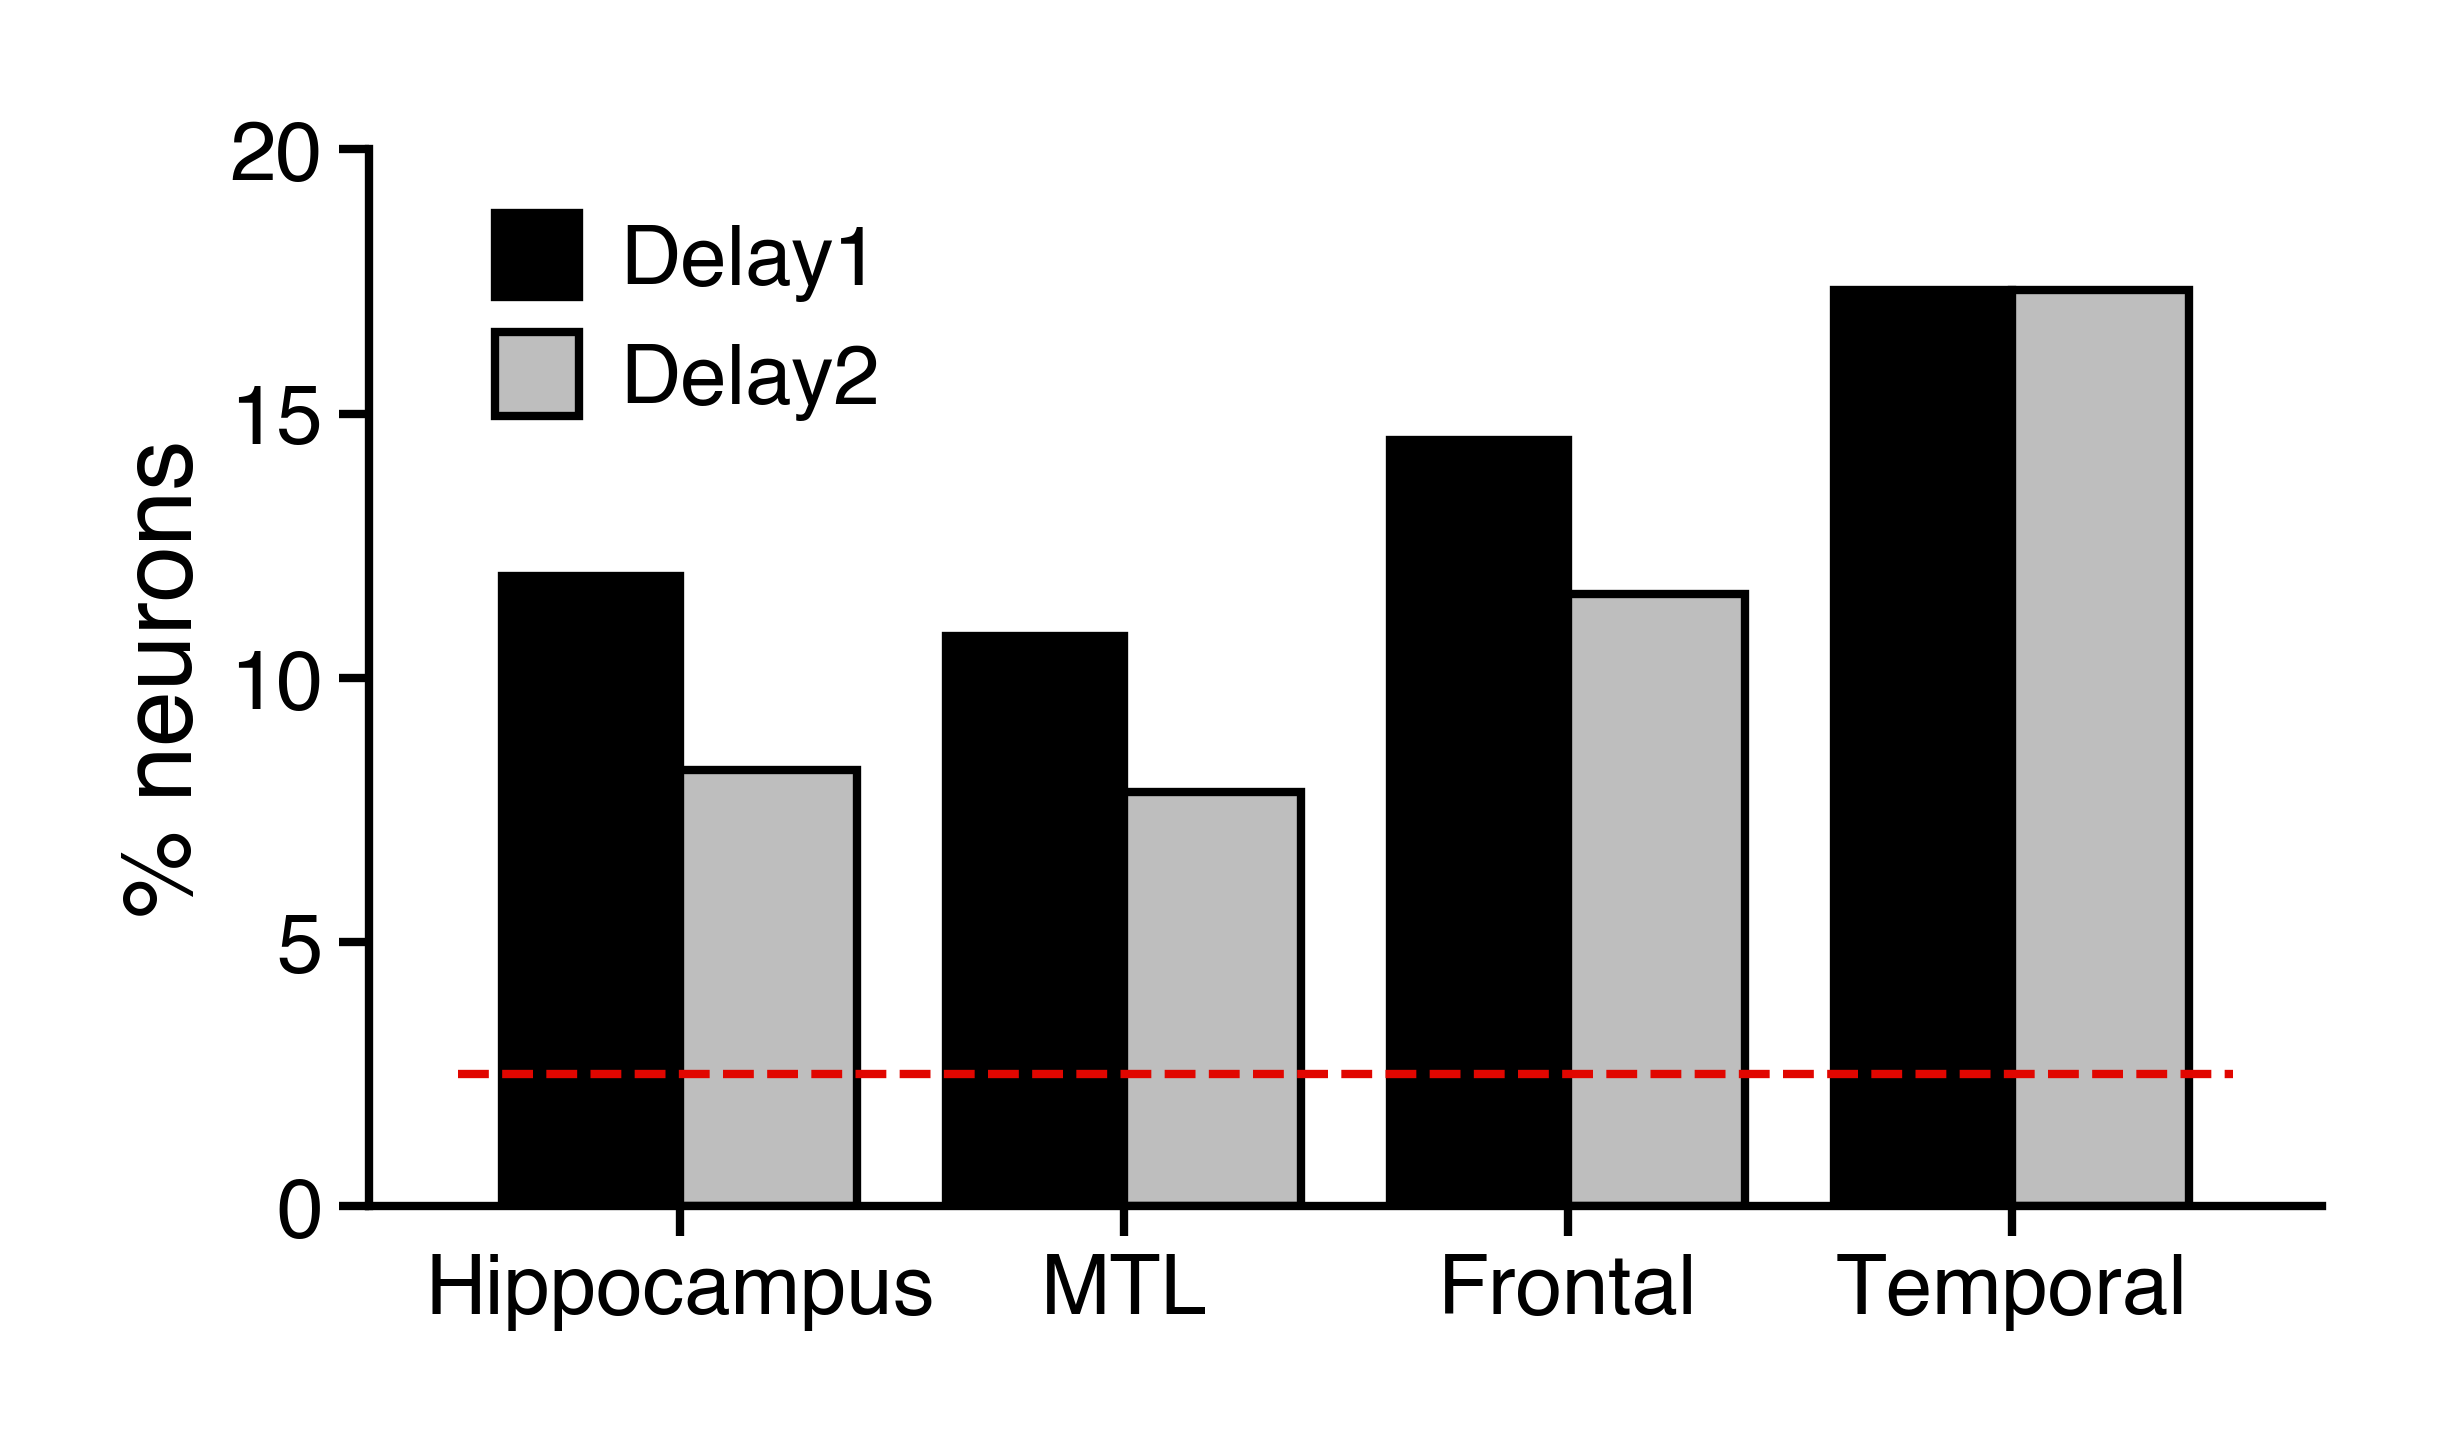

In [43]:
savefig = 0
overwrite = 0
sig_col = 'sig_pos'
xcats = ['Time', 'Place', 'Head\ndirec.', 'View\nbase', 'View\ngold']
ylim = [0, 20]
yticks = [0, 5, 10, 15, 20]
figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
font = {'tick': 5, 'label': 6, 'annot': 5}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)

# Graph percent of units that code for each variable of interest.
sig_pct = (ols_pairs.query("(gameState==['Delay1', 'Delay2']) & (testvar=='time')")
                    .groupby(['gameState', 'roi_gen5'], observed=True)
                    .agg({sig_col: [np.sum, 
                                    lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'roi', 'sum', 'pct']
sig_pct['gameState'] = sig_pct['gameState'].astype(str)

# Make the plot.
plt.close()
_cmap = ['k', cmap[0]]
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=1200)
ax = sns.barplot(x='roi', y='pct', hue='gameState', data=sig_pct, ax=ax,
                 palette=_cmap, linewidth=spine_lw, edgecolor='k')
ax.hlines(2.5, -0.5, 3.5, colors='#e10600', linestyles='dashed', lw=spine_lw)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(spine_lw)
ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
#ax.set_xticklabels(xcats, fontsize=font['tick'])
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad-1)

# ax2 = ax.twinx()
# ax2.spines['right'].set_visible(True)
# ax2.spines['right'].set_linewidth(spine_lw)
# for axis in ['left', 'bottom', 'top']:
#     ax2.spines[axis].set_visible(False)
# ax2.tick_params(labelsize=font['tick'], pad=1, length=1.5, width=spine_lw)
# slope, icpt, *_ = stats.linregress(sig_pct['pct'], sig_pct['sum'])
# ax2.set_ylim(icpt + (np.array(ylim) * slope))
# ax2.set_yticks(icpt + (np.array(yticks)*slope))
# ax2.set_yticklabels(np.rint(icpt + (np.array(yticks)*slope)).astype(int))
# ax2.set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)

ax.get_legend().remove()
custom_lines = [Line2D([0], [0], marker='s', color='w', label='Delay1', mfc='k', mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], marker='s', color='w', label='Delay2', mfc=cmap[0], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax.legend(handles=custom_lines, fontsize=font['annot'], bbox_to_anchor=(0.3, 1), handletextpad=0)

if savefig:
    n_units = np.unique(ols_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation',
                       'pct_sig-time_place_hd_gold_base-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

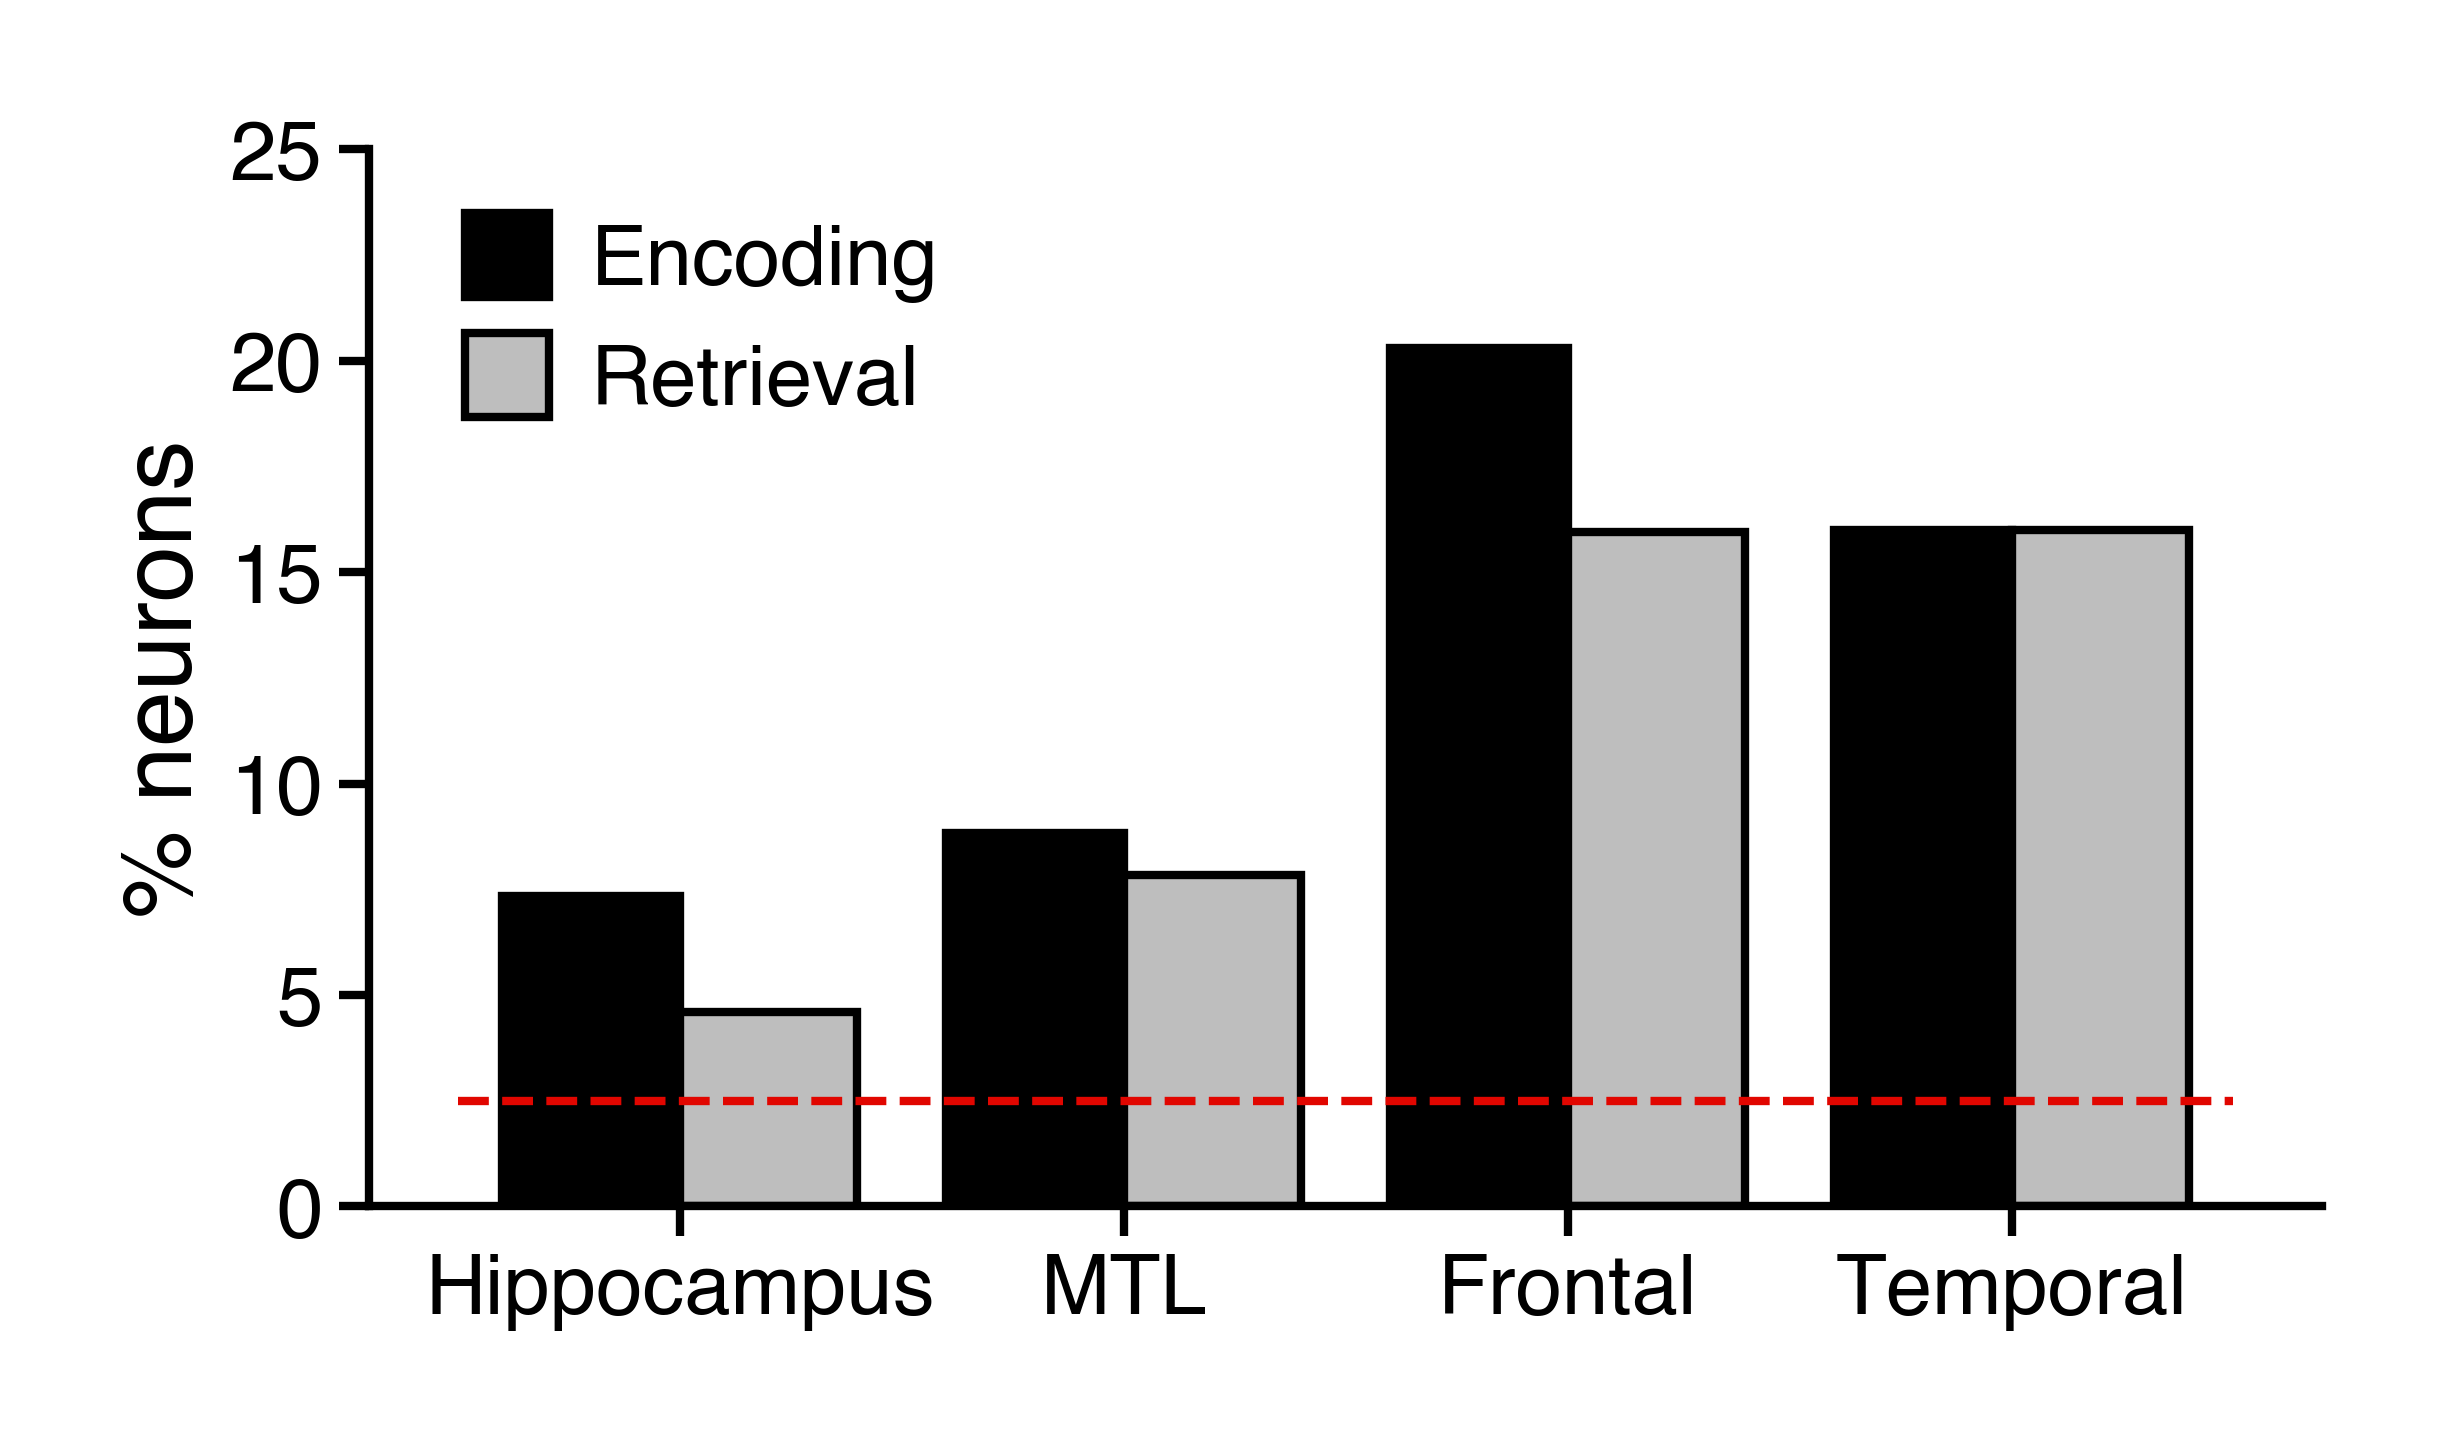

In [46]:
savefig = 0
overwrite = 0
sig_col = 'sig_pos'
xcats = ['Time', 'Place', 'Head\ndirec.', 'View\nbase', 'View\ngold']
ylim = [0, 25]
yticks = [0, 5, 10, 15, 20, 25]
figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
font = {'tick': 5, 'label': 6, 'annot': 5}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)

# Graph percent of units that code for each variable of interest.
sig_pct = (ols_pairs.query("(gameState==['Encoding', 'Retrieval']) & (testvar=='time')")
                    .groupby(['gameState', 'roi_gen5'], observed=True)
                    .agg({sig_col: [np.sum, 
                                    lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'roi', 'sum', 'pct']
sig_pct['gameState'] = sig_pct['gameState'].astype(str)

# Make the plot.
plt.close()
_cmap = ['k', cmap[0]]
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=1200)
ax = sns.barplot(x='roi', y='pct', hue='gameState', data=sig_pct, ax=ax,
                 palette=_cmap, linewidth=spine_lw, edgecolor='k')
ax.hlines(2.5, -0.5, 3.5, colors='#e10600', linestyles='dashed', lw=spine_lw)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(spine_lw)
ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
#ax.set_xticklabels(xcats, fontsize=font['tick'])
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad-1)

# ax2 = ax.twinx()
# ax2.spines['right'].set_visible(True)
# ax2.spines['right'].set_linewidth(spine_lw)
# for axis in ['left', 'bottom', 'top']:
#     ax2.spines[axis].set_visible(False)
# ax2.tick_params(labelsize=font['tick'], pad=1, length=1.5, width=spine_lw)
# slope, icpt, *_ = stats.linregress(sig_pct['pct'], sig_pct['sum'])
# ax2.set_ylim(icpt + (np.array(ylim) * slope))
# ax2.set_yticks(icpt + (np.array(yticks)*slope))
# ax2.set_yticklabels(np.rint(icpt + (np.array(yticks)*slope)).astype(int))
# ax2.set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)

ax.get_legend().remove()
custom_lines = [Line2D([0], [0], marker='s', color='w', label='Encoding', mfc='k', mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], marker='s', color='w', label='Retrieval', mfc=cmap[0], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax.legend(handles=custom_lines, fontsize=font['annot'], bbox_to_anchor=(0.33, 1), handletextpad=0)

if savefig:
    n_units = np.unique(ols_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation',
                       'pct_sig-time_place_hd_gold_base-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

In [47]:
# What variables are neurons behaviorally tuned to?
sig_col = 'sig_pos'

def _mean_sum(val):
    return r'{} ({:.1f}%)'.format(np.sum(val), np.round(100 * np.mean(val), 1))

df = ols_pairs.copy()
df['roi_gen5'] = df['roi_gen5'].astype(pd.CategoricalDtype(['Hippocampus', 'MTL', 'Temporal', 'Frontal'], ordered=True))
df.groupby(['gameState', 'testvar'], observed=True).agg({sig_col: _mean_sum}).reset_index()

gameState       testvar     sig_pos
0      Delay1          time  58 (12.7%)
1    Encoding          time  52 (11.4%)
2    Encoding         place  47 (10.3%)
3    Encoding    head_direc   30 (6.6%)
4    Encoding  base_in_view   23 (5.0%)
5    Encoding  gold_in_view  59 (12.9%)
6      Delay2          time  46 (10.1%)
7   Retrieval          time   44 (9.6%)
8   Retrieval         place  54 (11.8%)
9   Retrieval    head_direc   26 (5.7%)
10  Retrieval  base_in_view   12 (2.6%)

In [9]:
# What variables are neurons behaviorally tuned to?
sig_col = 'sig_pos'

def _mean_sum(val):
    return r'{} ({:.1f}%)'.format(np.sum(val), np.round(100 * np.mean(val), 1))

df = ols_pairs.copy()
df['roi_gen5'] = df['roi_gen5'].astype(pd.CategoricalDtype(['Hippocampus', 'MTL', 'Temporal', 'Frontal'], ordered=True))
pd.pivot(df.groupby(['gameState', 'testvar', 'roi_gen5'], observed=True).agg({sig_col: _mean_sum}).reset_index(),
         index=['gameState', 'testvar'],
         columns=['roi_gen5'],
         values=sig_col)

roi_gen5               Hippocampus         MTL    Temporal     Frontal
gameState testvar                                                     
Delay1    time          13 (11.9%)  22 (10.8%)  13 (17.3%)  10 (14.5%)
Encoding  time            8 (7.3%)   18 (8.8%)  12 (16.0%)  14 (20.3%)
          place          10 (9.2%)  22 (10.8%)    6 (8.0%)   9 (13.0%)
          head_direc      7 (6.4%)   11 (5.4%)  10 (13.3%)    2 (2.9%)
          base_in_view    5 (4.6%)   13 (6.4%)    3 (4.0%)    2 (2.9%)
          gold_in_view  14 (12.8%)  24 (11.8%)  10 (13.3%)  11 (15.9%)
Delay2    time            9 (8.3%)   16 (7.8%)  13 (17.3%)   8 (11.6%)
Retrieval time            5 (4.6%)   16 (7.8%)  12 (16.0%)  11 (15.9%)
          place         12 (11.0%)  22 (10.8%)  12 (16.0%)   8 (11.6%)
          head_direc      8 (7.3%)    9 (4.4%)    5 (6.7%)    4 (5.8%)
          base_in_view    3 (2.8%)    1 (0.5%)    3 (4.0%)    5 (7.2%)

In [67]:
# How strong are the significant units?
(ols_pairs.query("(full=='full') & (sig==True)")
          .groupby(['gameState', 'testvar'], observed=True)
          .agg({'neuron': len,
                'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x))}))

neuron       z_lr
gameState testvar                        
Delay1    time              73  3.4 ± 2.0
Delay2    time              63  3.6 ± 1.9
Encoding  time              88  3.6 ± 1.6
          place             71  3.2 ± 1.6
          head_direc        49  3.5 ± 1.7
          base_in_view      44  5.1 ± 2.8
          gold_in_view      88  5.0 ± 4.1
Retrieval time              80  3.1 ± 1.2
          place             84  3.1 ± 1.5
          head_direc        46  3.4 ± 1.9
          base_in_view      50  3.9 ± 2.6

In [71]:
# How strong are the significant units?
(ols_pairs.query("(full=='full') & (sig==True)")
          .groupby(['gameState', 'testvar', 'roi_gen5'], observed=True)
          .agg({'neuron': len,
                'z_lr': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x)),
                'fr_max_ind4': lambda x: '{:.1f} ± {:.1f}'.format(np.mean(x), np.std(x))}))

neuron       z_lr fr_max_ind4
gameState testvar      roi_gen5                                  
Delay1    time         Hippocampus      13  3.5 ± 2.1   1.1 ± 1.3
                       MTL              31  3.3 ± 1.5   0.9 ± 1.2
                       Frontal          12  3.4 ± 1.8   0.3 ± 0.6
                       Temporal         17  3.6 ± 2.8   0.9 ± 1.2
Delay2    time         Hippocampus      13  3.6 ± 2.0   1.2 ± 1.1
                       MTL              23  3.5 ± 1.3   1.2 ± 1.3
                       Frontal           9  3.2 ± 1.4   0.9 ± 1.3
                       Temporal         18  4.1 ± 2.6   0.6 ± 1.0
Encoding  time         Hippocampus      16  3.8 ± 1.9   1.5 ± 1.2
                       MTL              32  3.5 ± 1.2   1.5 ± 1.1
                       Frontal          24  3.0 ± 1.0   1.5 ± 1.2
                       Temporal         16  4.3 ± 2.3   0.9 ± 1.1
          place        Hippocampus      12  2.7 ± 0.8   1.7 ± 1.2
                       MTL              33  3.6 ± 2.0   1.5 ± 0.9
                       Frontal          13  3.1 ± 1.2   1.5 ± 1.4
                       Temporal         13  3.0 ± 1.2   1.2 ± 1.2
          head_direc   Hippocampus      12  3.7 ± 1.8   1.7 ± 1.1
                       MTL              17  3.9 ± 2.3   1.9 ± 0.9
                       Frontal           4  2.5 ± 0.7   1.0 ± 1.2
                       Temporal         16  3.1 ± 0.6   1.3 ± 1.3
          base_in_view Hippocampus       8  4.6 ± 2.2   1.2 ± 1.3
                       MTL              20  5.3 ± 3.4   1.9 ± 0.9
                       Frontal           3  6.0 ± 2.2   2.0 ± 1.4
                       Temporal         13  4.8 ± 2.3   1.7 ± 1.1
          gold_in_view Hippocampus      21  5.0 ± 4.3   1.3 ± 1.2
                       MTL              35  4.4 ± 2.2   1.8 ± 1.1
                       Frontal          15  5.8 ± 5.4   1.2 ± 1.2
                       Temporal         17  5.5 ± 5.0   1.5 ± 1.1
Retrieval time         Hippocampus      14  3.1 ± 1.3   1.8 ± 1.3
                       MTL              32  2.8 ± 0.9   1.7 ± 1.2
                       Frontal          14  3.2 ± 1.5   1.4 ± 1.4
                       Temporal         20  3.3 ± 1.0   1.6 ± 1.2
          place        Hippocampus      17  3.0 ± 1.0   1.5 ± 1.3
                       MTL              34  3.5 ± 2.1   1.3 ± 1.0
                       Frontal          10  2.4 ± 0.5   1.6 ± 1.2
                       Temporal         23  2.9 ± 0.8   1.4 ± 1.2
          head_direc   Hippocampus       9  2.8 ± 0.8   1.7 ± 1.5
                       MTL              20  3.5 ± 2.5   1.6 ± 1.2
                       Frontal           5  2.9 ± 0.9   2.2 ± 1.2
                       Temporal         12  3.8 ± 1.5   1.5 ± 1.0
          base_in_view Hippocampus      11  4.3 ± 1.7   1.9 ± 1.3
                       MTL              21  4.1 ± 3.5   2.0 ± 1.1
                       Frontal          10  3.4 ± 1.1   1.9 ± 1.4
                       Temporal          8  3.5 ± 1.6   1.9 ± 1.2

In [31]:
ols_pairs['testvar'].unique()

['time', 'place', 'head_direc', 'base_in_view', 'gold_in_view']
Categories (5, object): ['time' < 'place' < 'head_direc' < 'base_in_view' < 'gold_in_view']

In [40]:
sig_pct['gameState'].unique()

['Encoding', 'Retrieval']
Categories (2, object): ['Encoding' < 'Retrieval']

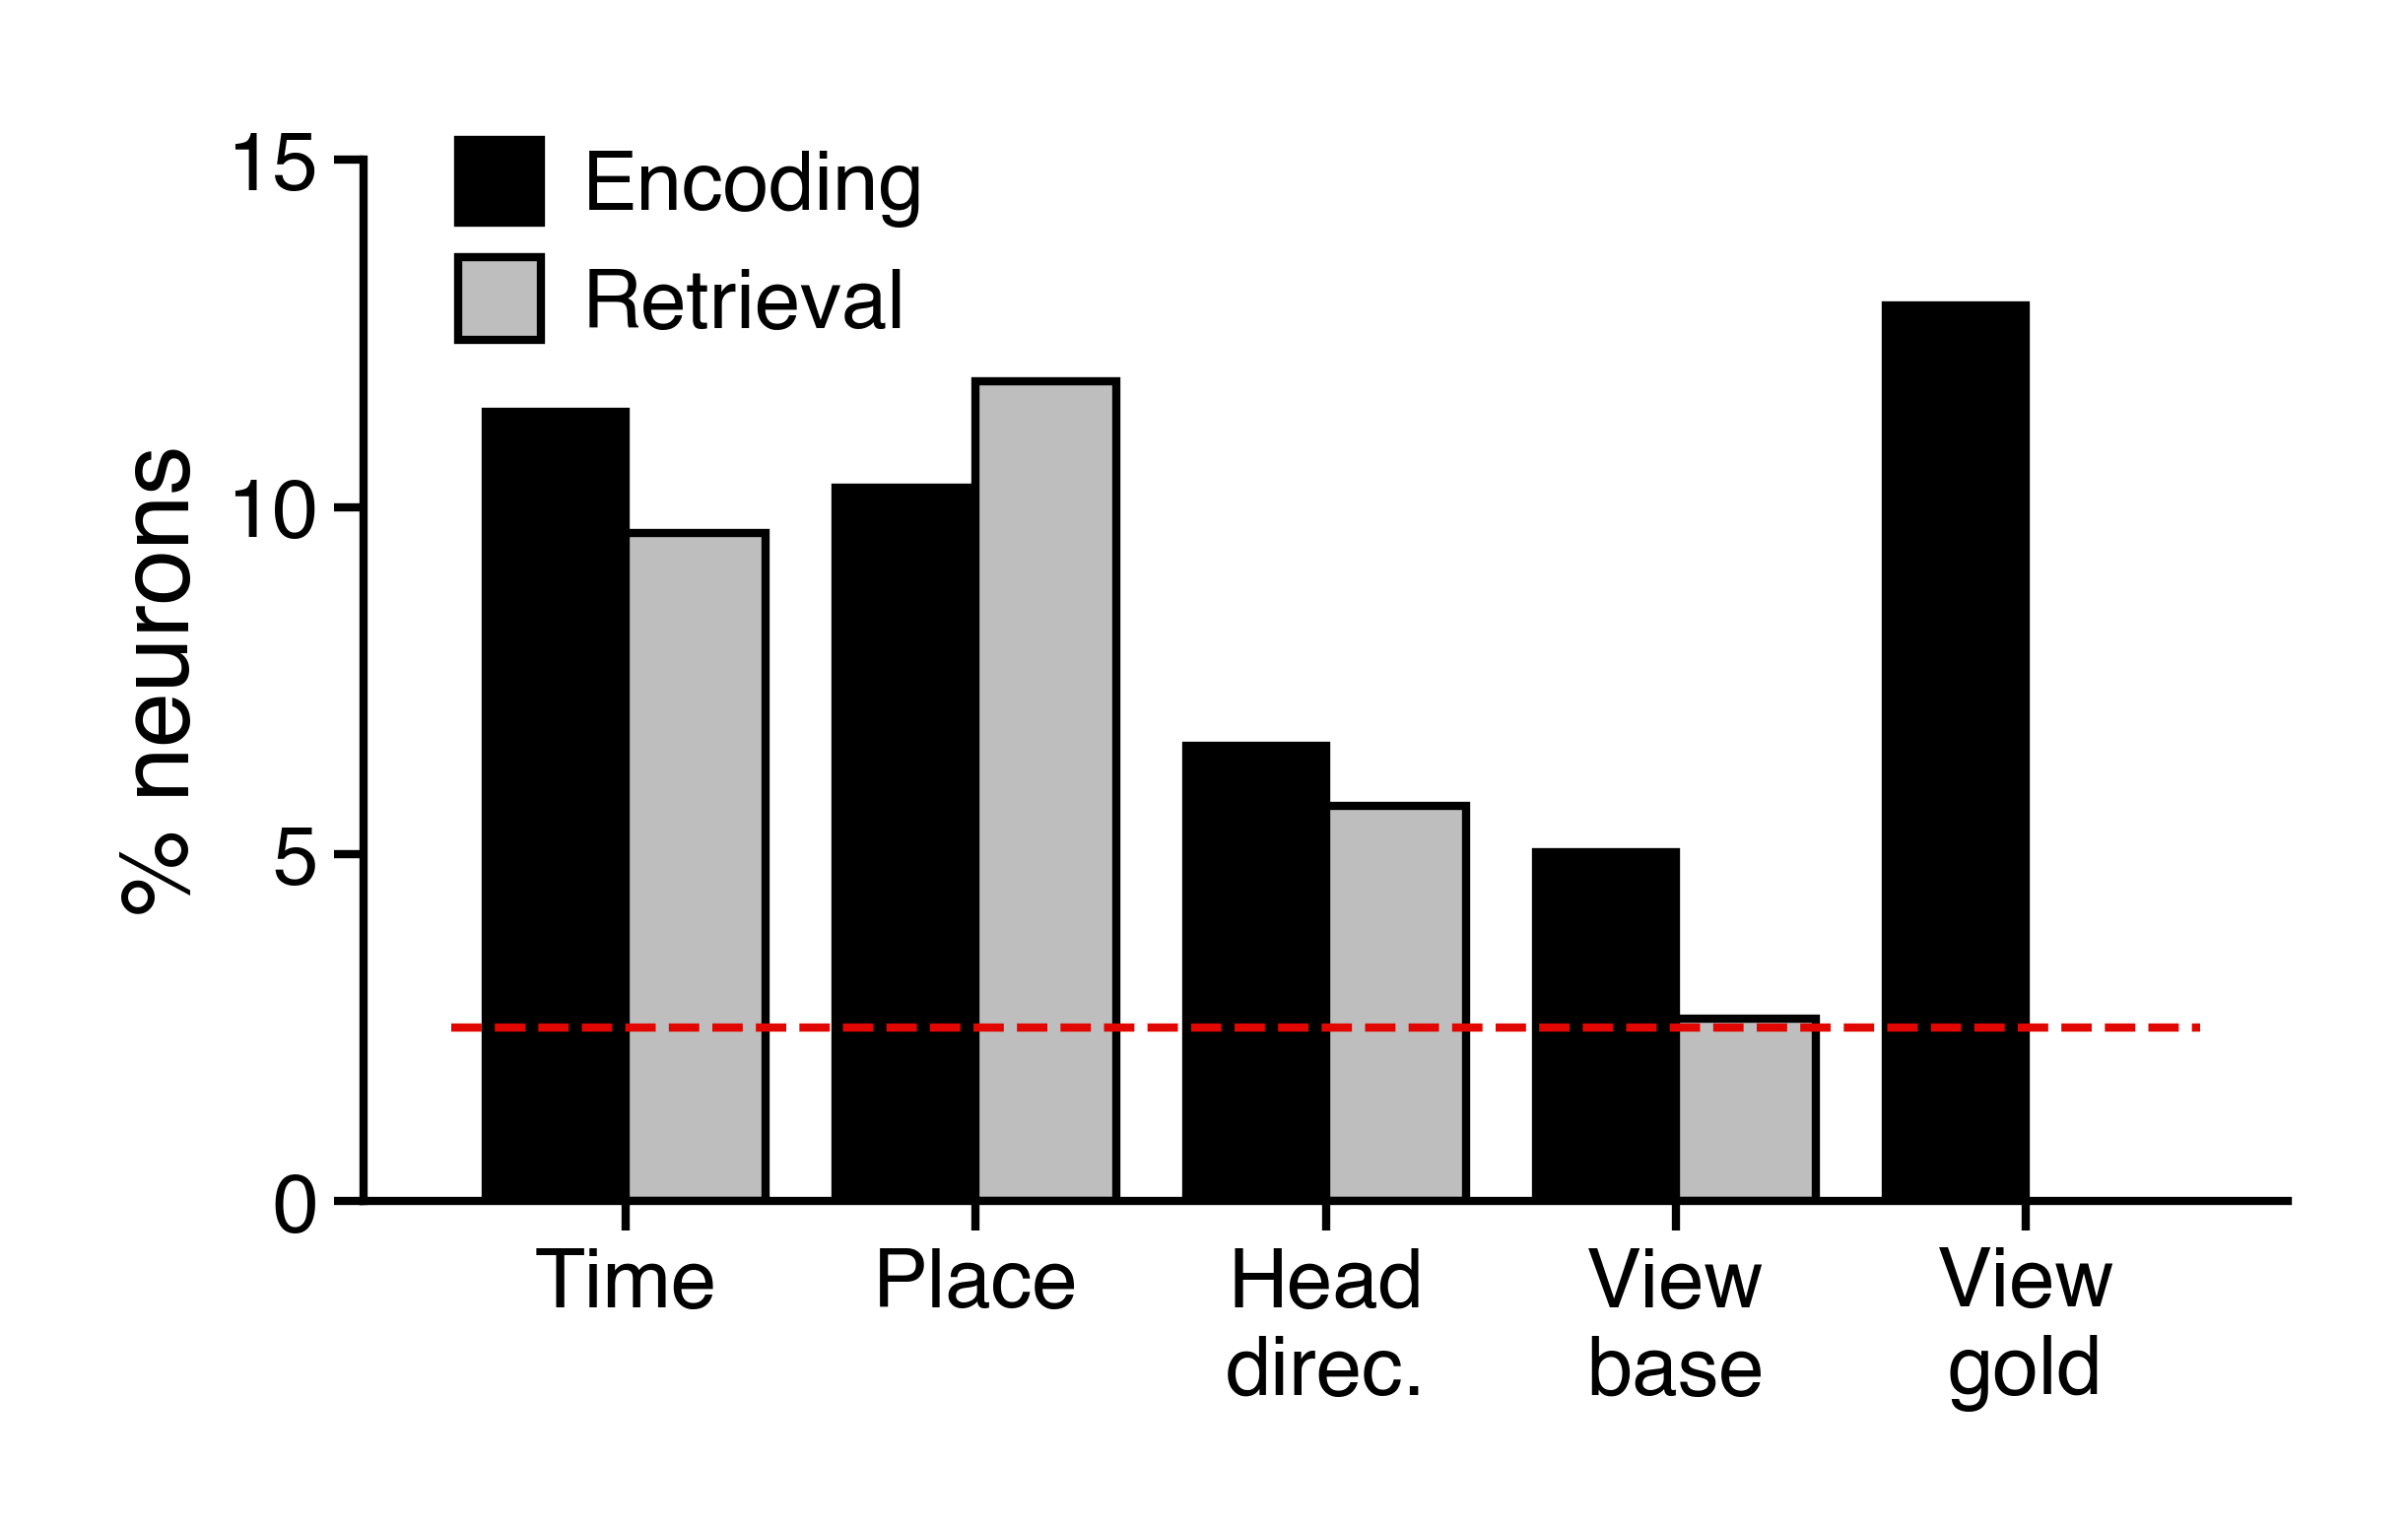

In [52]:
savefig = 0
overwrite = 0
sig_col = 'sig_pos'
test_vars = ['time', 'place', 'head_direc', 'base_in_view', 'gold_in_view']
xcats = ['Time', 'Place', 'Head\ndirec.', 'View\nbase', 'View\ngold']
ylim = [0, 15]
yticks = [0, 5, 10, 15]
figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
font = {'tick': 5, 'label': 6, 'annot': 5}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)

# Graph percent of units that code for each variable of interest.
sig_pct = (ols_pairs.query("(gameState==['Encoding', 'Retrieval']) & (testvar=={})".format(test_vars))
                    .groupby(['gameState', 'testvar'], observed=True)
                    .agg({sig_col: [np.sum, 
                                    lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'testvar', 'sum', 'pct']
sig_pct['gameState'] = sig_pct['gameState'].astype(str)

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=1200)
ax = sns.barplot(x='testvar', y='pct', hue='gameState', data=sig_pct, ax=ax,
                 palette=['k', cmap[0]], saturation=1, linewidth=spine_lw, edgecolor='k')
ax.hlines(2.5, -0.5, 4.5, colors='#e10600', linestyles='dashed', lw=spine_lw)
for axis in ['left', 'bottom']:
    ax.spines[axis].set_linewidth(spine_lw)
ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax.set_xticklabels(xcats, fontsize=font['tick'])
ax.set_ylim(ylim)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)
ax.set_xlabel('', fontsize=font['label'], labelpad=labelpad)
ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad-1)

# ax2 = ax.twinx()
# ax2.spines['right'].set_visible(True)
# ax2.spines['right'].set_linewidth(spine_lw)
# for axis in ['left', 'bottom', 'top']:
#     ax2.spines[axis].set_visible(False)
# ax2.tick_params(labelsize=font['tick'], pad=1, length=1.5, width=spine_lw)
# slope, icpt, *_ = stats.linregress(sig_pct['pct'], sig_pct['sum'])
# ax2.set_ylim(icpt + (np.array(ylim) * slope))
# ax2.set_yticks(icpt + (np.array(yticks)*slope))
# ax2.set_yticklabels(np.rint(icpt + (np.array(yticks)*slope)).astype(int))
# ax2.set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)

ax.get_legend().remove()
custom_lines = [Line2D([0], [0], marker='s', color='w', label='Encoding', mfc='k', mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], marker='s', color='w', label='Retrieval', mfc=cmap[0], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax.legend(handles=custom_lines, fontsize=font['annot'], bbox_to_anchor=(0.33, 1.08), handletextpad=0)

if savefig:
    n_units = np.unique(ols_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation',
                       'pct_sig-time_place_hd_gold_base-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

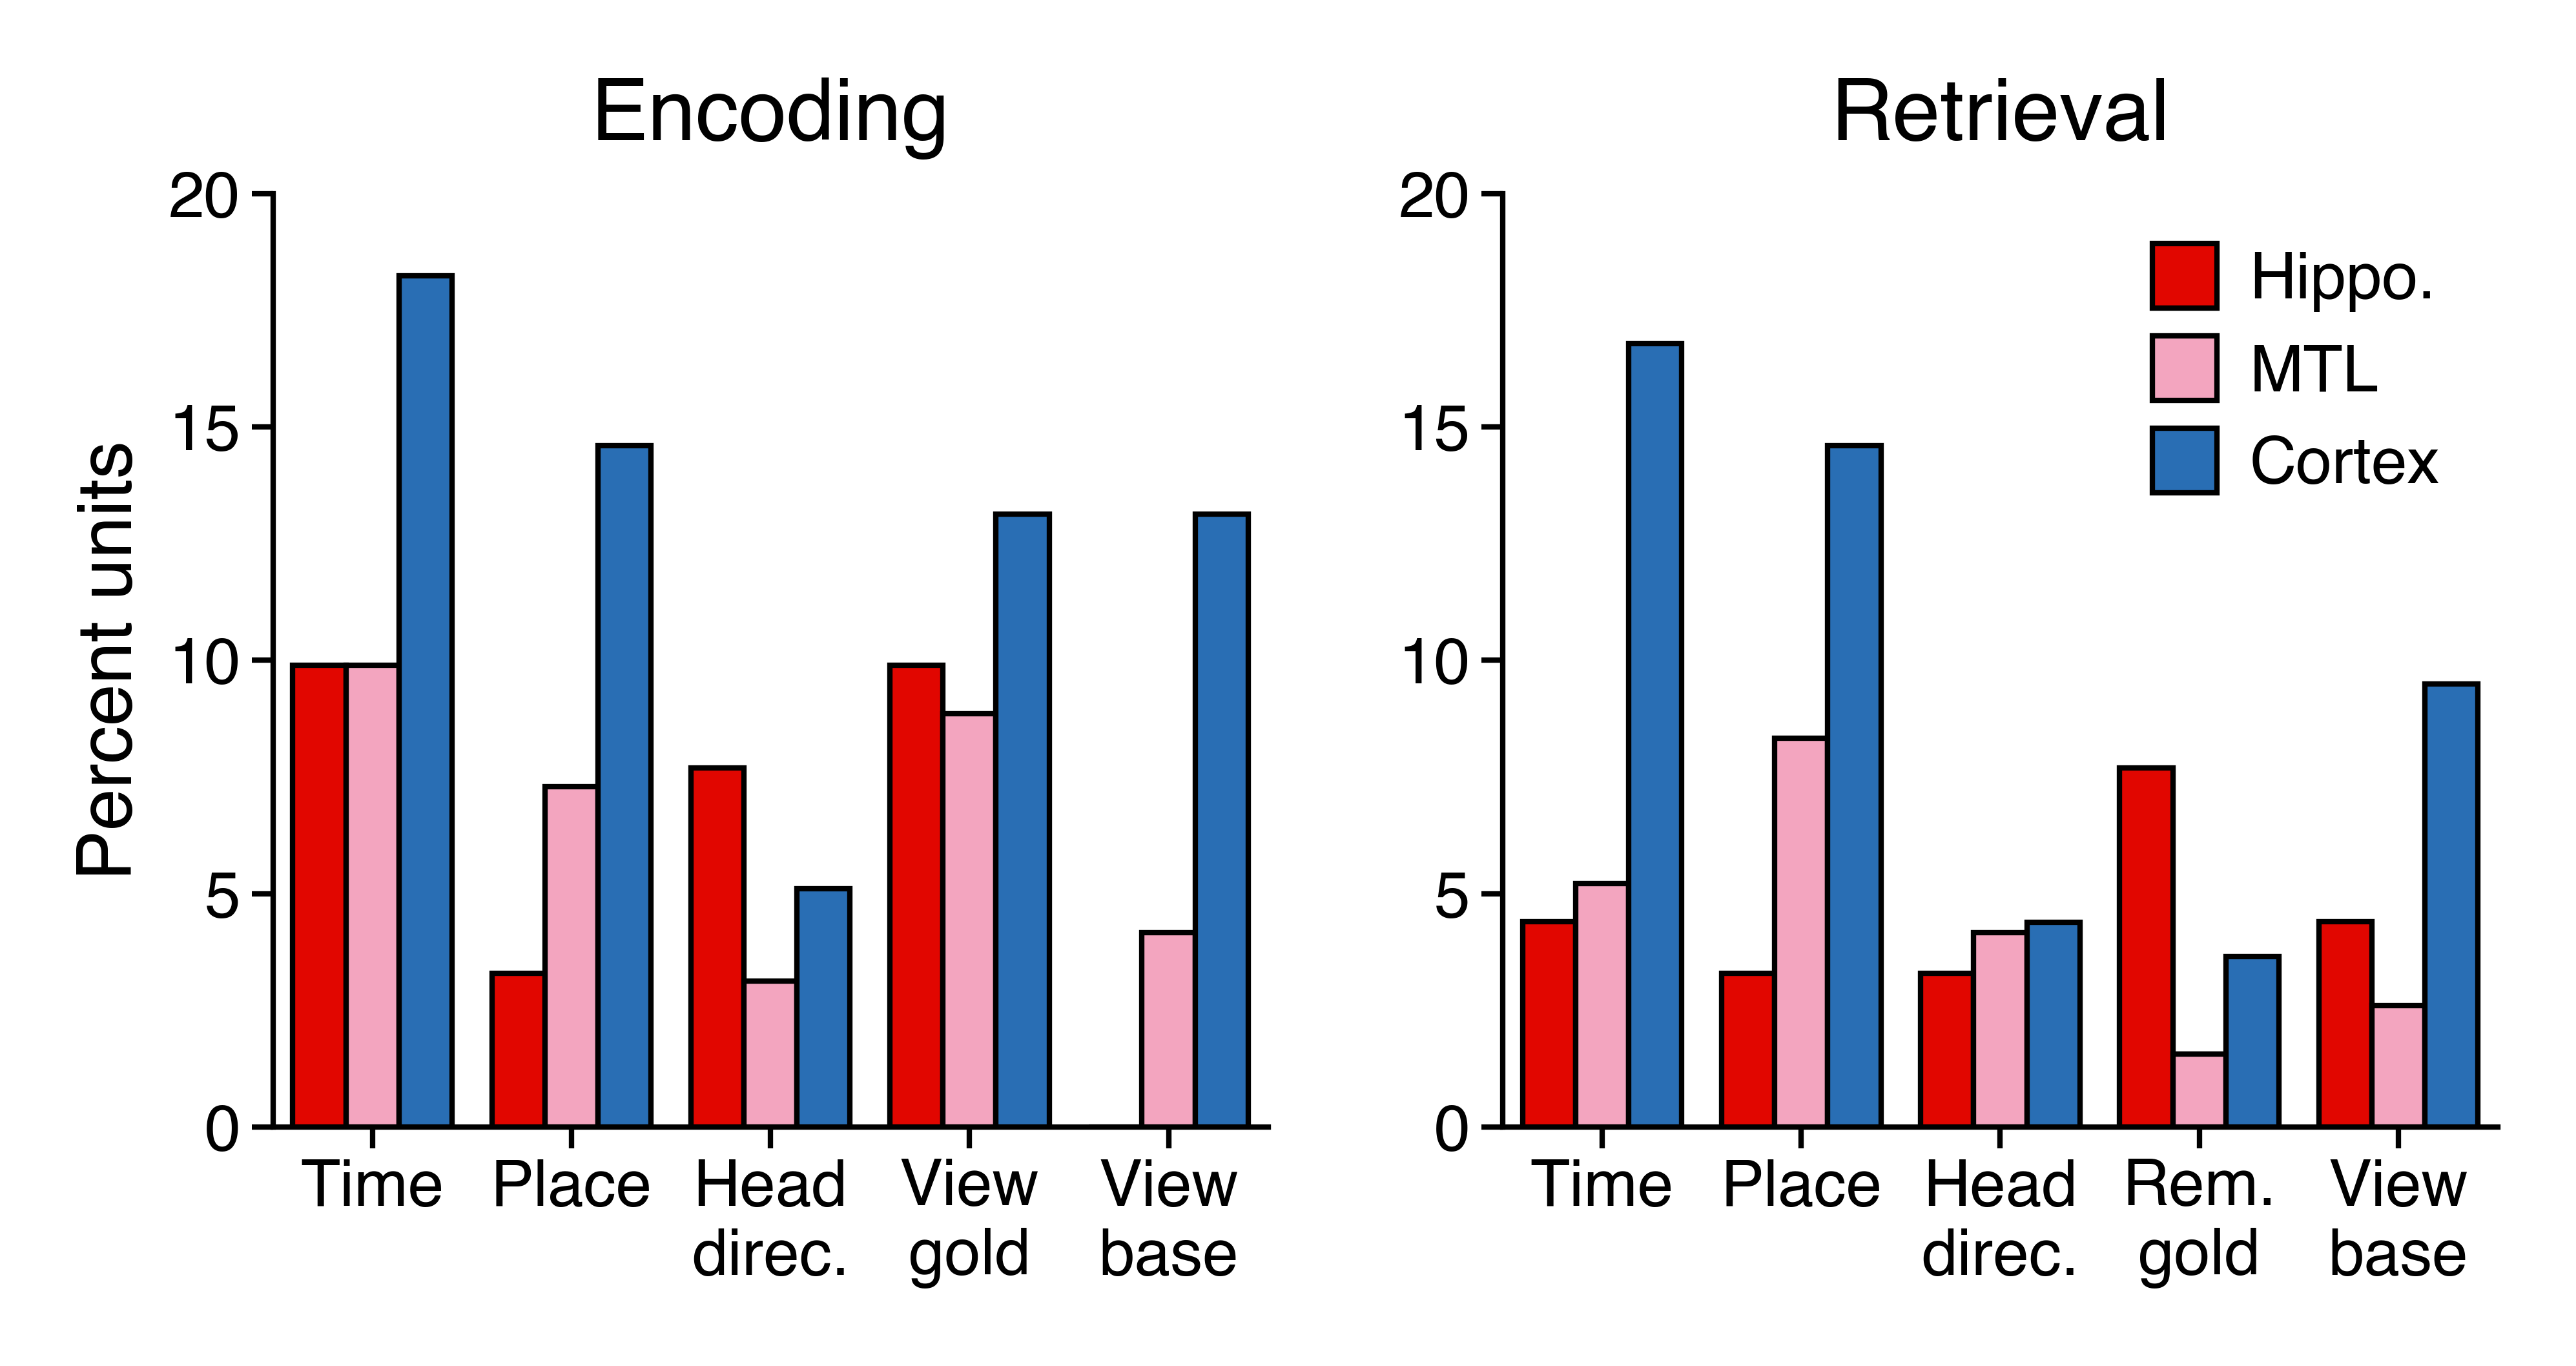

In [29]:
savefig = 0
overwrite = 0

# Graph percent of units that code for each variable of interest.
sig_pct = (ols_pairs.query("(full=='full')")
                    .groupby(['gameState', 'roi_gen', 'testvar'])
                    .agg({'sig_holm': [np.sum, 
                                       lambda x: 100 * np.mean(x)]}).reset_index())
sig_pct.columns = ['gameState', 'roi_gen', 'testvar', 'sum', 'pct']
roi_cats = ['Hippocampus', 'MTL', 'Cortex']
sig_pct['roi_gen'] = sig_pct['roi_gen'].astype(pd.CategoricalDtype(roi_cats, ordered=True))
sig_pct = sig_pct.sort_values(['gameState', 'roi_gen', 'testvar']).reset_index(drop=True)

# Plot params.
xcats = {'Encoding': ['Time', 'Place', 'Head\ndirec.', 'View\ngold', 'View\nbase'],
         'Retrieval': ['Time', 'Place', 'Head\ndirec.', 'Rem.\ngold', 'View\nbase']}
ylim = [0, 20]
yticks = [0, 5, 10, 15, 20]
# figsize = (colws['2-1/3'], colws['2-1/3']/1.8)
figsize = (colws[2], colws[2] * 0.5)
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5
cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[3], cmap[2]]

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=1200)
ax = np.ravel(ax)

for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    _df = sig_pct.query("(gameState=='{}')".format(game_state))
    ax[iax] = sns.barplot(x='testvar', y='pct', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                          palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
#     ax[iax].hlines(1, -0.5, 4.5, colors='#bebebe', linestyles='dashed', lw=spine_lw)
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].tick_params(labelsize=font['tick'], length=ticklength, pad=tickpad, width=spine_lw)
    ax[iax].set_xticklabels(xcats[game_state], fontsize=font['tick'])
    ax[iax].set_ylim(ylim)
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks)
    ax[iax].set_xlabel('', fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Percent units', fontsize=font['label'], labelpad=labelpad-1)
    else:
        ax[iax].set_ylabel('')
    ax[iax].get_legend().remove()
    ax[iax].set_title(game_state, fontsize=font['fig'], pad=figurepad)

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=1.2, rect=[0, 0, 1, 1])

if savefig:
    n_units = np.unique(ols_pairs['subj_sess_unit']).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation',
                       'pct_sig-time_place_hd_gold_base-by_region-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
            
fig.show()

In [77]:
roi_gen = 'roi_gen5'
fr_max_ind = 'fr_max_ind10'

game_states = ['Encoding', 'Retrieval']
units_per_region = ols_pairs[['subj_sess_unit', roi_gen]].drop_duplicates().groupby(roi_gen).size()
_ols_pairs = ols_pairs.query("(testvar=='time') & (full=='full') & (sig==True) & (gameState=={})".format(game_states)).copy()

_ols_pairs['peak_fr_ind'] = _ols_pairs[fr_max_ind]
peak_fr_counts = _ols_pairs.groupby(['gameState', roi_gen, 'peak_fr_ind']).size().reset_index().rename(columns={'peak_fr_ind': 'time', 0: 'count'})

_counts = peak_fr_counts.groupby(['gameState', roi_gen])['count'].apply(np.sum).to_dict()
peak_fr_counts['prop_sig'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / _counts[(x['gameState'], x[roi_gen])]), axis=1)
peak_fr_counts['prop_all'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / units_per_region[x[roi_gen]]), axis=1)

roi_cats = ['Hippocampus', 'MTL', 'Frontal', 'Temporal']
peak_fr_counts[roi_gen] = peak_fr_counts[roi_gen].astype(pd.CategoricalDtype(roi_cats, ordered=True))
peak_fr_counts = peak_fr_counts.sort_values(['gameState', roi_gen, 'time']).reset_index(drop=True)

In [78]:
peak_fr_counts.groupby(['gameState', roi_gen]).agg({'count': np.sum, 'prop_sig': np.sum, 'prop_all': np.sum})

count  prop_sig   prop_all
gameState roi_gen5                               
Encoding  Hippocampus     16     100.0  14.678899
          MTL             32     100.0  15.686275
          Frontal         24     100.0  34.782609
          Temporal        16     100.0  21.333333
Retrieval Hippocampus     14     100.0  12.844037
          MTL             32     100.0  15.686275
          Frontal         14     100.0  20.289855
          Temporal        20     100.0  26.666667

In [16]:
peak_fr_counts.groupby(['gameState', 'roi_gen']).agg({'count': np.sum, 'prop_sig': np.sum, 'prop_all': np.sum})

count  prop_sig   prop_all
gameState roi_gen                                
Encoding  Hippocampus      9     100.0   9.890110
          MTL             19     100.0   9.895833
          Cortex          25     100.0  18.248175
Retrieval Hippocampus      4     100.0   4.395604
          MTL             10     100.0   5.208333
          Cortex          23     100.0  16.788321

IndexError: list index out of range

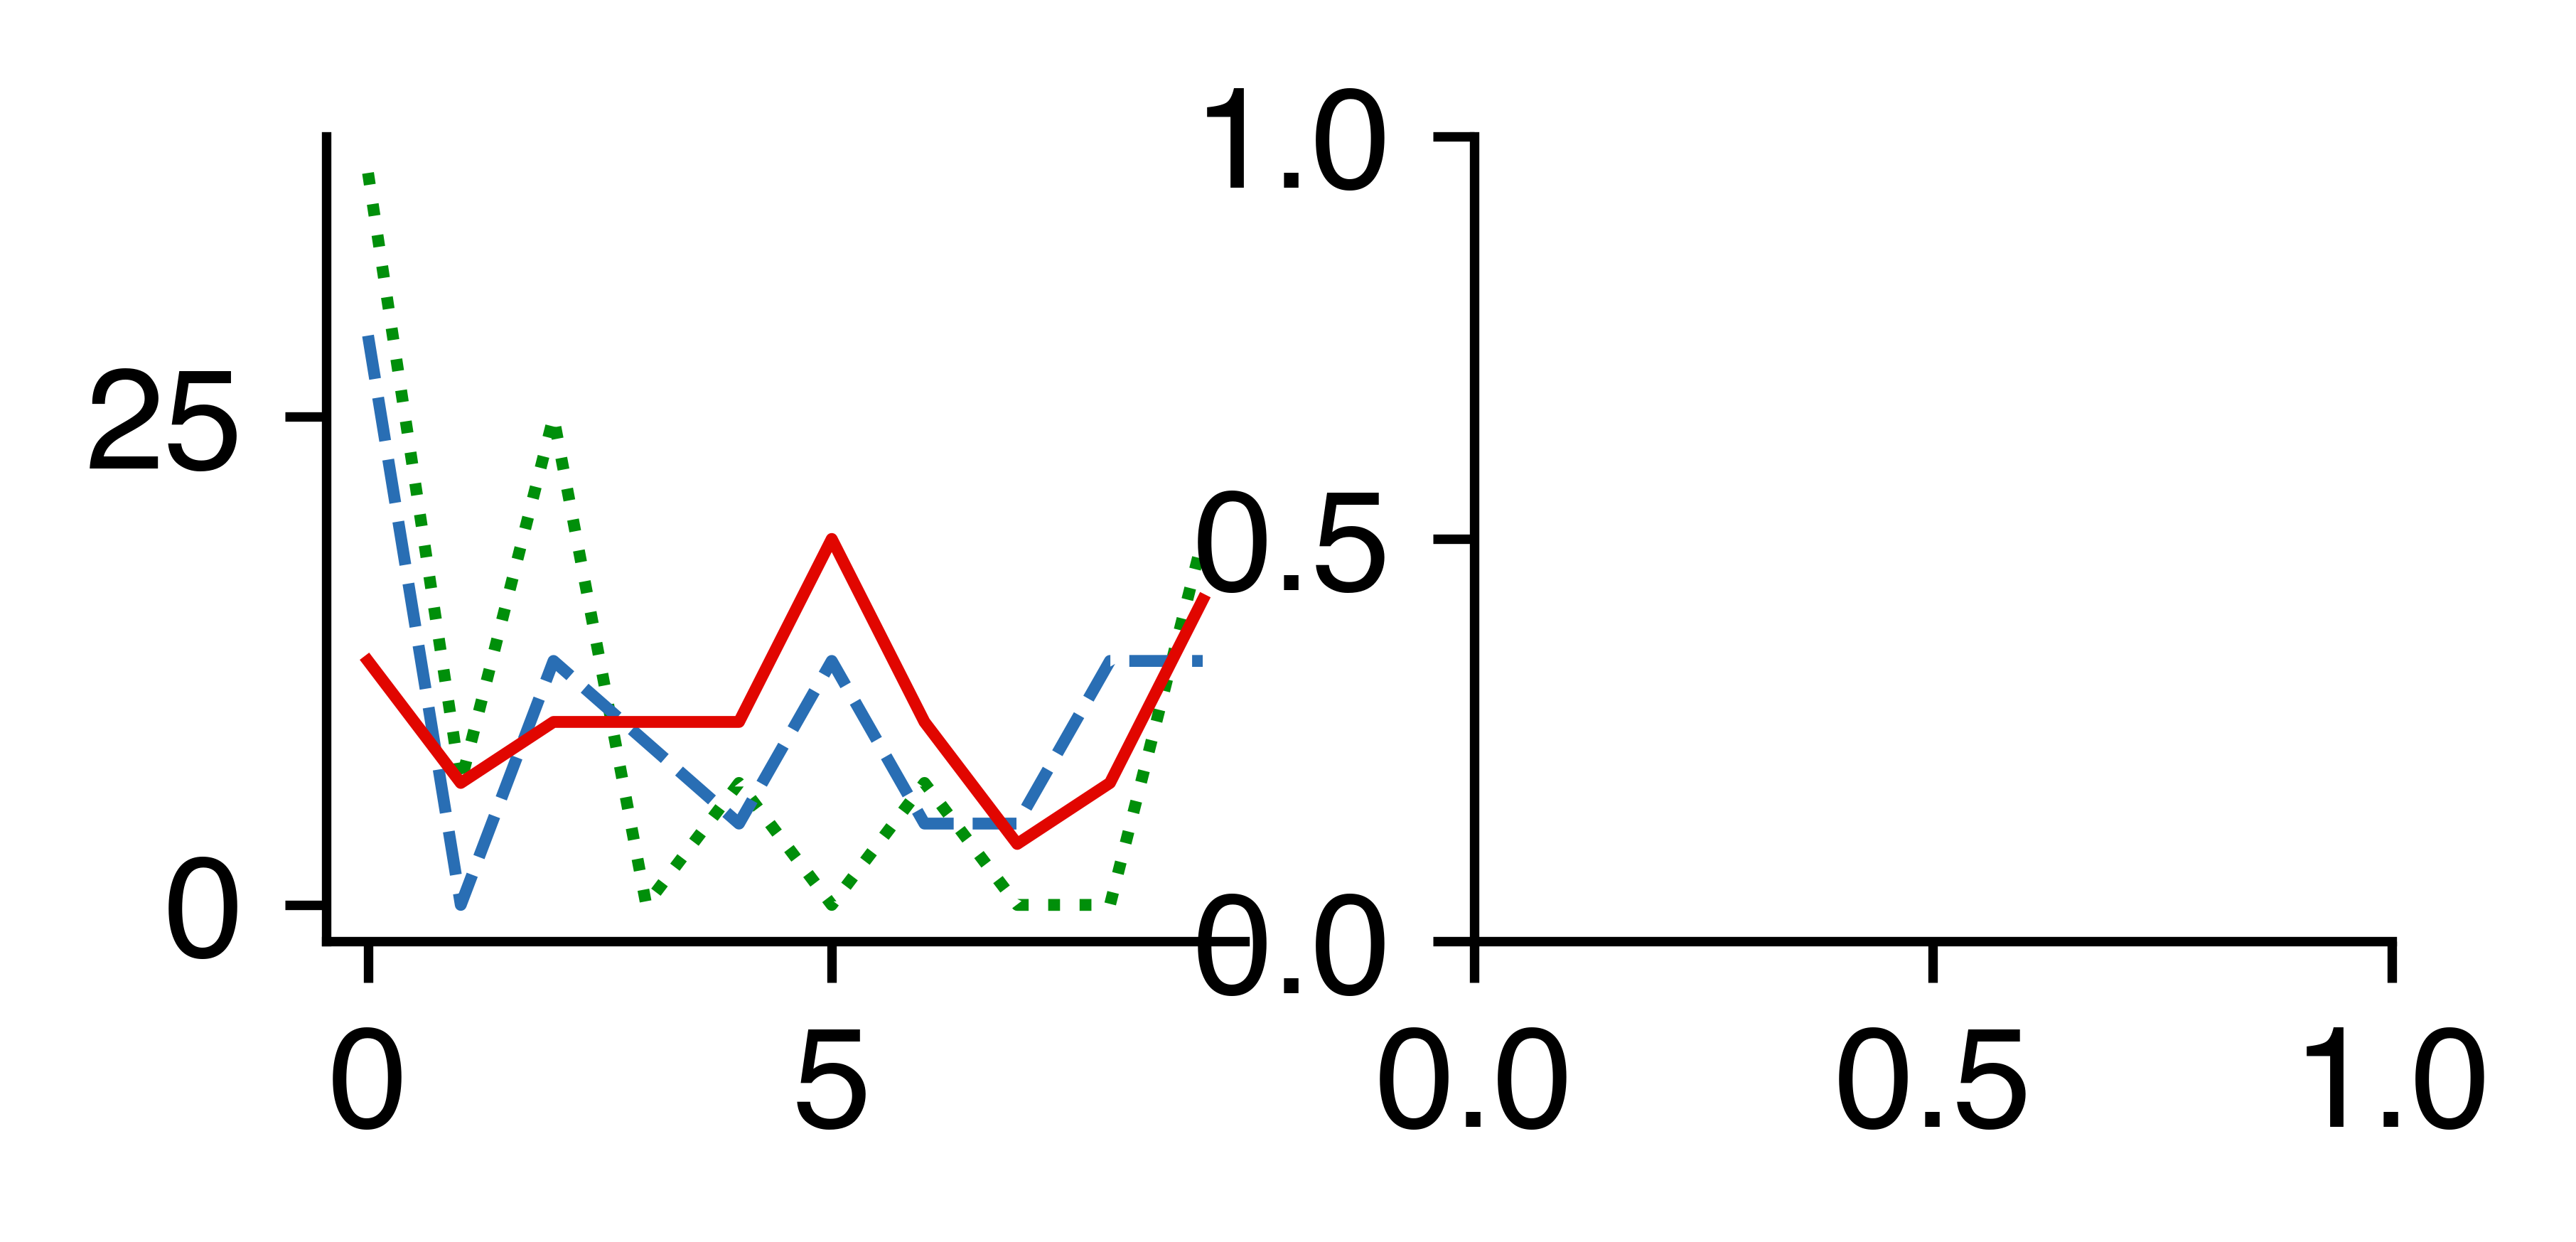

In [85]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.4)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
lw = 1
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

rois = ['Temporal', 'Frontal', 'MTL', 'Hippocampus']
linestyles = ['dotted', '--', '-']

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

# cmap = {0: (190, 190, 190), # gray
#         1: (225, 6, 0), # red
#         2: (41, 110, 180), # blue
#         3: (243, 165, 191)} # pink
# for k in cmap:
#     cmap[k] = list(np.array(cmap[k])/255)
# _cmap = [cmap[1], cmap[3], cmap[2]]

_cmap = ['#008f0a', '#296eb4', '#e10600', 'k']
    
for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
#     ax[iax] = sns.barplot(x='time', y='prop_all', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
#                         palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    for iRoi, roi in enumerate(rois):
        xvals = np.arange(10)
        yvals = []
        for xval in xvals:
            yvals.append(peak_fr_counts.query("(gameState=='{}') & ({}=='{}')".format(game_state, roi_gen, roi)).set_index('time')['prop_all'].get(xval, 0))
        xvals = np.array(xvals)
        ax[iax].plot(xvals, yvals, color=_cmap[iRoi], lw=lw, linestyle=linestyles[iRoi])
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    if fr_max_col == 'fr_max_ind10':
        ax[iax].set_xlim([-0.5, 9.5])
        ax[iax].set_xticks(np.arange(11)-0.5)
        ax[iax].set_xticklabels(np.arange(0, 33, 3), fontsize=font['tick'])
    elif fr_max_col == 'fr_max_ind5':
        ax[iax].set_xlim([0, 4])
        ax[iax].set_xticks(np.arange(5))
        ax[iax].set_xticklabels(['0-6', '6-12', '12-18', '18-24', '24-30'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 12])
    yticks = [0, 4, 8, 12]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('{} time (s)'.format(game_state), fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Pct. neurons', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
#     ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
#     ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=0.5, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_nav', 'navigation_time_cell_peak_firing_time_percents_by_region_all.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

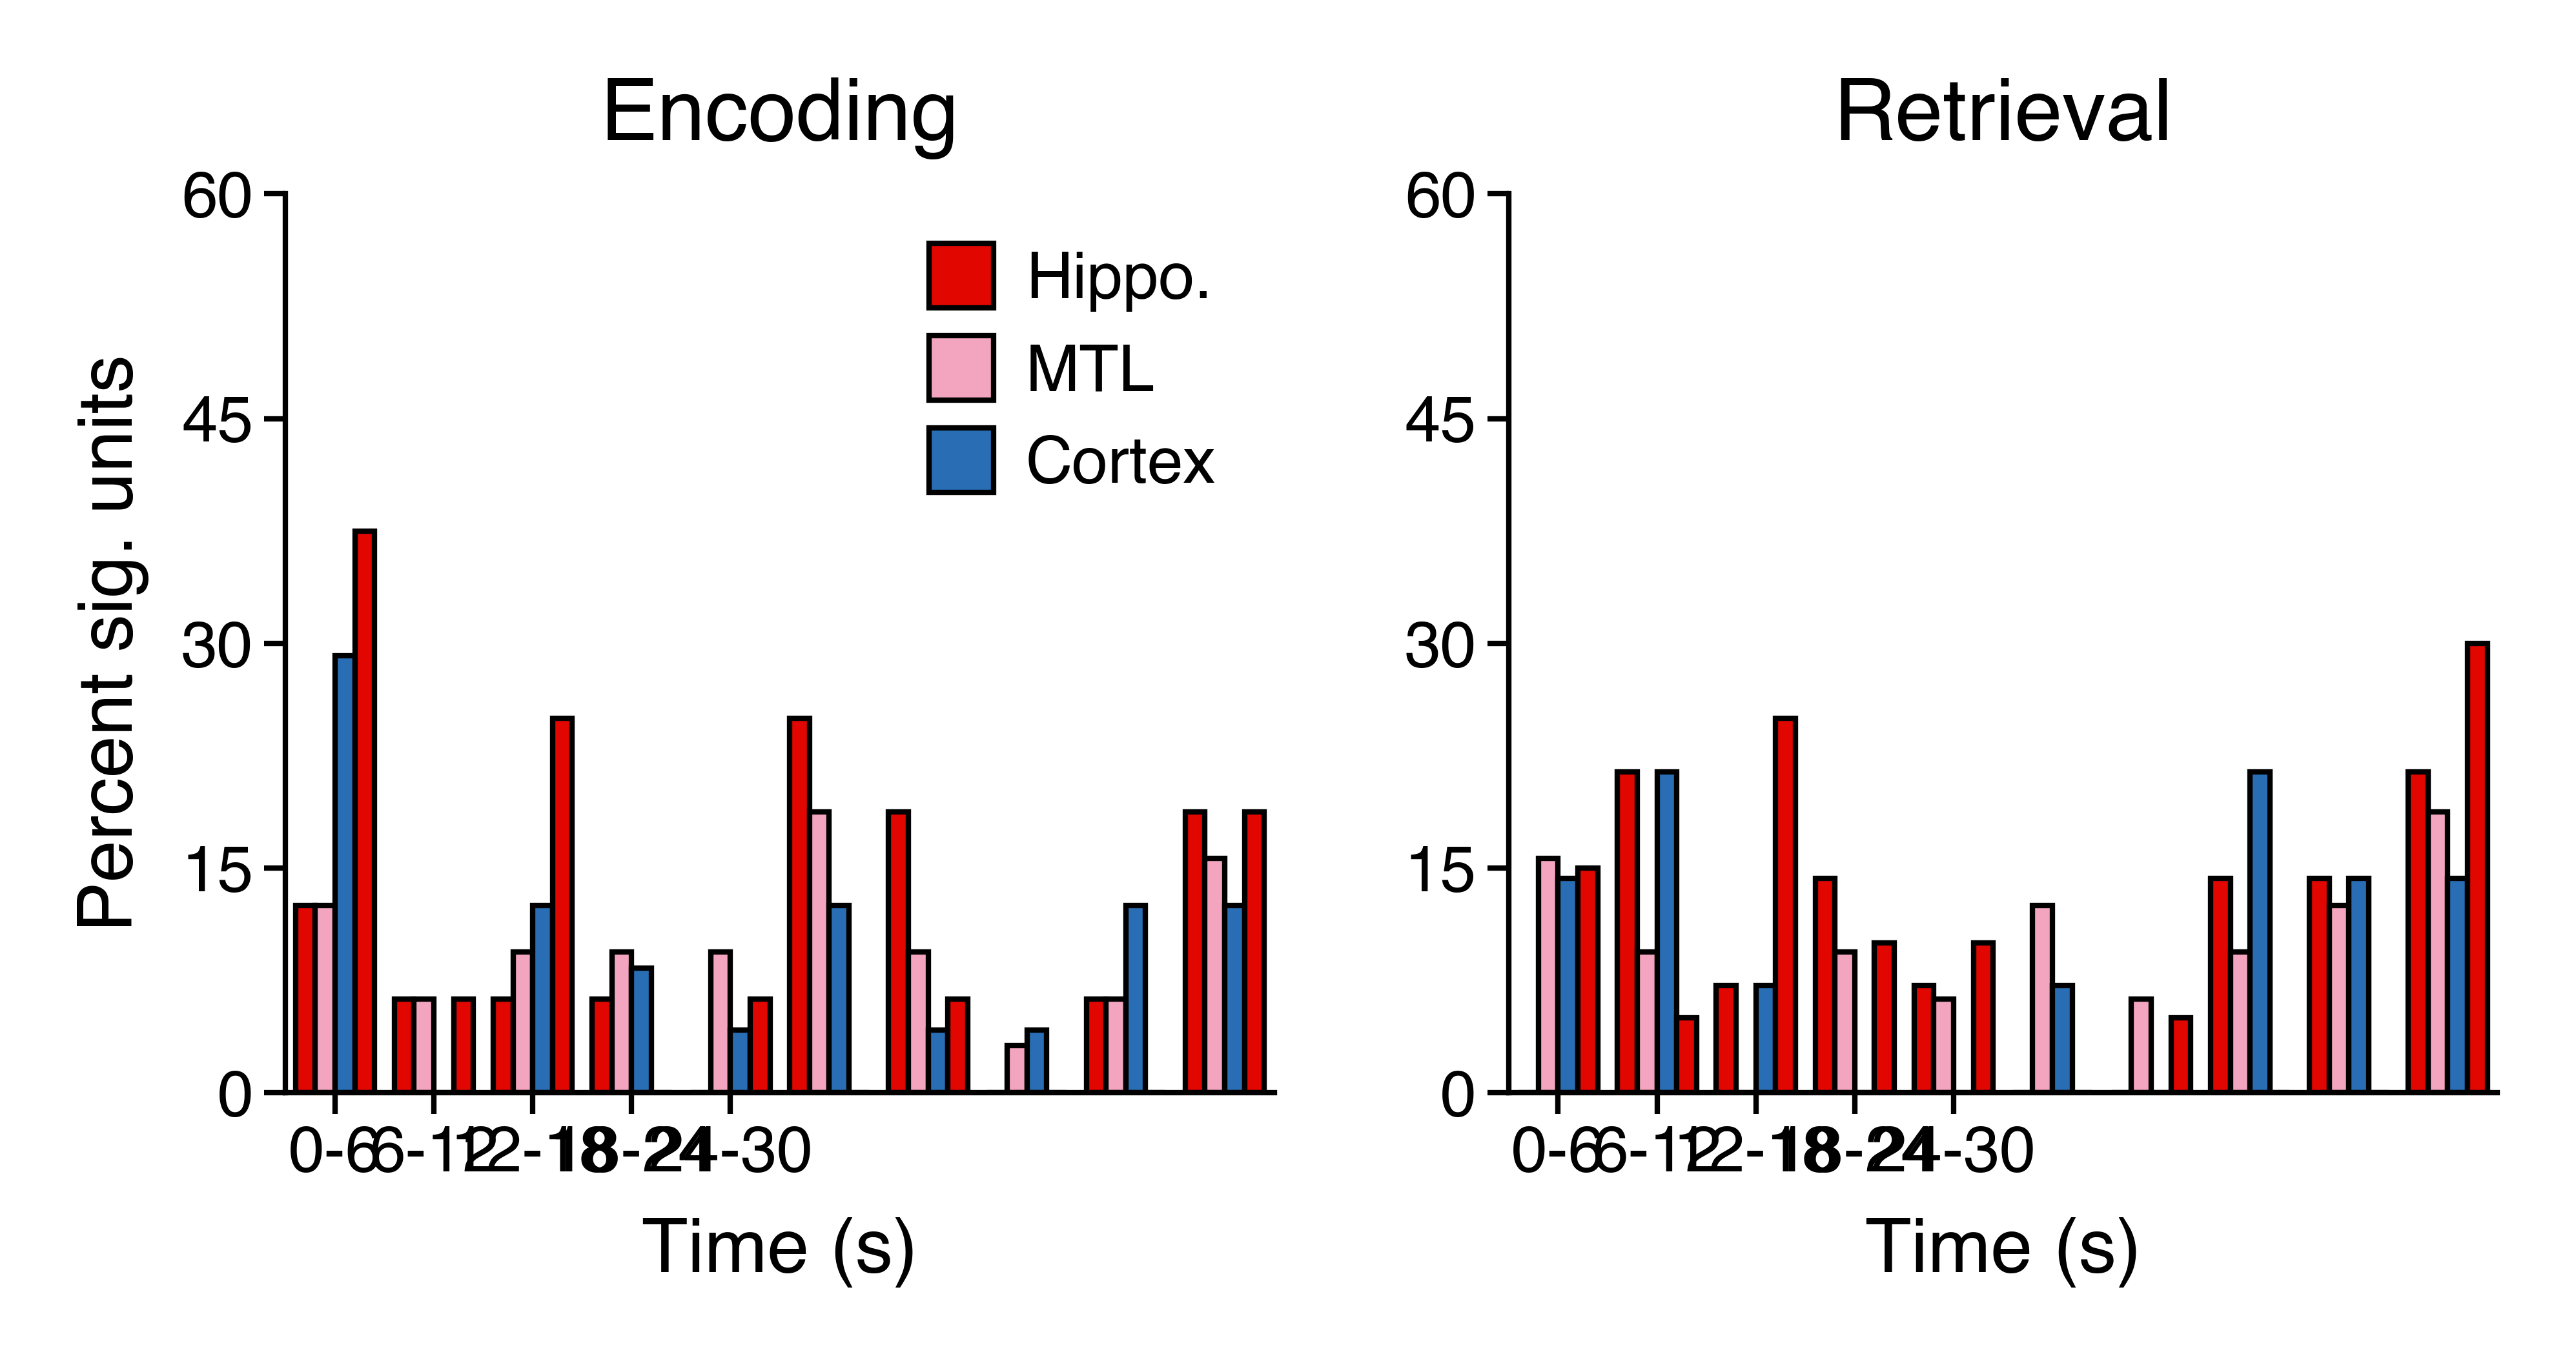

In [84]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[3], cmap[2]]
    
for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='prop_sig', hue=roi_gen, data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-6', '6-12', '12-18', '18-24', '24-30'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 60])
    yticks = [0, 15, 30, 45, 60]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Percent sig. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
    ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=1.2, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_navigation', 'navigation_time_cell_peak_firing_time_percents_by_region.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

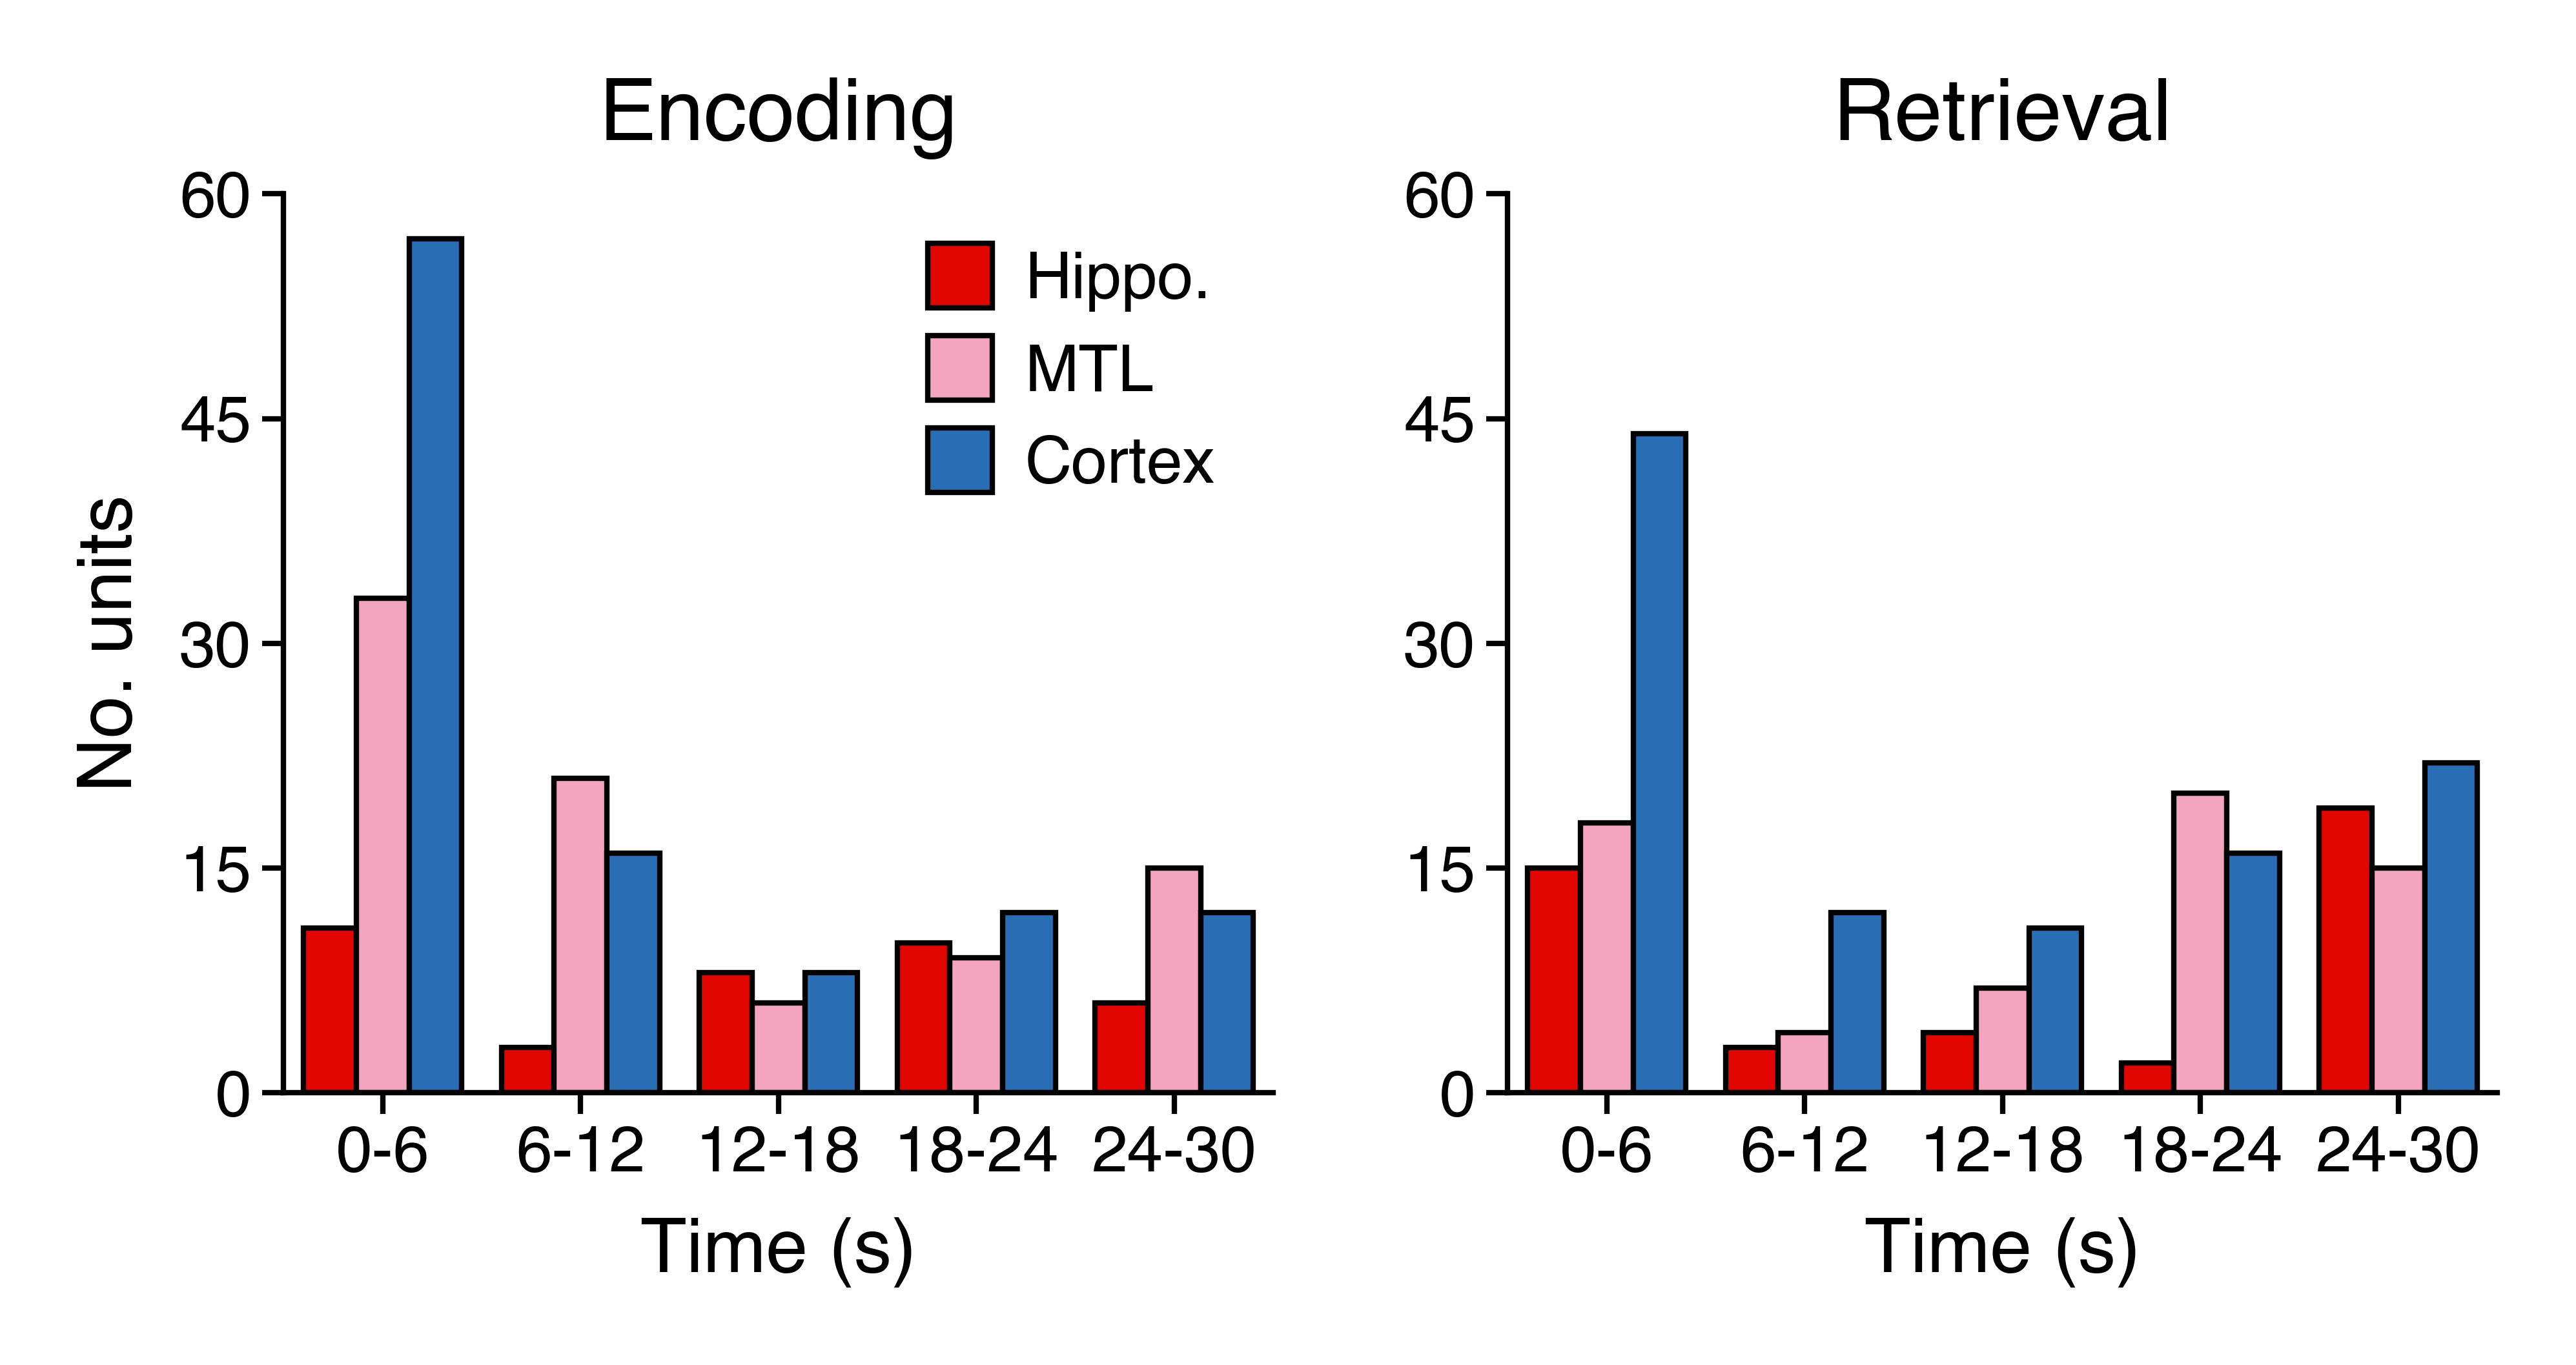

In [34]:
savefig = 1
overwrite = 1
figsize = (colws[2], colws[2] * 0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[3], cmap[2]]
    
for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='count', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-6', '6-12', '12-18', '18-24', '24-30'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 60])
    yticks = [0, 15, 30, 45, 60]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
    ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='Hippo.', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[2], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=1.2, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_navigation', 'navigation_time_cell_peak_firing_time_counts_by_region.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [35]:
n_bins_per_step = 12
game_states = ['Encoding', 'Retrieval']

_ols_pairs = ols_pairs.query("(testvar=='time') & (sig==True) & (gameState=={})".format(game_states)).copy()
_ols_pairs['peak_fr_ind'] = _ols_pairs['fr_max_ind'].apply(lambda x: int(x/n_bins_per_step))
peak_fr_counts = _ols_pairs.groupby(['gameState', 'roi_gen', 'peak_fr_ind']).size().reset_index().rename(columns={'peak_fr_ind': 'time', 0: 'count'})

roi_cats = ['MTL', 'Cortex']
peak_fr_counts.loc[peak_fr_counts['roi_gen']=='Hippocampus', 'roi_gen'] = 'MTL'
peak_fr_counts['roi_gen'] = peak_fr_counts['roi_gen'].astype(pd.CategoricalDtype(roi_cats, ordered=True))
peak_fr_counts = peak_fr_counts.sort_values(['gameState', 'roi_gen', 'time']).reset_index(drop=True)

_counts = peak_fr_counts.groupby(['gameState', 'roi_gen'])['count'].apply(np.sum).to_dict()
peak_fr_counts['prop'] = peak_fr_counts.apply(lambda x: 100 * (x['count'] / _counts[(x['gameState'], x['roi_gen'])]), axis=1)

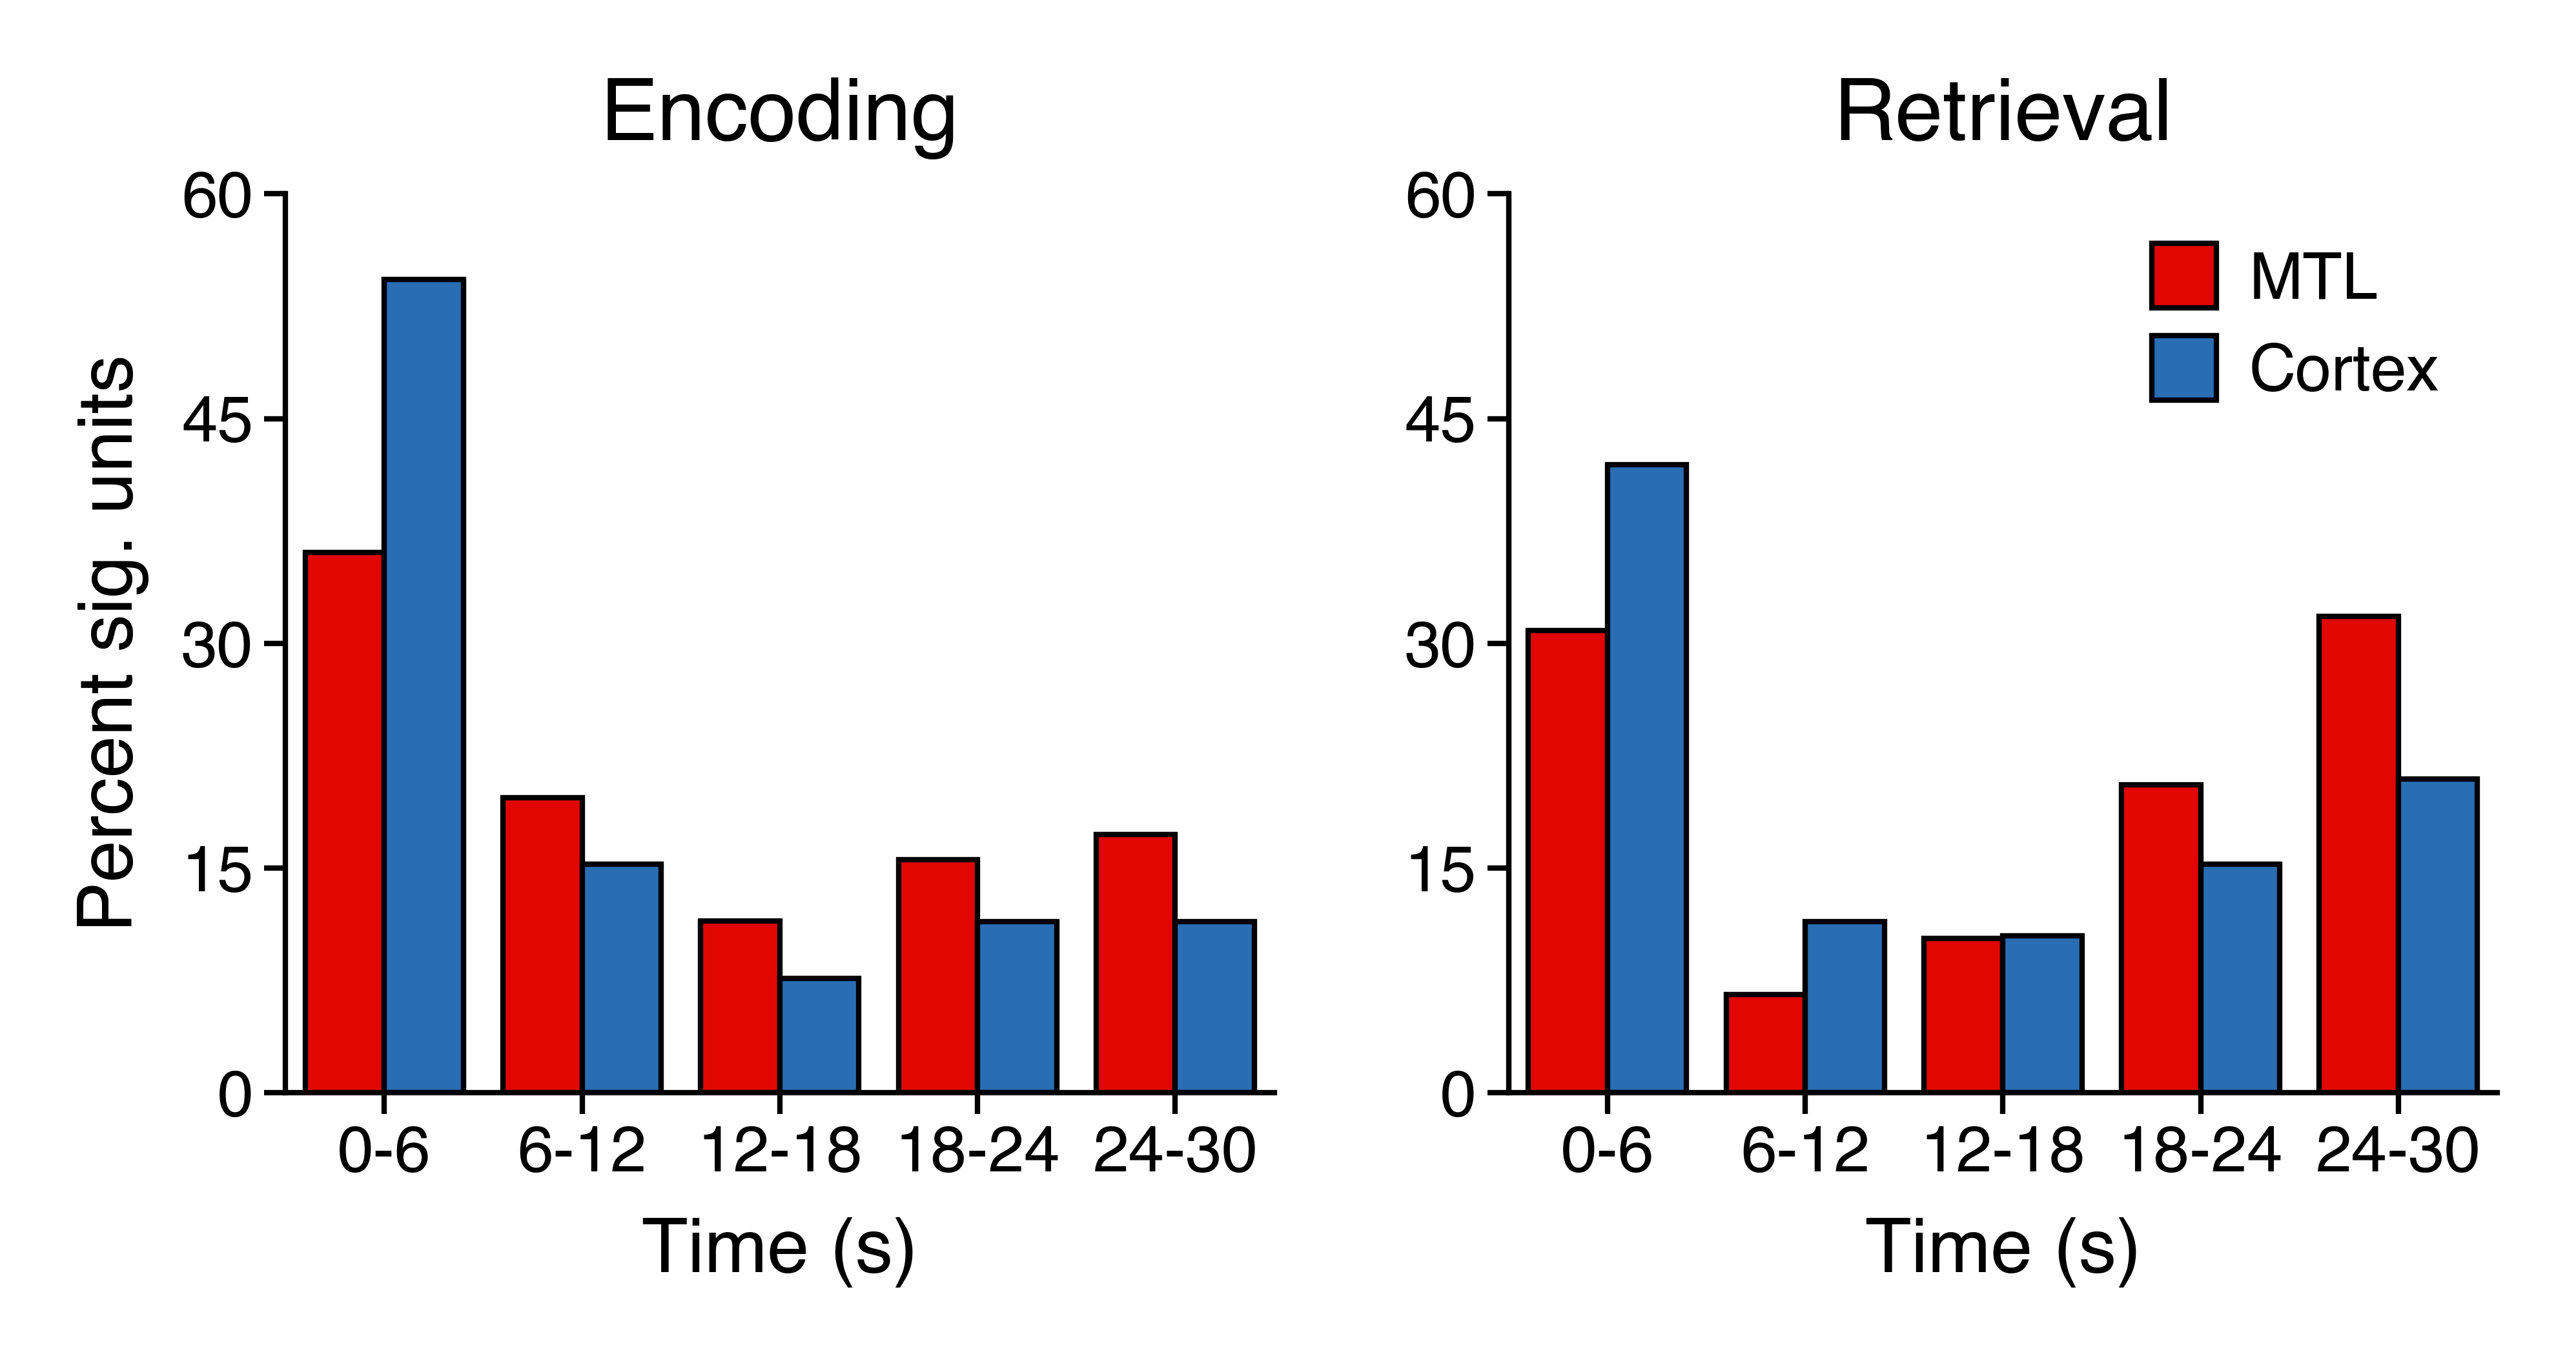

In [38]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[2]]
    
for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='prop', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-6', '6-12', '12-18', '18-24', '24-30'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 60])
    yticks = [0, 15, 30, 45, 60]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('Percent sig. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
    ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=1.2, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_navigation', 'navigation_time_cell_peak_firing_time_percents_by_region2.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

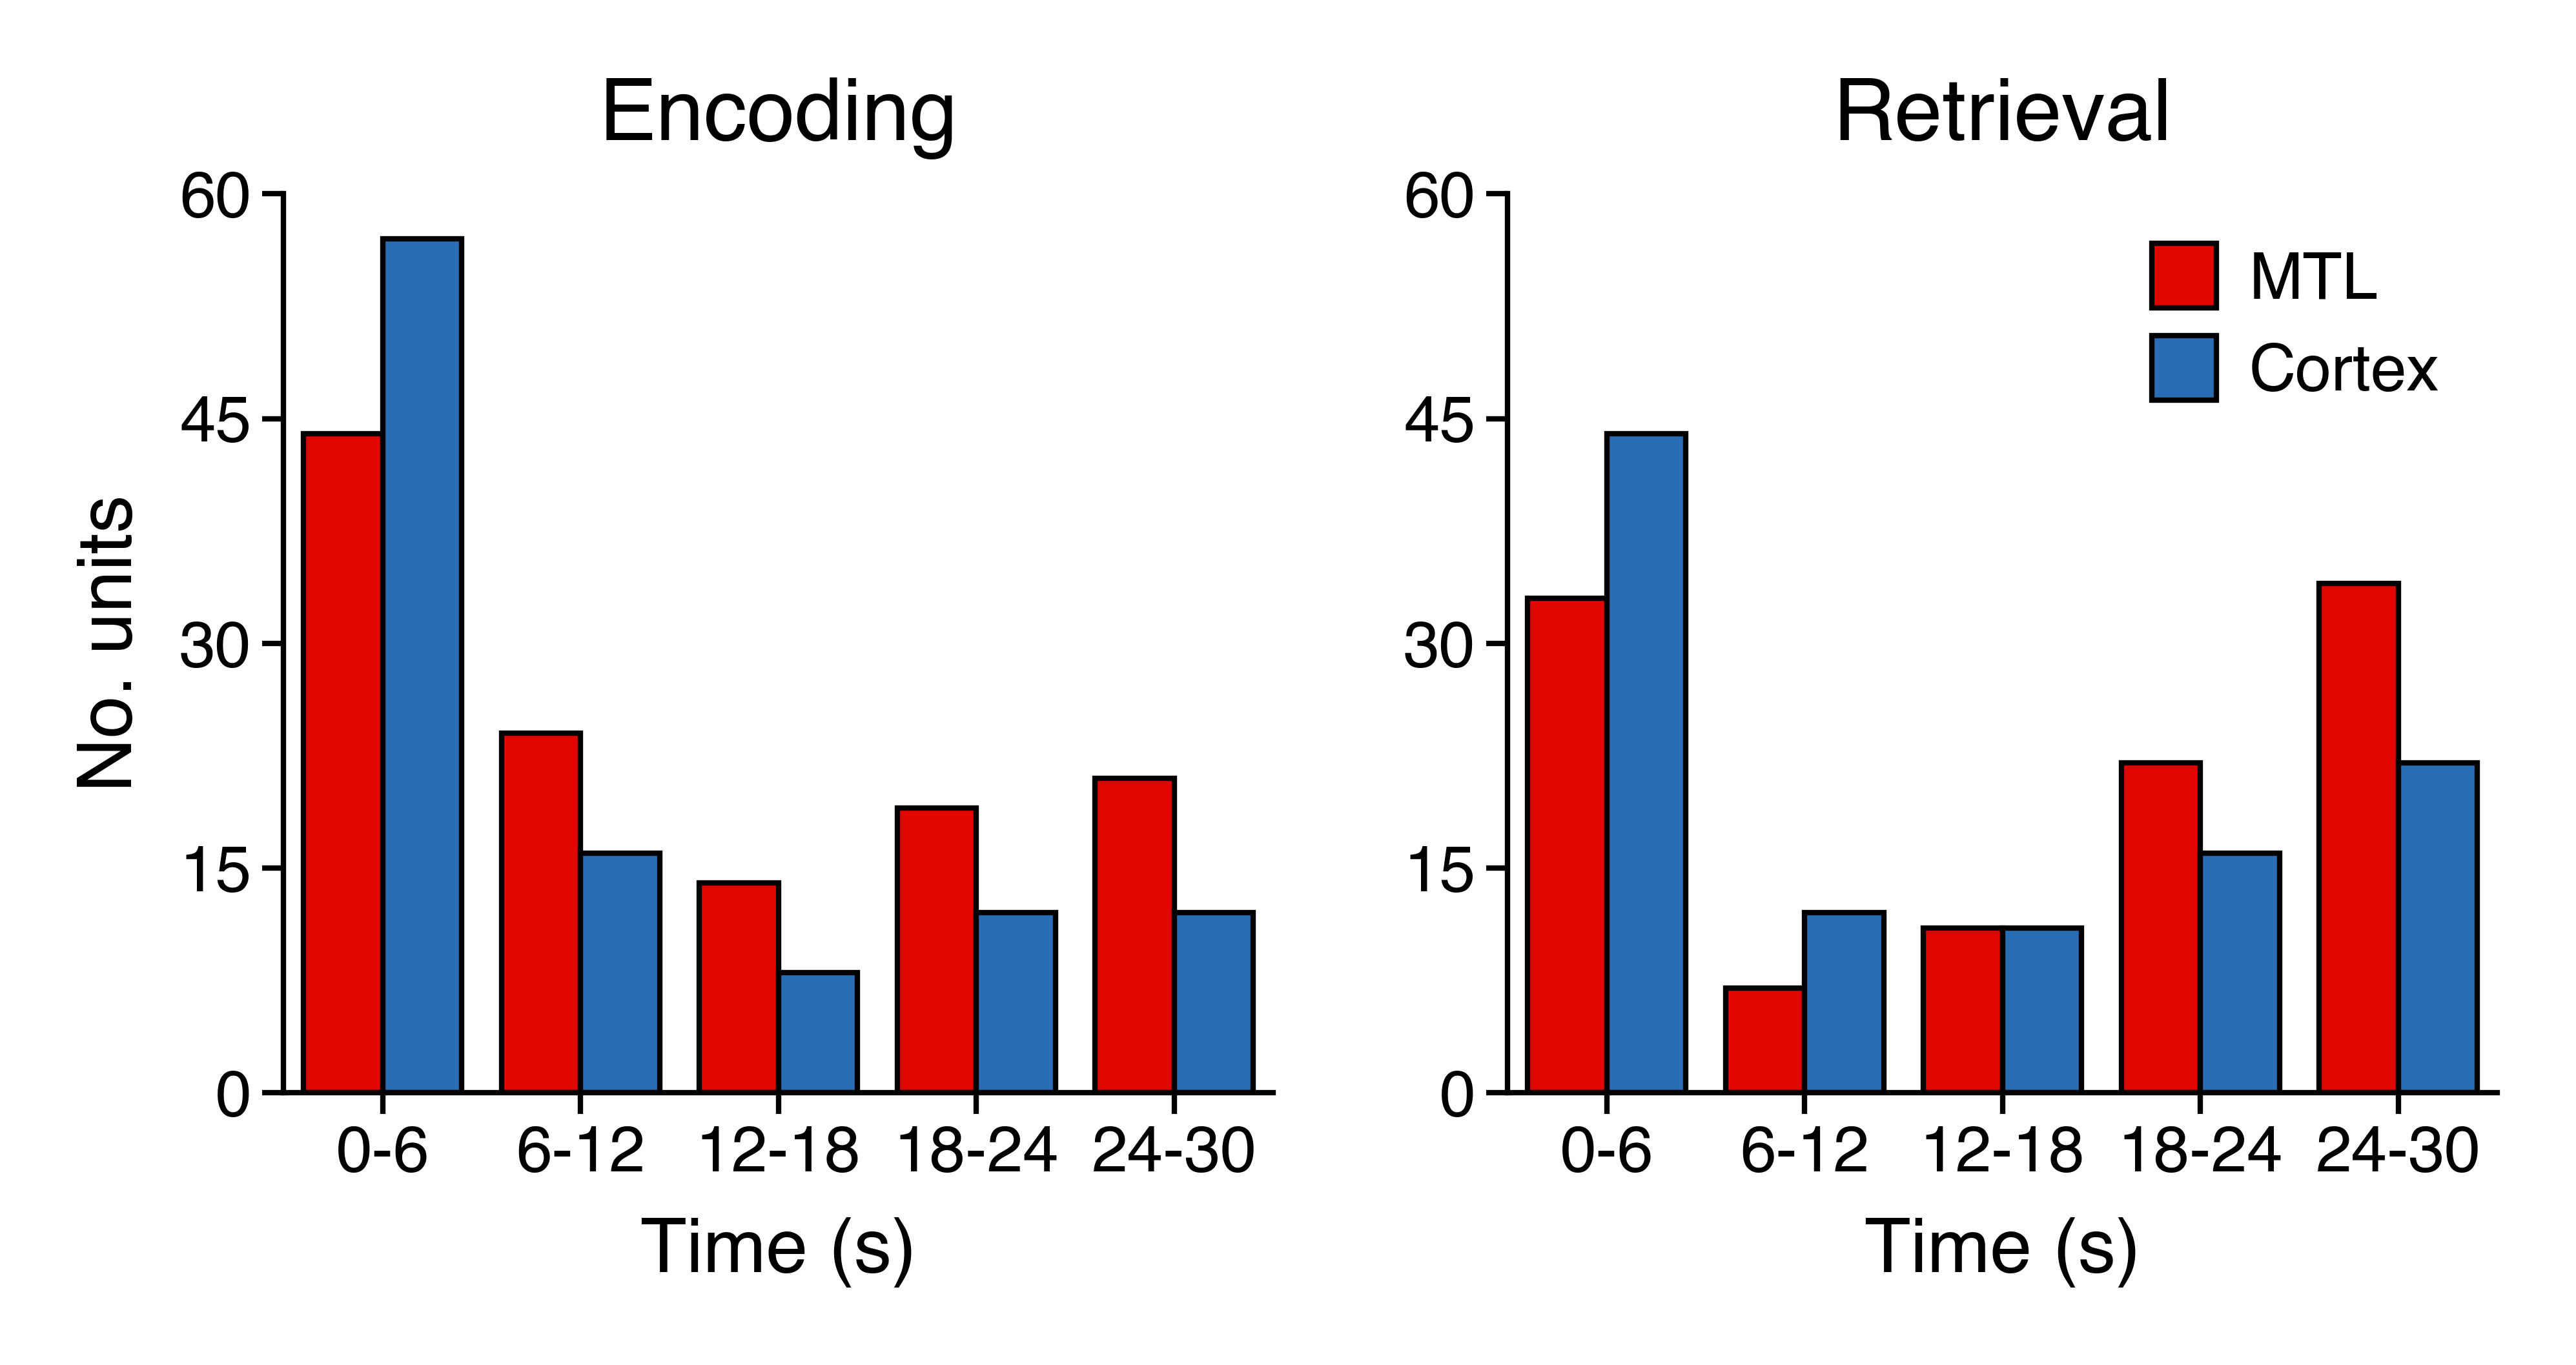

In [39]:
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2] * 0.5)
dpi = 1200
font = {'tick': 6, 'label': 7, 'annot': 6, 'fig': 8}
spine_lw = 0.5
ticklength = 2
tickpad = 1
labelpad = 3
figurepad = 5

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

cmap = {0: (190, 190, 190), # gray
        1: (225, 6, 0), # red
        2: (41, 110, 180), # blue
        3: (243, 165, 191)} # pink
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)
_cmap = [cmap[1], cmap[2]]
    
for iax, game_state in enumerate(['Encoding', 'Retrieval']):
    _df = peak_fr_counts.query("(gameState=='{}')".format(game_state)).copy()
    ax[iax] = sns.barplot(x='time', y='count', hue='roi_gen', data=_df, estimator=np.sum, ci=None, ax=ax[iax],
                        palette=_cmap, saturation=1, linewidth=spine_lw, edgecolor='k')
    # ax[iax].hlines(ols_pairs['subj_sess_unit'].unique().size * 0.005, -0.75, 9.75, colors='#e10600', linestyles='dashed', lw=spine_lw)
    ax[iax].tick_params(axis='both', width=spine_lw, length=ticklength, pad=tickpad, color='k', labelsize=font['tick'])
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].set_xticks(np.arange(5))
    ax[iax].set_xticklabels(['0-6', '6-12', '12-18', '18-24', '24-30'], fontsize=font['tick'])
    ax[iax].set_ylim([0, 60])
    yticks = [0, 15, 30, 45, 60]
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    if iax == 0:
        ax[iax].set_ylabel('No. units', fontsize=font['label'], labelpad=labelpad)
    else:
        ax[iax].set_ylabel('')
    ax[iax].set_title(game_state.replace('Delay', 'Delay '), fontsize=font['fig'], pad=figurepad)
    ax[iax].get_legend().remove()

custom_lines = [Line2D([0], [0], lw=0, marker='s', color='k', label='MTL', mfc=_cmap[0], mew=spine_lw, mec='k', ms=font['annot']),
                Line2D([0], [0], lw=0, marker='s', color='k', label='Cortex', mfc=_cmap[1], mew=spine_lw, mec='k', ms=font['annot'])]
legend = ax[iax].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1, 1), handletextpad=0)

fig.tight_layout(pad=0, w_pad=1.2, rect=[0, 0, 1, 1])

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_navigation', 'navigation_time_cell_peak_firing_time_counts_by_region2.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [145]:
# How strongly are significant neurons tuned?
# In what brain regions are these neurons located?
def mean_sem(val):
    return '{:.1f} ± {:.1f}'.format(np.mean(val), stats.sem(val))

def unique_dict(vec):
    vals, counts = np.unique(vec, return_counts=True)
    output = od([])
    for _i in range(len(vals)):
        output[vals[_i]] = counts[_i]
    return output

n_units_by_roi = ols_pairs.drop_duplicates('subj_sess_unit').groupby('roi_gen').size().to_dict()
_df = (ols_pairs.query("(full=='full') & (sig_holm==True)")
                .groupby(['gameState', 'testvar'])
                .agg({'z_lr': mean_sem, 
                      'roi_gen': unique_dict})
                .reset_index())
for roi in np.sort(list(n_units_by_roi.keys())):
    _df[roi] = _df['roi_gen'].apply(lambda x: '{}/{} ({:.1%})'.format(x.get(roi, 0), n_units_by_roi[roi], x.get(roi, 0)/n_units_by_roi[roi]))
_df.drop(columns=['roi_gen'], inplace=True)

_df

gameState       testvar        z_lr          Cortex   Hippocampus  \
0   Encoding          time   4.6 ± 0.2  25/136 (18.4%)  9/88 (10.2%)   
1   Encoding         place   6.0 ± 0.6  20/136 (14.7%)   3/88 (3.4%)   
2   Encoding    head_direc   5.2 ± 0.6    7/136 (5.1%)   7/88 (8.0%)   
3   Encoding  gold_in_view   8.9 ± 0.9  18/136 (13.2%)  9/88 (10.2%)   
4   Encoding  base_in_view  19.1 ± 4.6  18/136 (13.2%)   0/88 (0.0%)   
5  Retrieval          time   4.6 ± 0.2  23/136 (16.9%)   4/88 (4.5%)   
6  Retrieval         place   5.9 ± 0.7  20/136 (14.7%)   3/88 (3.4%)   
7  Retrieval    head_direc   5.3 ± 1.0    6/136 (4.4%)   3/88 (3.4%)   
8  Retrieval  gold_in_view   7.1 ± 0.8    5/136 (3.7%)   7/88 (8.0%)   
9  Retrieval  base_in_view  23.1 ± 6.0   13/136 (9.6%)   4/88 (4.5%)   

              MTL  
0  19/183 (10.4%)  
1   14/183 (7.7%)  
2    6/183 (3.3%)  
3   16/183 (8.7%)  
4    7/183 (3.8%)  
5   10/183 (5.5%)  
6   16/183 (8.7%)  
7    7/183 (3.8%)  
8    3/183 (1.6%)  
9    5/183 (2.7%)

# Single-cell examples: time, place, head direction, and view coding

In [ ]:
# neurons = ['U518_ses0-4-1', 'U532_ses0-4-1', 'U530_ses0-13-1', 'U518_ses0-73-1', 'U518_ses1-38-1', 'U532_ses0-10-1',
#            'U532_ses0-5-8', 'U530_ses0-3-2', 'U526_ses0-12-2', 'U518_ses0-73-1', 'U527_ses0-58-2', 'U532_ses0-8-2',
#            'U518_ses1-43-2', 'U532_ses0-4-3', 'U532_ses0-3-2', 'U518_ses1-36-1']

In [88]:
ols_pairs.query("(sig==True)").sort_values('z_lr', ascending=0)[['subj_sess_unit', 'hem', 'roi', 'gameState', 'testvar', 'z_lr', 'fr_max_ind10', 'sparsity']]

subj_sess_unit hem roi  gameState       testvar       z_lr  fr_max_ind10  \
42   U537_ses0-24-1   R  AH     Delay1          time  10.096879             0   
39   U537_ses0-20-1   R  AH  Retrieval     is_moving   9.740563             5   
43   U537_ses0-24-1   R  AH     Delay2          time   8.812489             0   
6    U537_ses0-10-1   R   A   Encoding  base_in_view   6.456024             0   
1    U537_ses0-10-1   R   A     Delay2          time   4.707333             0   
15   U537_ses0-15-1   R   A     Delay2          time   4.490799             1   
54   U537_ses0-24-1   R  AH  Retrieval  base_in_view   4.426363             9   
103  U537_ses0-33-2   L   A   Encoding     is_moving   3.919248             2   
75   U537_ses0-27-1   L  OF   Encoding     is_moving   3.862800             7   
45   U537_ses0-24-1   R  AH   Encoding         place   3.684846             5   
53   U537_ses0-24-1   R  AH  Retrieval     is_moving   3.653746             9   
143  U537_ses0-39-1   L   A   Encoding         place   3.319020             4   
107  U537_ses0-33-2   L   A  Retrieval         place   3.282622             8   
24   U537_ses0-15-1   R   A  Retrieval    head_direc   3.151002             8   
99   U537_ses0-33-2   L   A     Delay2          time   3.118949             7   
91   U537_ses0-33-1   L   A   Encoding  gold_in_view   3.115296             3   
33   U537_ses0-20-1   R  AH   Encoding     is_moving   2.918534             7   
20   U537_ses0-15-1   R   A   Encoding  base_in_view   2.503714             0   
109  U537_ses0-33-2   L   A  Retrieval     is_moving   2.285139             8   
22   U537_ses0-15-1   R   A  Retrieval          time   1.988252             8   
129  U537_ses0-37-1   L   A   Encoding         place   1.913605             6   

     sparsity  
42   0.574437  
39   0.940714  
43   0.668939  
6    0.872065  
1    0.871392  
15   0.945983  
54   0.889589  
103  0.980040  
75   0.987287  
45   0.904778  
53   0.889589  
143  0.992674  
107  0.977673  
24   0.965499  
99   0.976313  
91   0.994525  
33   0.931969  
20   0.966071  
109  0.977673  
22   0.965499  
129  0.955289

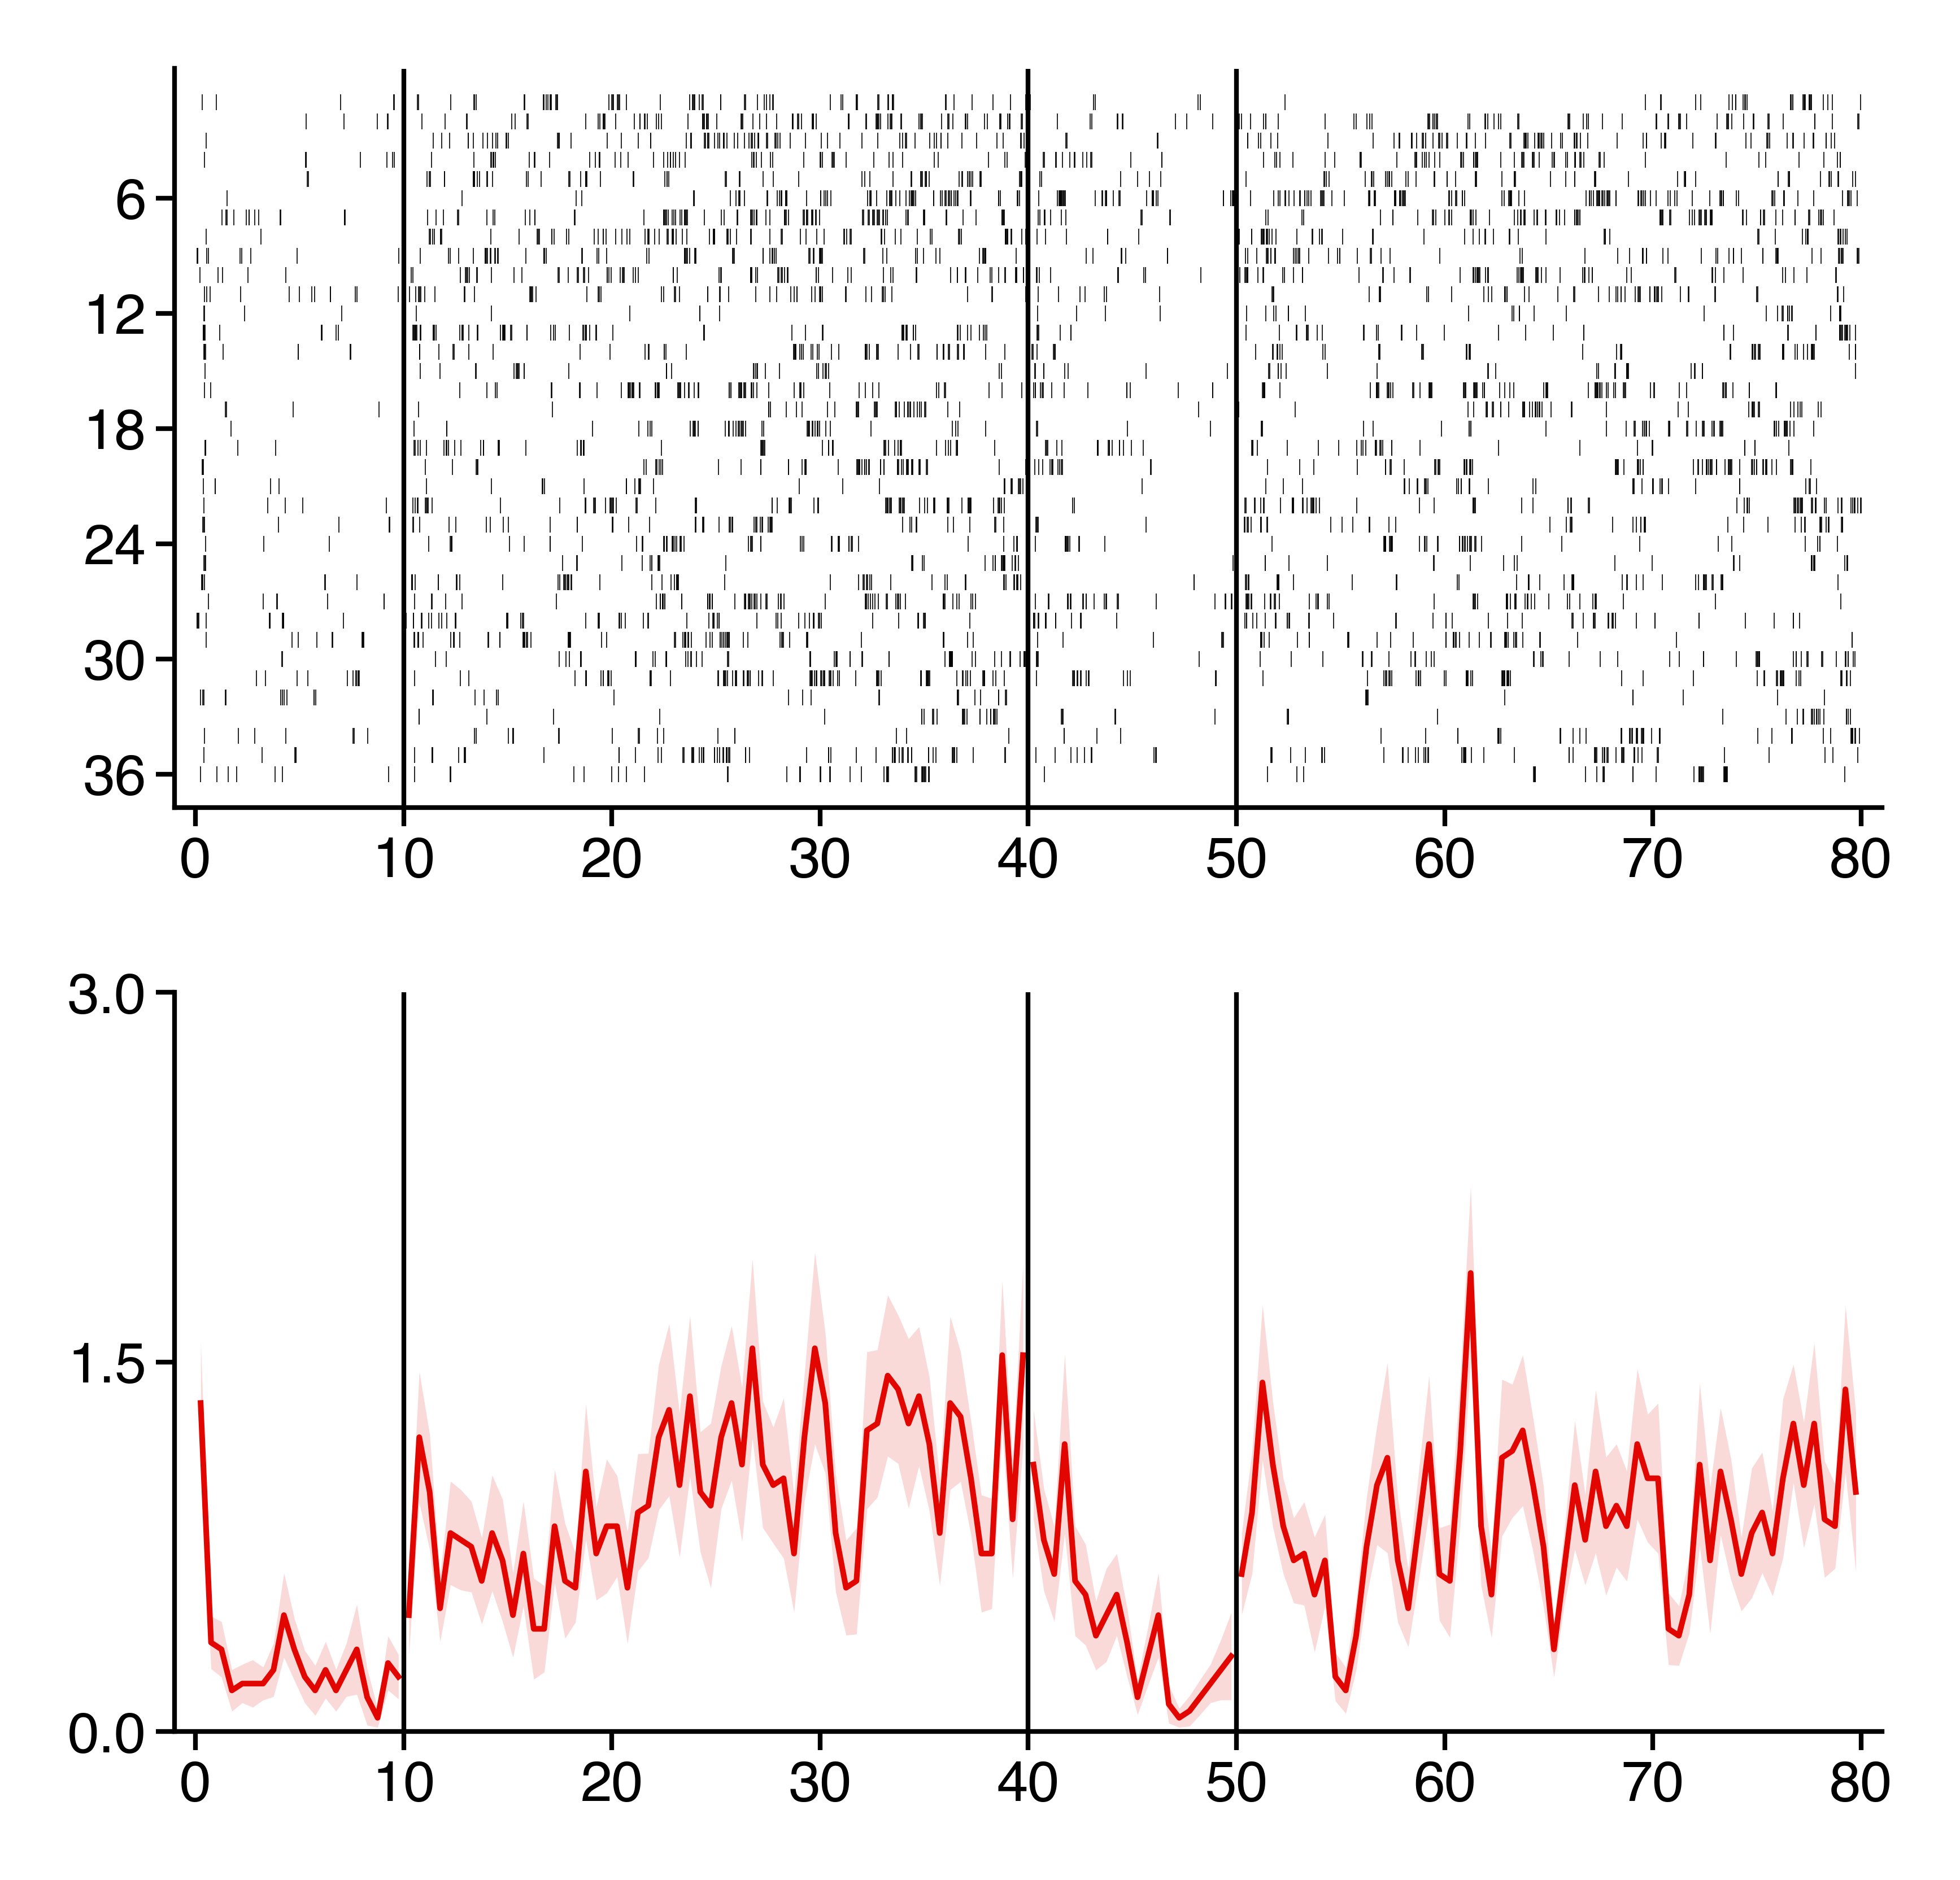

In [89]:
# Save raster and firing rate plots for chosen neuron.
subj_sess_unit = 'U537_ses0-24-1'
game_states = ['Delay1', 'Encoding', 'Delay2', 'Retrieval']
savefig = 0
overwrite = 1
figsize = (3.25, 3.25)
dpi = 1200
font = {'tick': 6, 'label': 8, 'annot': 8, 'fig': 9}
ax_linewidth = 0.5
labelpad = 2
plot_vlines = 1
plot_labels = 0
plot_game_states = 0
plot_title = 0
rastersize = 1.7
rasterwidth = 0.1

plt.close()
fig, ax = plt.subplots(2, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron,
                                      game_states=game_states,
                                      plot_vlines=plot_vlines,
                                      plot_labels=plot_labels,
                                      plot_game_states=plot_game_states,
                                      plot_title=plot_title,
                                      ax=ax[iax],
                                      font=font,
                                      labelpad=labelpad,
                                      ax_linewidth=ax_linewidth,
                                      rastersize=rastersize,
                                      rasterwidth=rasterwidth)
iax += 1
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron,
                                                game_states=game_states,
                                                plot_vlines=plot_vlines,
                                                plot_labels=plot_labels,
                                                plot_game_states=plot_game_states,
                                                plot_title=plot_title,
                                                ax=ax[iax],
                                                font=font,
                                                labelpad=labelpad,
#                                                 ymin=1.5,
#                                                 ymax=1.5,
#                                                 yticks=[1, 3, 5],
                                                ax_linewidth=ax_linewidth)

if savefig:
    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    filename = op.join(proj_dir, 'figs', 'plot_rasters',
                       '{}-CSC{}-unit{}-{}-{}-raster.pdf'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

In [ ]:
units = ['U518_ses1-43-2', 'U518_ses1-67-2', 'U518_ses1-38-1', 'U521_ses0-21-1', 'U532_ses0-4-3', 'U532_ses0-8-2']
cols = ['subj_sess_unit', 'hem', 'roi', 'gameState', 'testvar', 'full', 'z_lr', 'emp_pval', 'sig_holm', 'fr_mean', 'fr_max']
_units = ['U518_ses1-43-2', 'U521_ses0-21-1', 'U532_ses0-4-3']
ols_pairs.query("(full=='full') & (subj_sess_unit=={}) & (sig_holm==True)".format(_units)).reset_index(drop=True)[cols]

U536_ses0-76-1, Retrieval, Z = 5.2, sig = True
Done in 13.2s


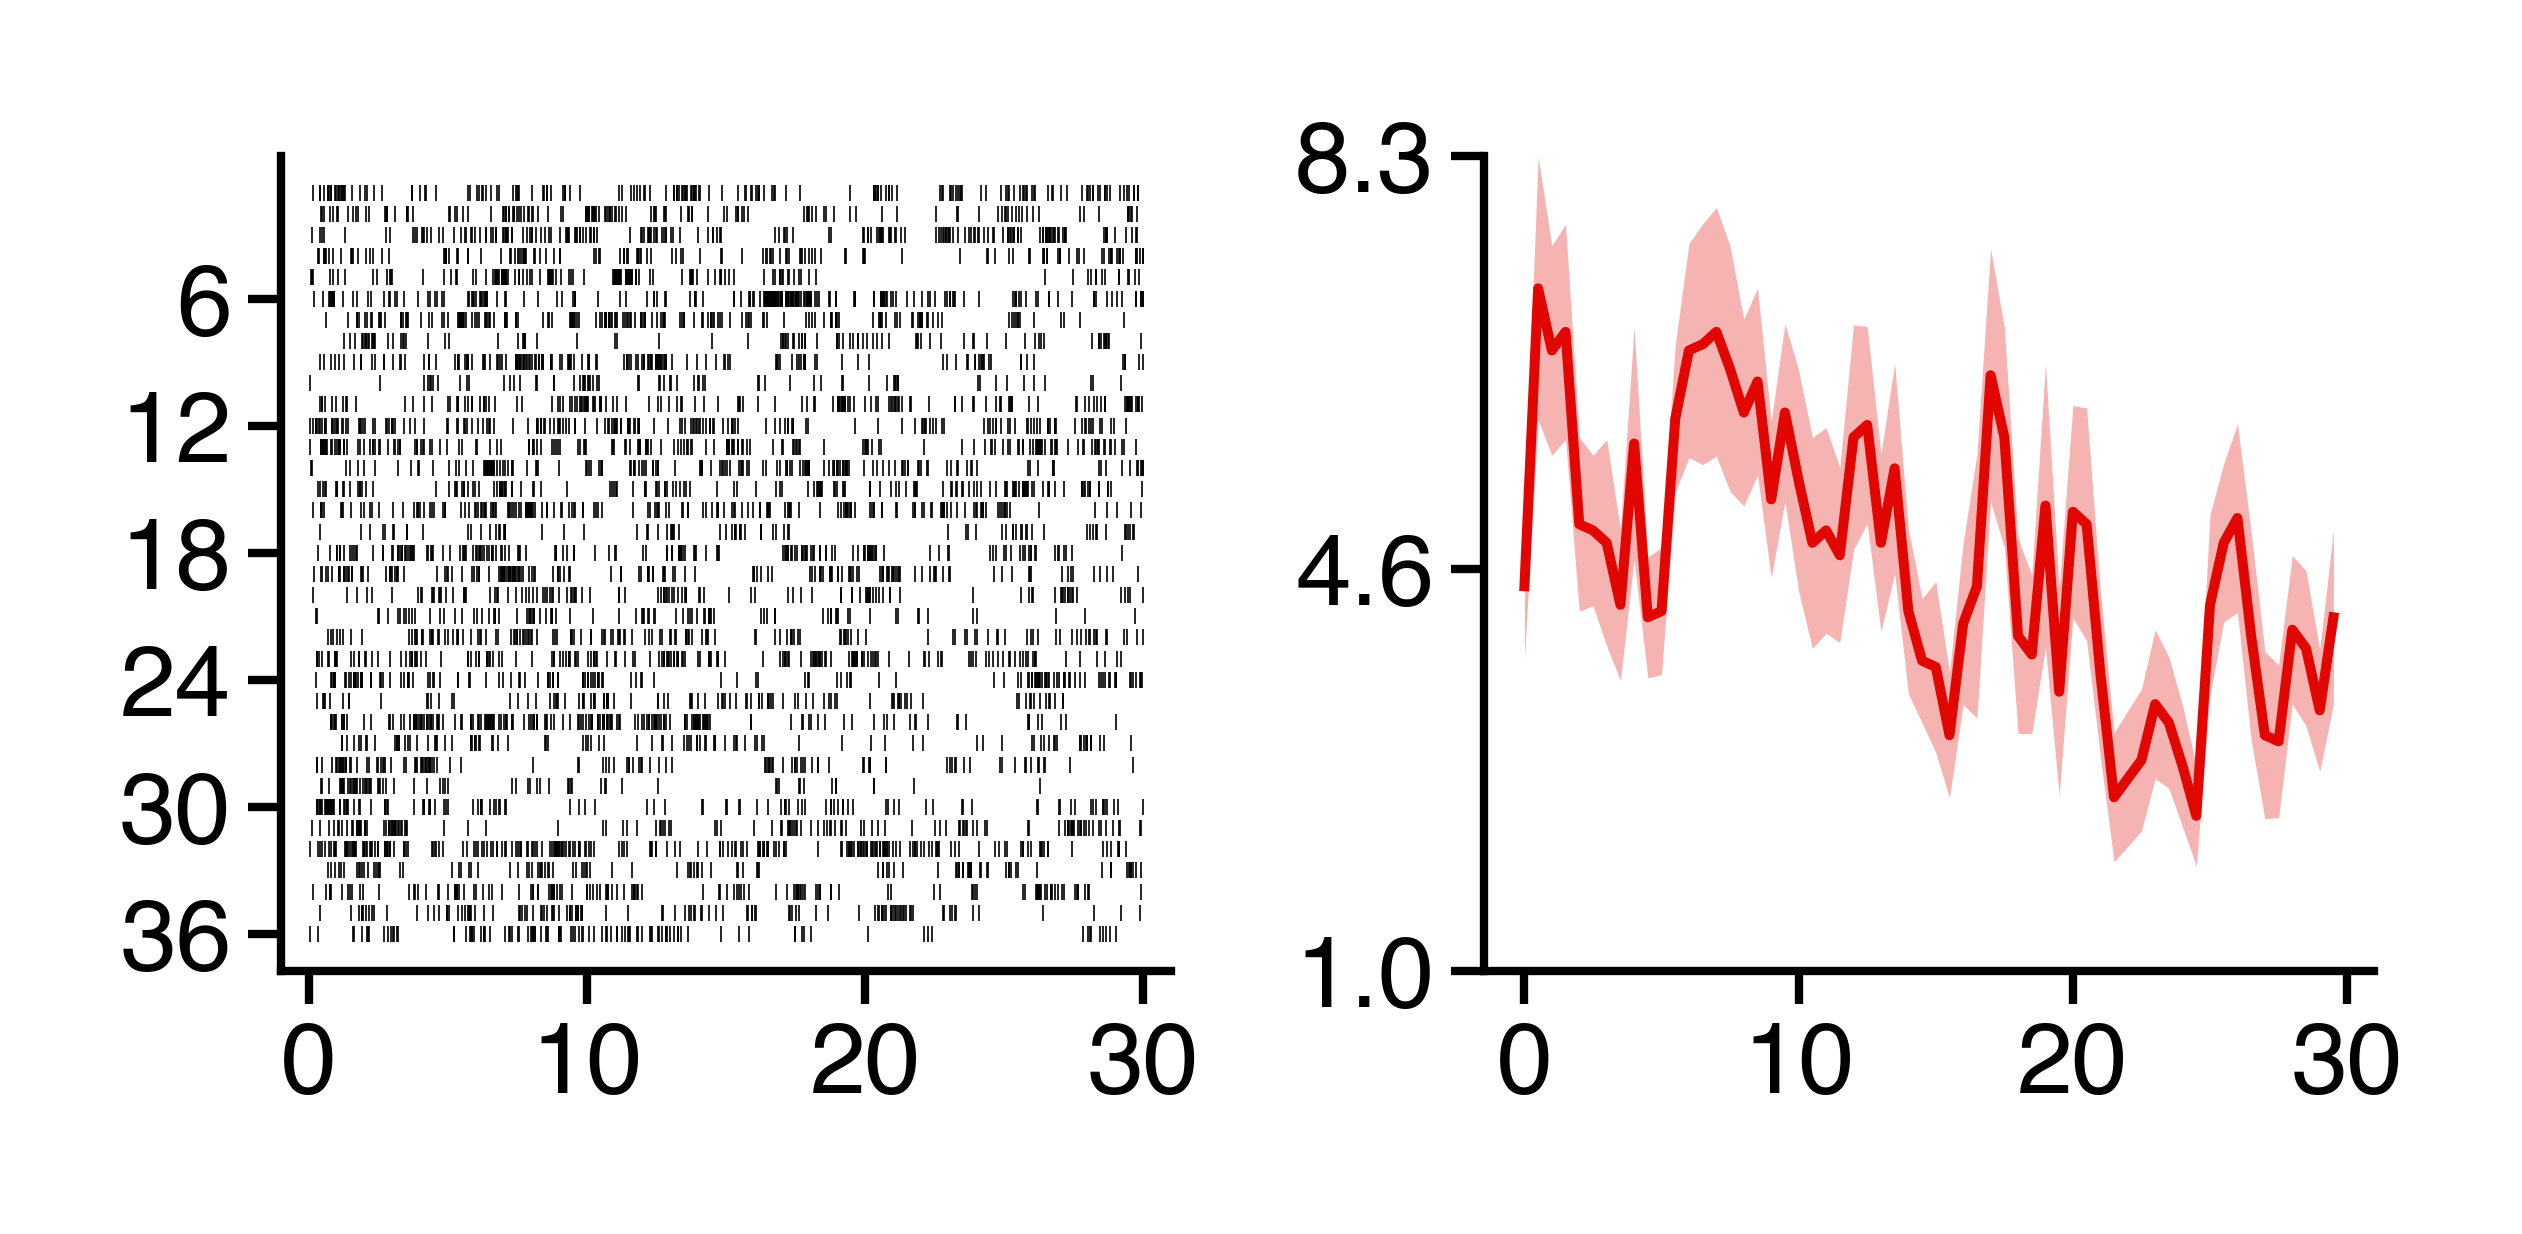

In [42]:
# Plot a neuron's spike raster and firing rate over time.
savefig = False
overwrite = False
plot_labels = False
plot_game_states = False
plot_title = False
font = {'tick': 6, 'label': 6, 'annot': 7, 'fig': 9}
labelpad = 2 # 1
game_states = ['Encoding', 'Retrieval']

start_time = time()

# unit = 'U532_ses0-4-3'
# game_state = 'Encoding'
# _df = ols_pairs.query("(testvar=='time') & (subj_sess_unit=='{}') & (gameState=='{}')".format(unit, game_state))
_df = ols_pairs.query("(testvar=='time') & (full=='full') & (sig_holm==True) & (subj_sess=='U536_ses0')")
# units = ['U518_ses1-43-2', 'U518_ses1-67-2', 'U518_ses1-38-1', 'U521_ses0-21-1', 'U532_ses0-8-2', 'U532_ses0-4-3']
# _df = ols_pairs.query("(testvar=='time') & (full=='full') & (subj_sess_unit=={}) & (gameState=={})".format(units, game_states))
for idx, row in _df.iterrows():
    subj_sess = row['subj_sess']
    neuron = row['neuron']
    game_state = row['gameState']
    
    # -------------------------------------------
    # PLOTTING
    plt.close()
    fig = plt.figure(figsize=(2.25, 2.25*(14/35)), dpi=1200)
    if plot_labels:
        n_rows = 14
        n_cols = 37
        ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=14, colspan=15),
              plt.subplot2grid((n_rows, n_cols), (0, 22), rowspan=14, colspan=15)]
        ax = np.ravel(ax)
    else:
        n_rows = 14
        n_cols = 35
        ax = [plt.subplot2grid((n_rows, n_cols), (0, 0), rowspan=14, colspan=15),
              plt.subplot2grid((n_rows, n_cols), (0, 20), rowspan=14, colspan=15)]
        ax = np.ravel(ax)

    # Spike raster plot.
    iax = 0
    ax[iax] = trial_raster4(subj_sess,
                            neuron, 
                            game_states=game_state,
                            plot_vlines=False, 
                            plot_labels=plot_labels,
                            plot_game_states=plot_game_states,
                            plot_trial_phases=False, 
                            plot_title=plot_title,
                            ax=ax[iax],
                            font=font,
                            labelpad=labelpad)
        
    # Firing rate over time plot.
    iax = 1
    mean_frs = np.array(row['mean_frs'])
    sem_frs = np.array(row['sem_frs'])
    ymin = np.max((0, np.floor(np.min(mean_frs - sem_frs))))
    ymax = np.max(mean_frs + sem_frs)
    ax[iax].fill_between(np.arange(len(mean_frs)), mean_frs + sem_frs, mean_frs - sem_frs,
                         color='#e10600', linewidth=0, alpha=0.3)
    ax[iax].plot(mean_frs, color='#e10600', linewidth=0.6)
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(0.5)
    ax[iax].tick_params(axis='both', which='both', length=2, width=0.5, pad=1)
    ax[iax].set_xticks(np.linspace(0, 60, 4))
    ax[iax].set_xticklabels(np.linspace(0, 30, 4, dtype=np.int), fontsize=font['tick'])
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_yticks(np.round(np.linspace(ymin, ymax, 3), 1))
    ax[iax].set_yticklabels(np.round(np.linspace(ymin, ymax, 3), 1), fontsize=font['tick'])
    if plot_labels:
        ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Firing rate (Hz)', fontsize=font['label'], labelpad=labelpad)
        
    if savefig:
        chan, unit = neuron.split('-')
        hemroi = spike_preproc.roi_lookup(subj_sess, chan)
        filename = op.join(proj_dir, 'figs', 'plot_navigation',
                           '{}-CSC{}-unit{}-{}-{}-time_firing.pdf'.format(subj_sess, chan, unit, hemroi, game_state))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight')

print('{}-{}, {}, Z = {:.1f}, sig = {}'.format(subj_sess, neuron, game_state, row['z_lr'], row['sig_holm']))
print('Done in {:.1f}s'.format(time() - start_time))
fig.show()

U536_ses0-76-1, Retrieval, Z = 3.5, sig = True
Done in 49.7s


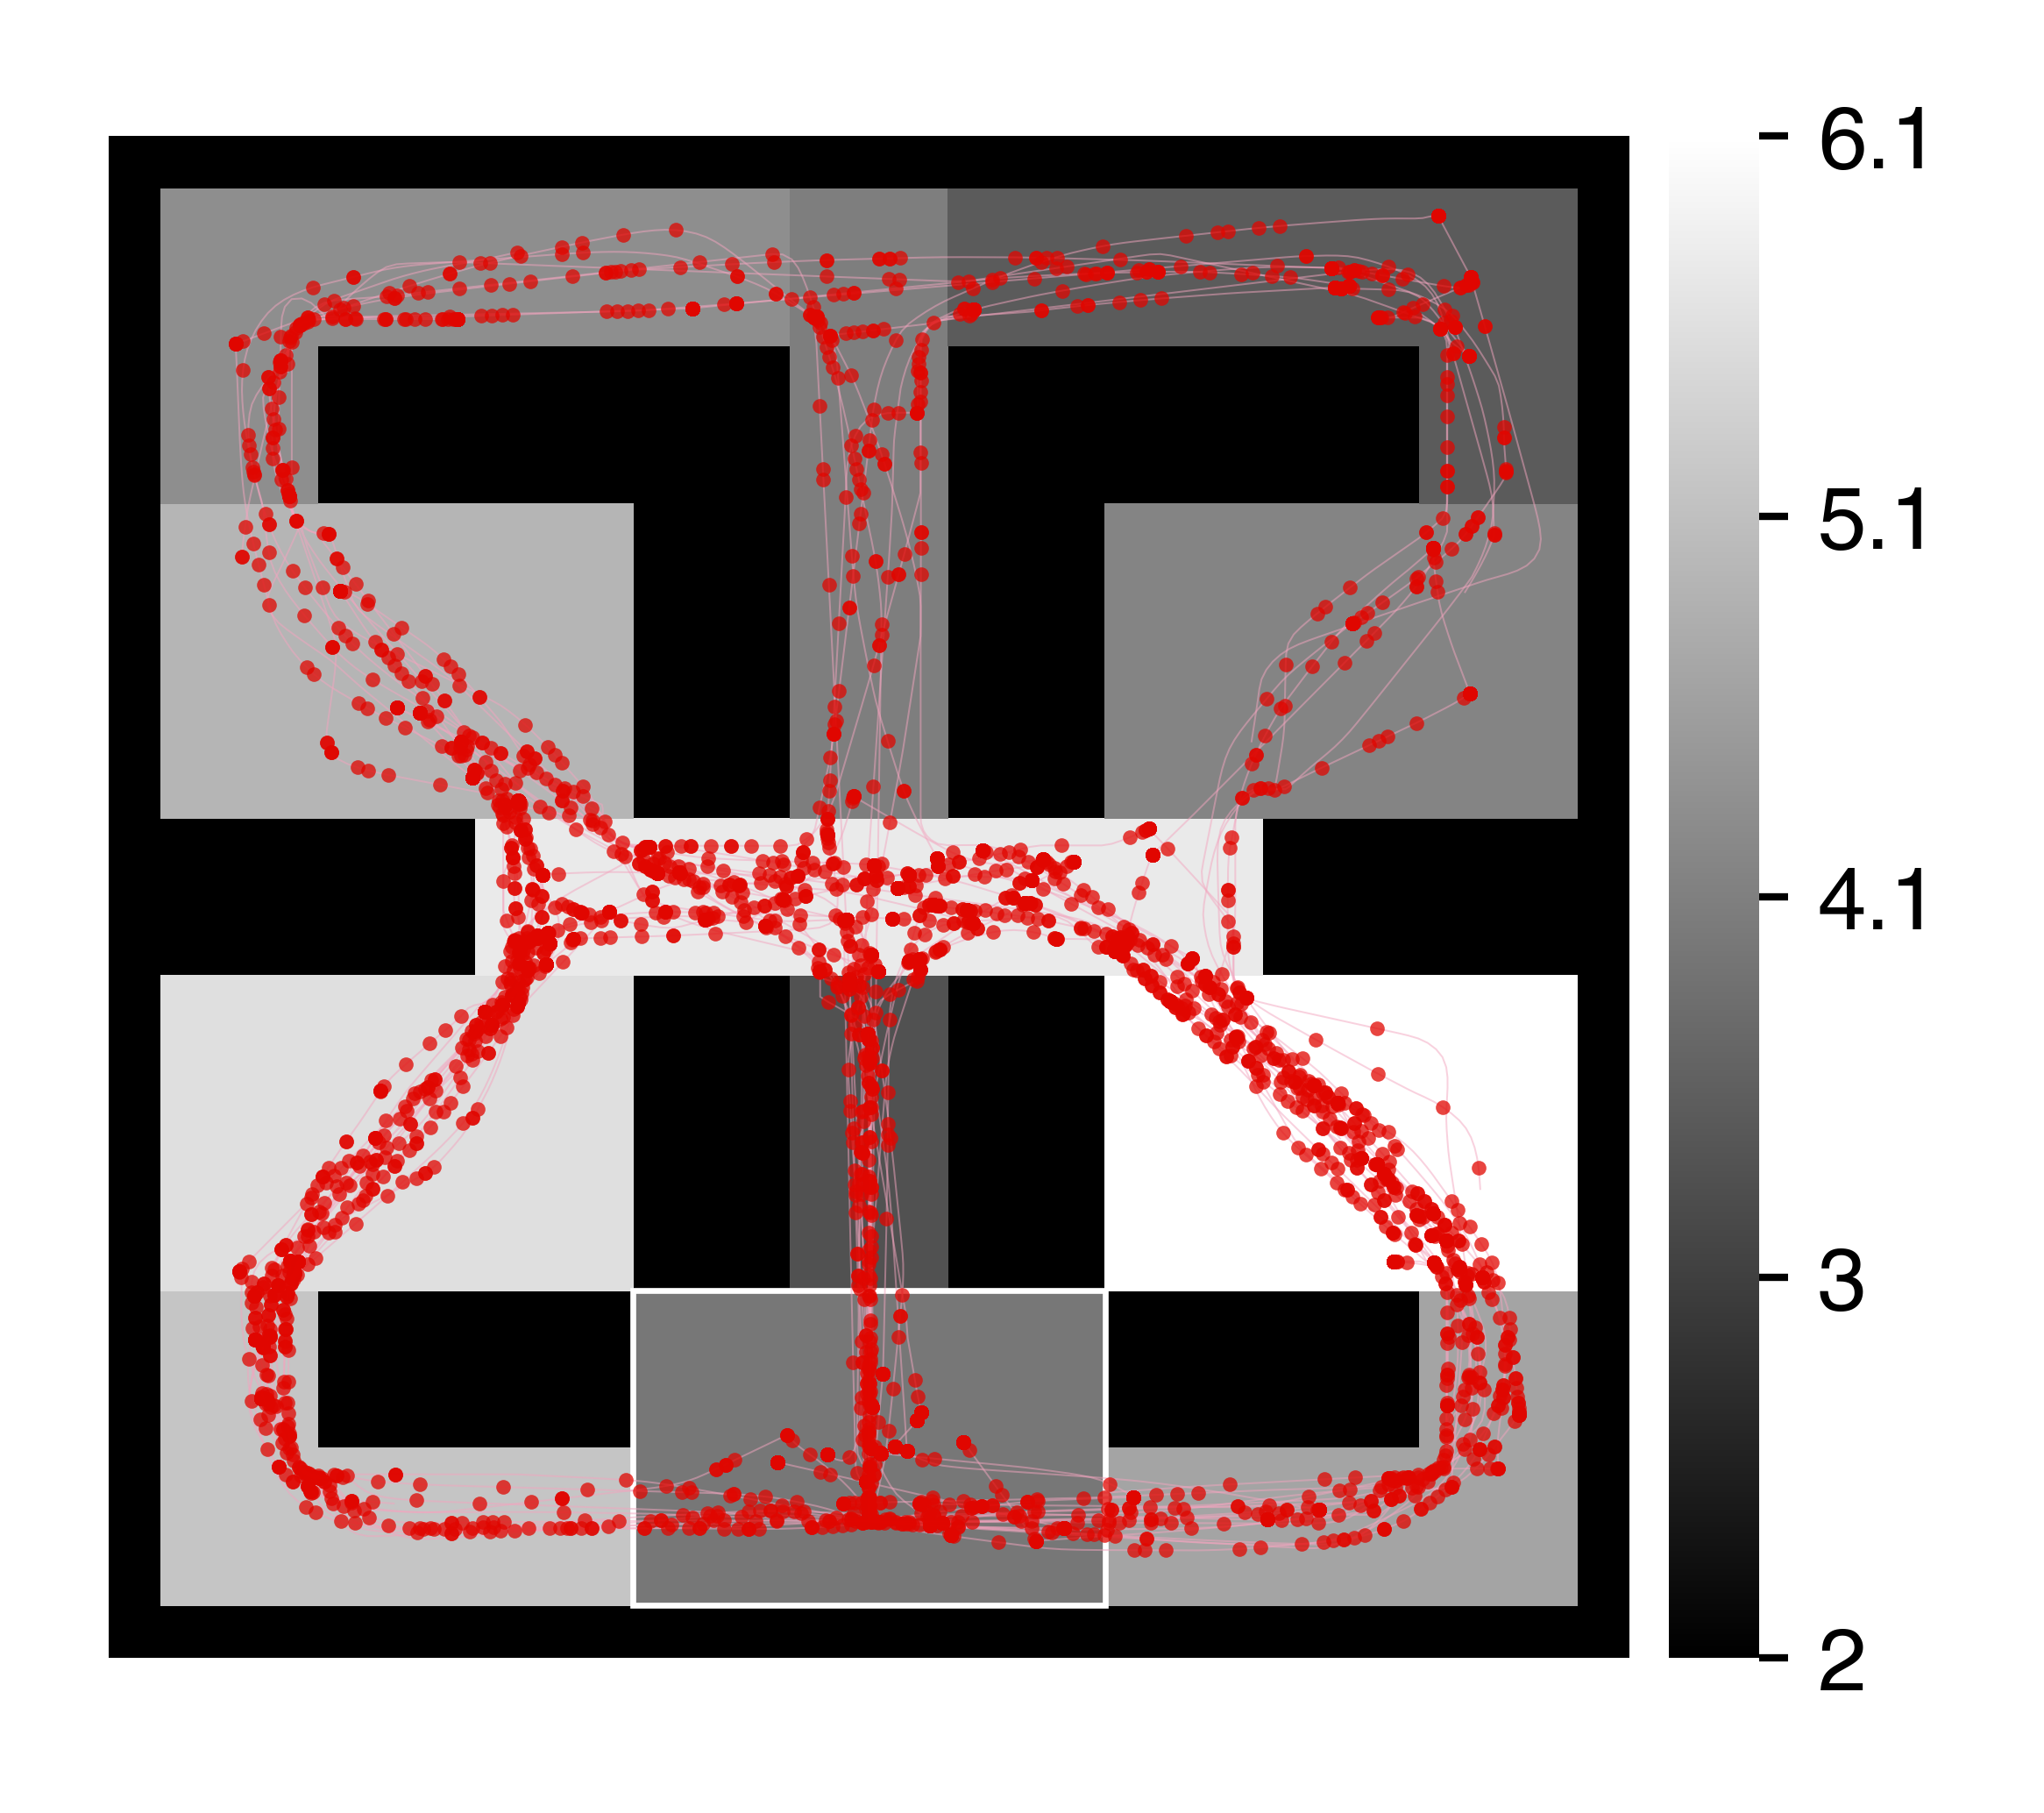

In [106]:
# Plot a neuron's firing rate by maze location.
savefig = False
overwrite = False
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 9}
base_color = 'w'
game_states = ['Encoding', 'Retrieval']
only_show_spikes_when_moving = False

start_time = time()

# unit = 'U518_ses1-43-2'
# unit = 'U521_ses0-21-1'
unit = 'U532_ses0-4-3'
game_state = 'Encoding'
# _df = ols_pairs.query("(testvar=='place') & (subj_sess_unit=='{}') & (gameState=='{}')".format(unit, game_state))
_df = ols_pairs.query("(testvar=='place') & (full=='full') & (sig_holm==True) & (subj_sess=='U536_ses0')")
# units = ['U518_ses1-43-2', 'U518_ses1-67-2', 'U518_ses1-38-1', 'U521_ses0-21-1', 'U532_ses0-8-2', 'U532_ses0-4-3']
# _df = ols_pairs.query("(testvar=='place') & (full=='full') & (subj_sess_unit=={}) & (gameState=={})".format(units, game_states))
for idx, row in _df.iterrows():
    subj_sess = row['subj_sess']
    neuron = row['neuron']
    game_state = row['gameState']
    
    fig, ax = plot_firing_maze(subj_sess, 
                               neuron, 
                               game_state, 
                               font=font, 
                               base_color=base_color,
                               only_show_spikes_when_moving=only_show_spikes_when_moving,
                               nav_lw=0.12,
                               nav_color='#296eb4', #f3a5bf
                               nav_alpha=0.5,
                               spike_marker='.',
                               spike_fill_color='#e10600',
                               spike_edge_color='#e10600',
                               spike_alpha=0.75, # 0.25 0.5
                               spike_markersize=2, # 1
                               spike_mew=0,
                               dpi=dpi)

    if savefig:
        chan, unit = neuron.split('-')
        hemroi = spike_preproc.roi_lookup(subj_sess, chan)
        filename = op.join(proj_dir, 'figs', 'plot_navigation', 
                           '{}-CSC{}-unit{}-{}-{}-place_firing.png'.format(subj_sess, chan, unit, hemroi, game_state))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='png', dpi=dpi, bbox_inches='tight')

print('{}-{}, {}, Z = {:.1f}, sig = {}'.format(subj_sess, neuron, game_state, row['z_lr'], row['sig_holm']))
print('Done in {:.1f}s'.format(time() - start_time))
fig.show()

U537_ses0-33-1, Retrieval, Z = 5.4, sig = True
Done in 8.4s


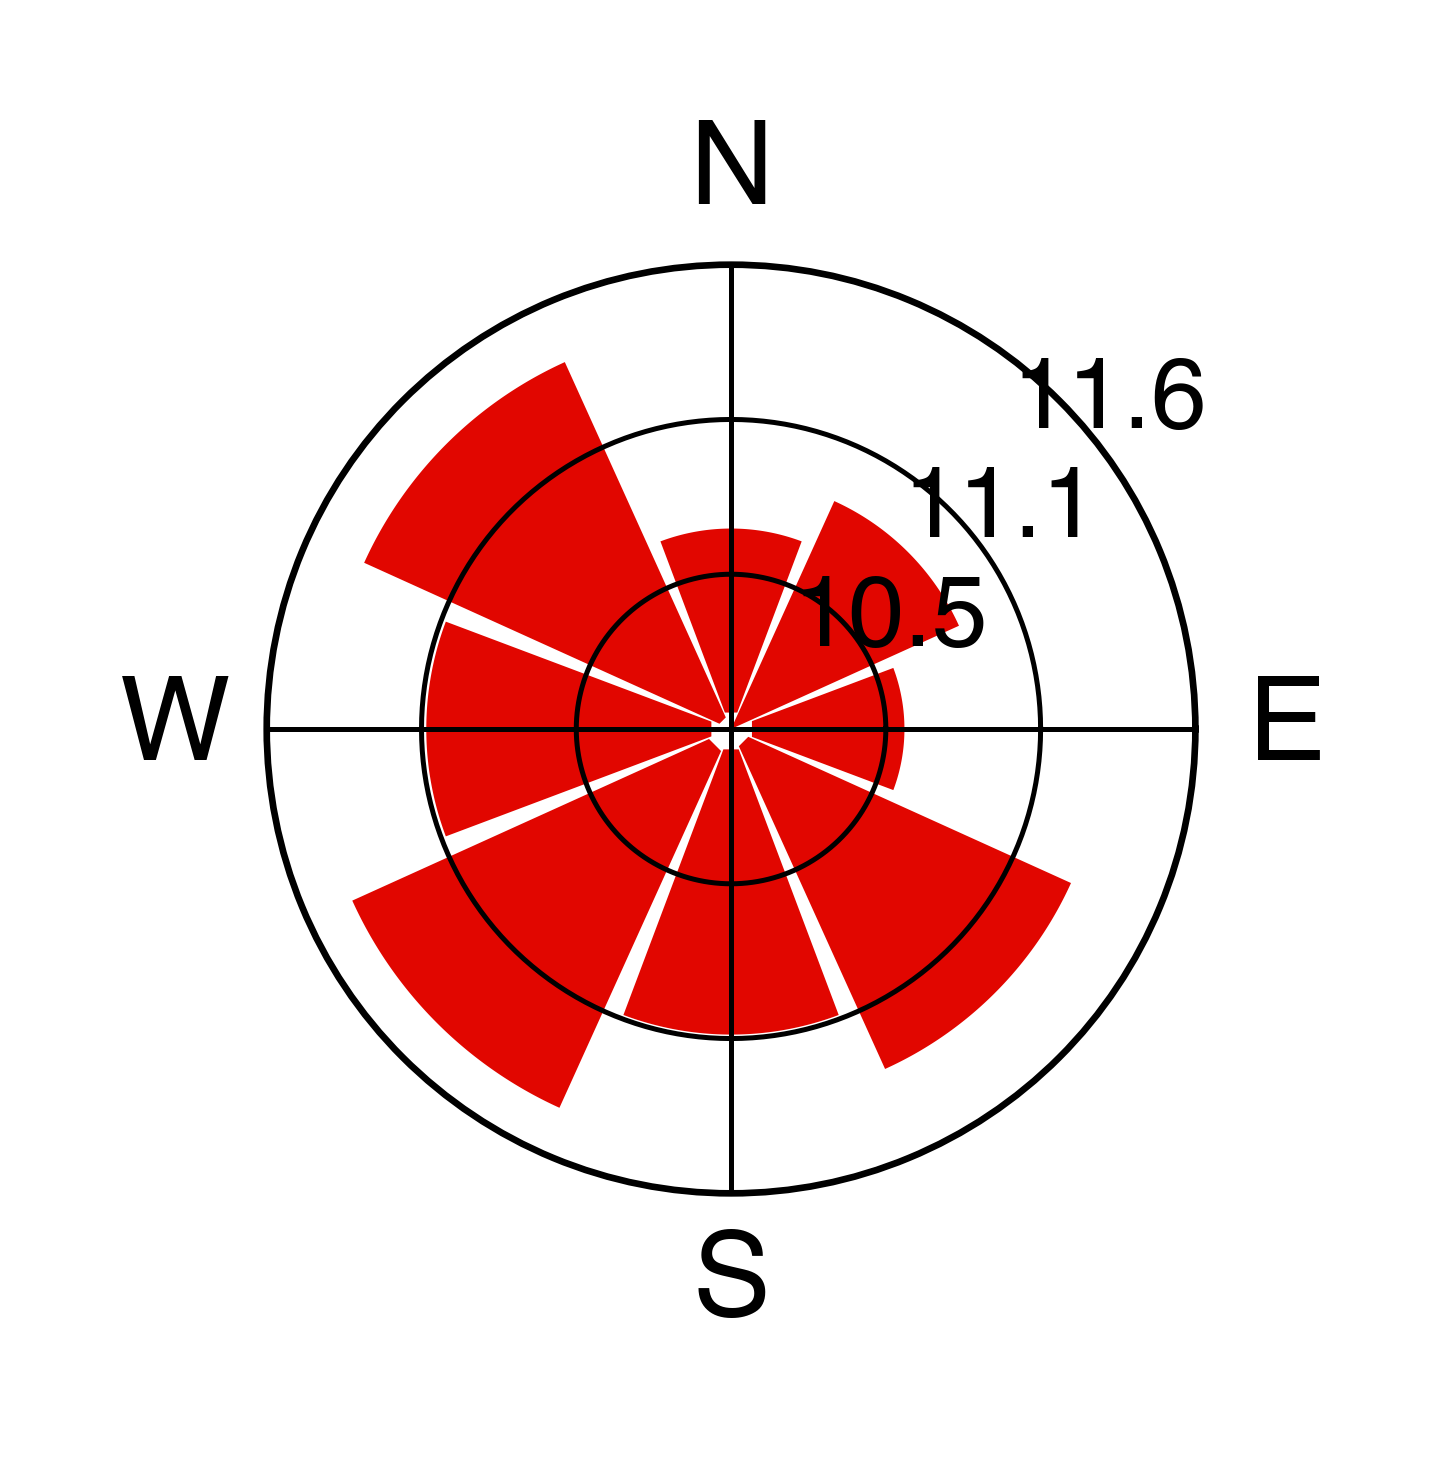

In [43]:
# Plot a neuron's firing rate by head direction.
savefig = True
overwrite = False
n_direc = 8
game_states = ['Encoding', 'Retrieval']

start_time = time()

# unit = 'U532_ses0-4-3'
# game_state = 'Encoding'
# _df = ols_pairs.query("(testvar=='head_direc') & (subj_sess_unit=='{}') & (gameState=='{}')".format(unit, game_state))
_df = ols_pairs.query("(testvar=='head_direc') & (full=='full') & (sig_holm==True) & (subj_sess=='U537_ses0')")
# units = ['U518_ses1-43-2', 'U518_ses1-67-2', 'U518_ses1-38-1', 'U521_ses0-21-1', 'U532_ses0-8-2', 'U532_ses0-4-3']
# _df = ols_pairs.query("(testvar=='head_direc') & (full=='full') & (subj_sess_unit=={}) & (gameState=={})".format(units, game_states))
for idx, row in _df.iterrows():
    subj_sess = row['subj_sess']
    neuron = row['neuron']
    game_state = row['gameState']
    
    fig, ax = plot_firing_hd(subj_sess, neuron, game_state, n_direc=n_direc, show_center_rlabel=False,
                             font={'tick': 6, 'label': 7}, bar_lw=0, bar_width=0.72,# bar_ec='w', #
                             grid_lw=0.3, grid_linestyle='-', rlabel_pad=-0.02)

    if savefig:
        chan, unit = neuron.split('-')
        hemroi = spike_preproc.roi_lookup(subj_sess, chan)
        filename = op.join(proj_dir, 'figs', 'plot_navigation', 
                           '{}-CSC{}-unit{}-{}-{}-hd_firing.pdf'.format(subj_sess, chan, unit, hemroi, game_state))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight')

print('{}-{}, {}, Z = {:.1f}, sig = {}'.format(subj_sess, neuron, game_state, row['z_lr'], row['sig_holm']))
print('Done in {:.1f}s'.format(time() - start_time))
fig.show()

U536_ses0-76-1, Retrieval, Z = 5.2, sig = True


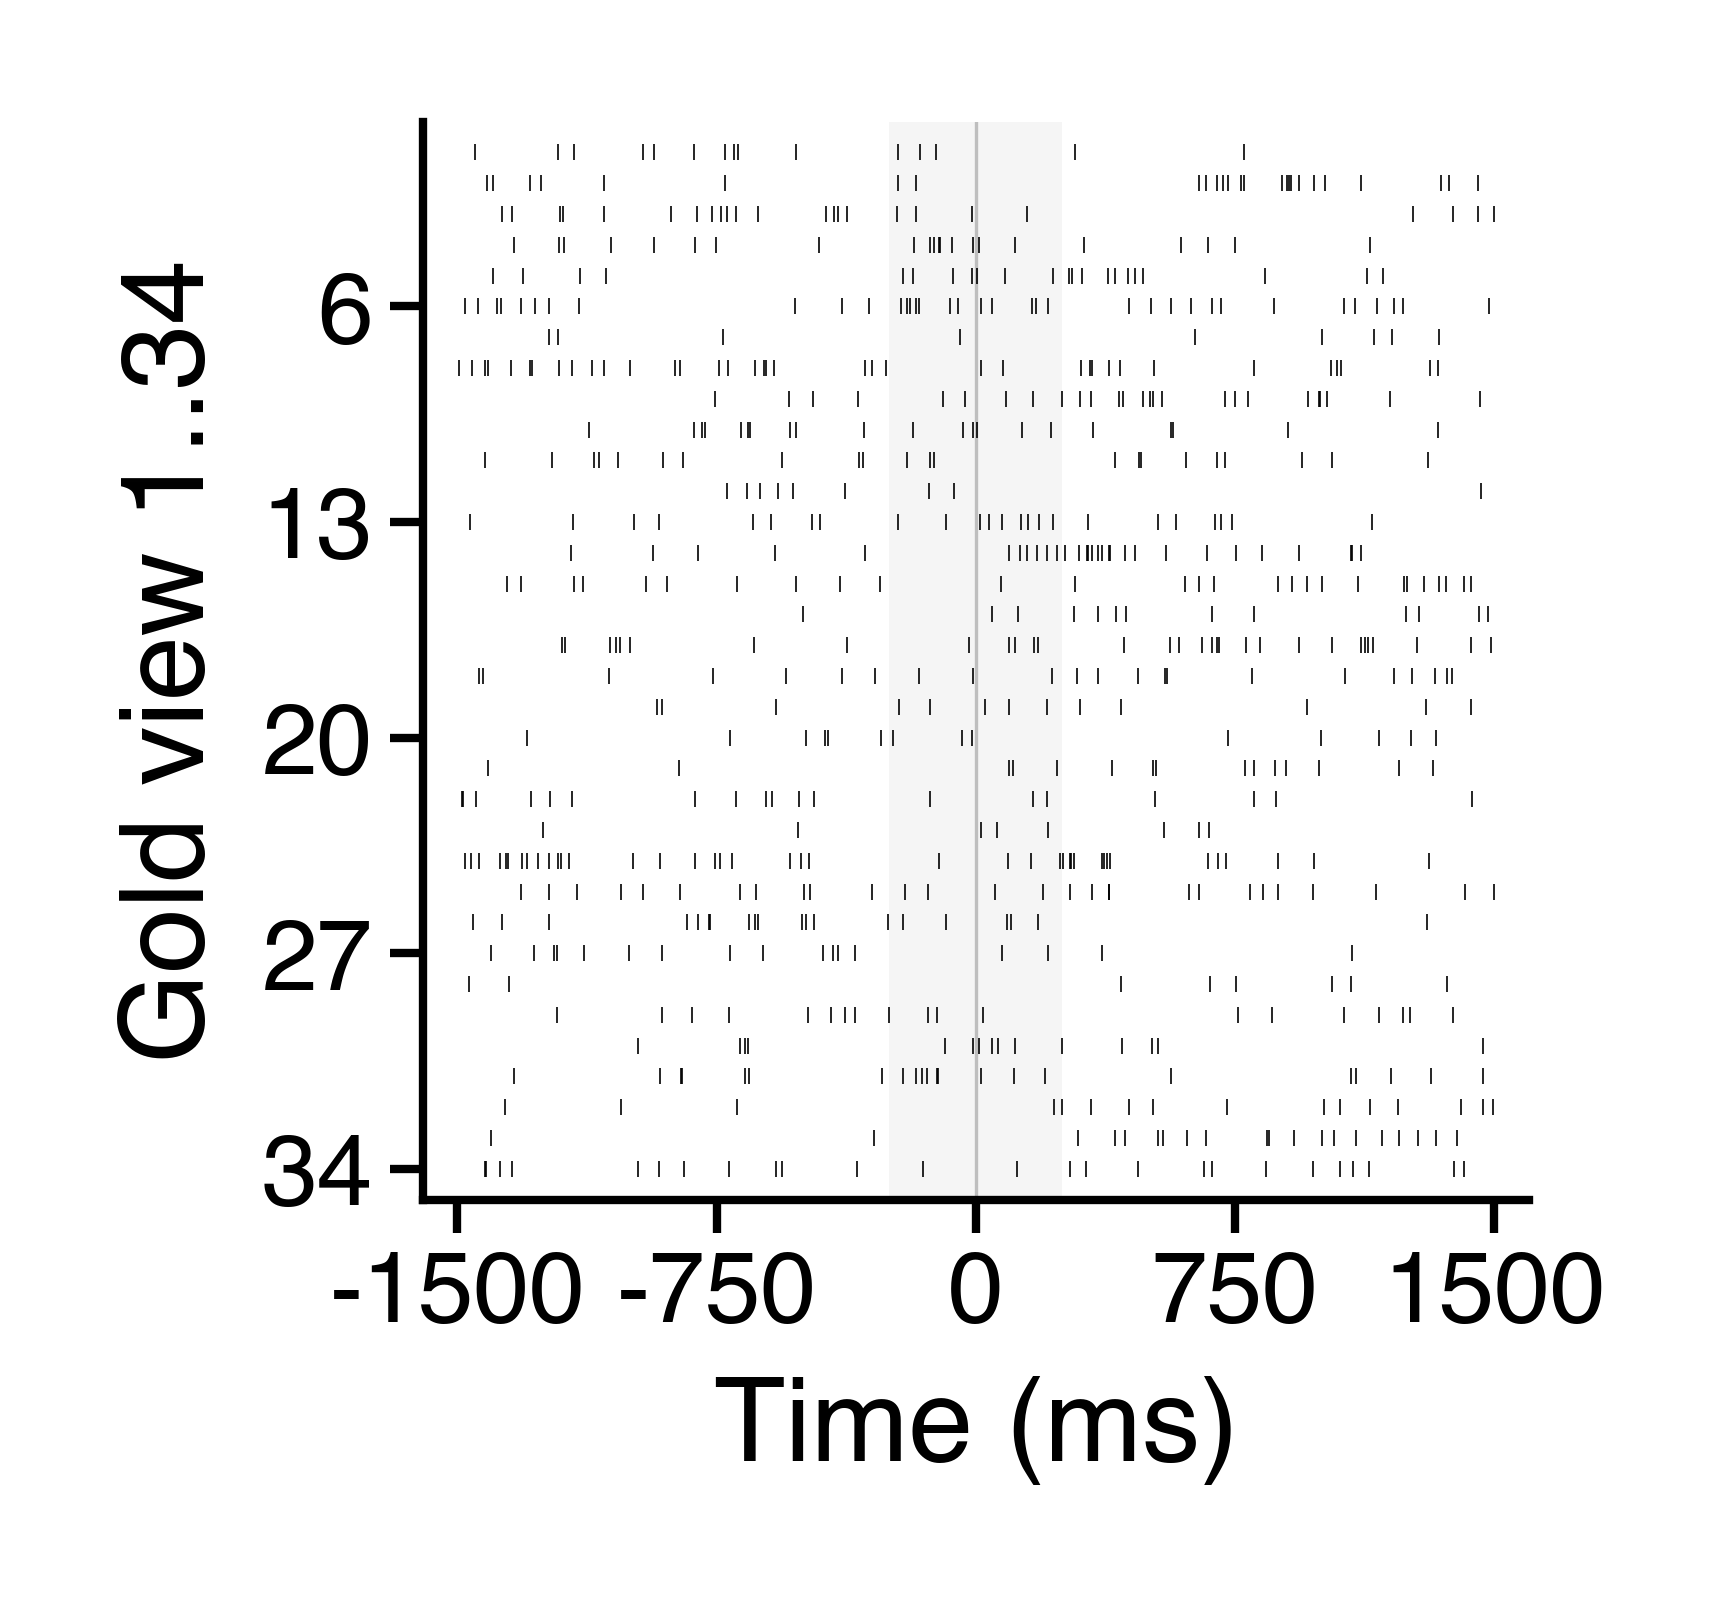

In [100]:
subj_sess = 'U527_ses0'
neuron = '45-1'
game_state = 'Retrieval'
savefig = True
overwrite = True

# _df = ols_pairs.query("(subj_sess=='{}') & (neuron=='{}') & (gameState=='{}') & (full=='full') & (testvar=='gold_in_view')"
#                       .format(subj_sess, neuron, game_state))
_df = ols_pairs.query("(testvar=='time') & (full=='full') & (sig_holm==True) & (subj_sess=='U536_ses0')")
# units = ['U518_ses1-43-2', 'U518_ses1-67-2', 'U518_ses1-38-1', 'U521_ses0-21-1', 'U532_ses0-8-2', 'U532_ses0-4-3']
# _df = ols_pairs.query("(testvar=='time') & (full=='full') & (subj_sess_unit=={}) & (gameState=={})".format(units, game_states))
for idx, row in _df.iterrows():
    subj_sess = row['subj_sess']
    neuron = row['neuron']
    game_state = row['gameState']
    
    fig, ax = gold_view_raster(subj_sess,
                               neuron,
                               game_state,
                               plot_labels=True)
    
    if savefig:
        chan, unit = neuron.split('-')
        hemroi = spike_preproc.roi_lookup(subj_sess, chan)
        filename = op.join(proj_dir, 'figs', 'plot_navigation',
                           '{}-CSC{}-unit{}-{}-{}-gold_firing.pdf'.format(subj_sess, chan, unit, hemroi, game_state))
        if overwrite or not op.exists(filename):
            fig.savefig(filename, format='pdf', bbox_inches='tight')

print('{}-{}, {}, Z = {:.1f}, sig = {}'.format(subj_sess, neuron, game_state, row['z_lr'], row['sig_holm']))
fig.show()

# Neural coding strength between behav. parameter pairs

In [45]:
# Compare each neuron's time coding strength between game state pairs.
sig_col = 'sig_holm'
game_state_pairs = [('Encoding', 'Encoding'),
                    ('Retrieval', 'Retrieval'),
                    ('Encoding', 'Retrieval')]
testvar_pairs = [('time', 'time'),
                 ('place', 'place'),
                 ('head_direc', 'head_direc'),
                 ('base_in_view', 'base_in_view'),
                 ('gold_in_view', 'gold_in_view'),
                 ('time', 'place'),
                 ('time', 'head_direc'),
                 ('time', 'base_in_view'),
                 ('time', 'gold_in_view'),
                 ('place', 'head_direc'),
                 ('place', 'base_in_view'),
                 ('place', 'gold_in_view'),
                 ('head_direc', 'base_in_view'),
                 ('head_direc', 'gold_in_view'),
                 ('base_in_view', 'gold_in_view')]

cols = ['subj_sess', 'neuron', 'gameState1', 'gameState2', 'testvar1', 'testvar2', 'zlr1', 'zlr2', 'sig1', 'sig2']
subj_sess_units = list(np.unique(ols_pairs['subj_sess_unit']))
param_strength = []
for subj_sess_unit in subj_sess_units:
    subj_sess, chan, unit = subj_sess_unit.split('-')
    neuron = '{}-{}'.format(chan, unit)
    for game_state_pair in game_state_pairs:
        gs1, gs2 = game_state_pair
        for tv1, tv2 in testvar_pairs:
            qry1 = "(subj_sess_unit=='{}') & (gameState=='{}') & (testvar=='{}') & (full=='full')".format(subj_sess_unit, gs1, tv1)
            qry2 = "(subj_sess_unit=='{}') & (gameState=='{}') & (testvar=='{}') & (full=='full')".format(subj_sess_unit, gs2, tv2)
            param_strength.append([subj_sess,
                                   neuron,
                                   gs1,
                                   gs2,
                                   tv1,
                                   tv2,
                                   ols_pairs.query(qry1).iloc[0]['z_lr'], 
                                   ols_pairs.query(qry2).iloc[0]['z_lr'],
                                   ols_pairs.query(qry1).iloc[0][sig_col], 
                                   ols_pairs.query(qry2).iloc[0][sig_col]])
        
param_strength = pd.DataFrame(param_strength, columns=cols)
param_strength.insert(0, 'subj_sess_unit', param_strength.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1))

# Determine if each neuron is a time cell, place cell, both, or neither.
param_strength['sig_state'] = 0
param_strength.loc[(param_strength['sig1']==True) & (param_strength['sig2']==False), 'sig_state'] = 2
param_strength.loc[(param_strength['sig1']==False) & (param_strength['sig2']==True), 'sig_state'] = 3
param_strength.loc[(param_strength['sig1']==True) & (param_strength['sig2']==True), 'sig_state'] = 1

print('param_strength:', param_strength.shape)

In [13]:
param_strength.head()

subj_sess_unit  subj_sess neuron gameState1 gameState2      testvar1  \
0  U518_ses0-11-1  U518_ses0   11-1   Encoding   Encoding          time   
1  U518_ses0-11-1  U518_ses0   11-1   Encoding   Encoding         place   
2  U518_ses0-11-1  U518_ses0   11-1   Encoding   Encoding    head_direc   
3  U518_ses0-11-1  U518_ses0   11-1   Encoding   Encoding  base_in_view   
4  U518_ses0-11-1  U518_ses0   11-1   Encoding   Encoding  gold_in_view   

       testvar2      zlr1      zlr2   sig1   sig2  sig_state  
0          time -0.088040 -0.088040  False  False          0  
1         place  1.023567  1.023567  False  False          0  
2    head_direc -0.307546 -0.307546  False  False          0  
3  base_in_view -0.202968 -0.202968  False  False          0  
4  gold_in_view -0.462467 -0.462467  False  False          0

time place 0.13333333333333333 4.152218765705752 0.000999000999000999
time head_direc 0.04040404040404041 0.4299028108184574 0.4145854145854146
time gold_in_view 0.0625 0.9743590704987474 0.23076923076923078
time base_in_view 0.05454545454545454 0.7515890692088847 0.2727272727272727


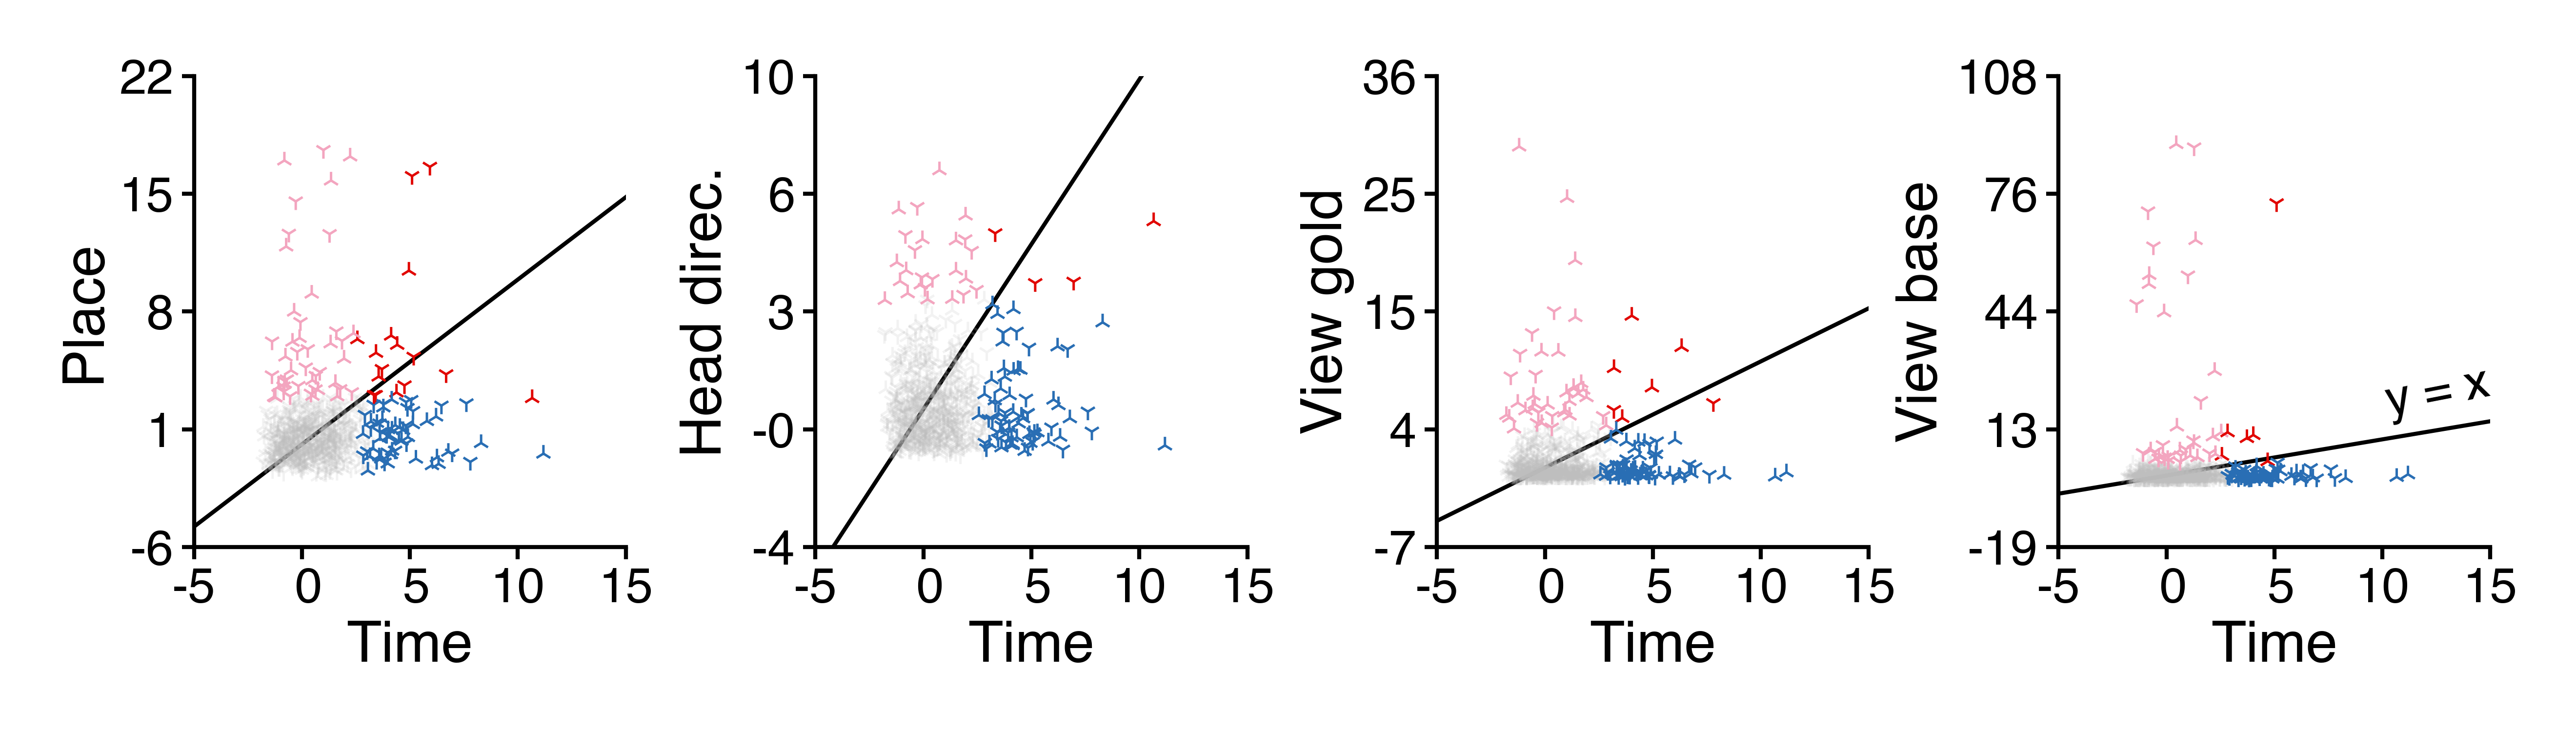

In [19]:
# Plot Z-scored likelihood ratios for behavioral variable pairs.
savefig = False
overwrite = False
add_legend = False
n_perm = 1000

# Plot params.
figsize = (colws['2-2/3'], colws['2-2/3']/4)
font = {'tick': 6, 'label': 7, 'annot': 6}
spine_lw = 0.5
marker_size = 0.5
marker_lw = 0.3
_testvar_pairs = [('time', 'place'),
                  ('time', 'head_direc'),
                  ('time', 'gold_in_view'),
                  ('time', 'base_in_view'),]
fancy_labels = {'time': 'Time',
                'place': 'Place',
                'head_direc': 'Head direc.',
                'base_in_view': 'View base',
                'gold_in_view': 'View gold'}

cmap = {0: (190, 190, 190), # gray #bebebe
        1: (225, 6, 0), # red #e10600
        2: (41, 110, 180), # blue #296eb4
        3: (243, 165, 191)} # pink #f3a5bf
for k in cmap:
    cmap[k] = list(np.array(cmap[k])/255)

# Make the plot.
plt.close()
#fig, ax = plt.subplots(1, 4, figsize=(colws[2], colws[2]/4), dpi=1200)
fig, ax = plt.subplots(1, 4, figsize=figsize, dpi=1200)
ax = np.ravel(ax)

iax = 0
vmin = -3
vmax = 20
for tv1, tv2 in _testvar_pairs:
    qry1 = "(gameState1=='Encoding') & (gameState2=='Encoding') & (testvar1=='{}') & (testvar2=='{}')".format(tv1, tv2)
    qry2 = "(gameState1=='Retrieval') & (gameState2=='Retrieval') & (testvar1=='{}') & (testvar2=='{}')".format(tv1, tv2)
    _df = pd.concat((param_strength.query(qry1), param_strength.query(qry2)))
    jaccard = jaccard_score(_df['sig1'], _df['sig2'])
    jaccard, jaccard_z, pval = jaccard_permtest(_df['sig1'].copy().values, 
                                                _df['sig2'].copy().values,
                                                n_perm=n_perm)
    print(tv1, tv2, jaccard, jaccard_z, pval)
    _cmap = {_i: cmap[_i] for _i in _df['sig_state'].unique() if (_i!=0)}
    _min = np.floor(np.min(_df.dropna()['zlr1'].to_numpy())).astype(int)
    _max = np.ceil(np.max(_df.dropna()['zlr1'].to_numpy())).astype(int)
    xmin = _min - (0.2 * (_max - _min))
    xmax = _max + (0.2 * (_max - _min))
    _min = np.floor(np.min(_df.dropna()['zlr2'].to_numpy())).astype(int)
    _max = np.ceil(np.max(_df.dropna()['zlr2'].to_numpy())).astype(int)
    ymin = _min - (0.2 * (_max - _min))
    ymax = _max + (0.2 * (_max - _min))
    vmin = np.max((xmin, ymin))
    vmax = np.min((xmax, ymax))
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].tick_params(labelsize=font['tick'], pad=1, length=1.5, width=spine_lw)
    ax[iax].plot(np.linspace(vmin, vmax), np.linspace(vmin, vmax), color='k', lw=spine_lw, zorder=0)
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', style='gameState1',
                              data=_df.query("(sig_state==0)"), ax=ax[iax],
                              markers=['2', '1'], 
                              alpha=0.2, 
                              size=marker_size, 
                              linewidth=marker_lw, 
                              palette=[cmap[0]], 
                              edgecolor='face',
                              legend=False)
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', style='gameState1',
                              data=_df.query("(sig_state!=0)"), ax=ax[iax],
                              markers=['2', '1'], 
                              alpha=1, 
                              size=marker_size, 
                              linewidth=marker_lw, 
                              palette=_cmap, 
                              edgecolor='face',
                              legend=False)
    xticks = np.linspace(xmin, xmax, 5)
    yticks = np.linspace(ymin, ymax, 5)
    ax[iax].set_xlim([xmin, xmax])
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(['{:>2.0f}'.format(x) for x in xticks])
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(['{:>2.0f}'.format(x) for x in yticks])
    ax[iax].set_xlabel(fancy_labels[tv1], fontsize=font['label'], labelpad=1)
    ax[iax].set_ylabel(fancy_labels[tv2], fontsize=font['label'], labelpad=1)
    iax += 1

if add_legend:
    custom_lines = [Line2D([0], [0], lw=0, marker='2', color='k', label='Encoding', mew=marker_lw*1.5, ms=font['annot']-1),
                    Line2D([0], [0], lw=0, marker='1', color='k', label='Retrieval', mew=marker_lw*1.5, ms=font['annot']-1)]
    legend = ax[iax-1].legend(handles=custom_lines, fontsize=font['annot'], loc=1, bbox_to_anchor=(1.1, 1), handletextpad=0)

ax[iax-1].annotate('y = x', (0.75, 0.32), xycoords='axes fraction', fontsize=font['annot'], rotation=11)

fig.set_facecolor('w')
fig.tight_layout(pad=0)

if savefig:
    n_units = np.unique(_df.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['neuron']), axis=1)).size
    filename = op.join(proj_dir, 'figs', 'plot_navigation', 
                       'nav-time_vs_other_behav-zlr_ols_strength-{}units.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.set_rasterized(False) # rasterize for smaller file
        fig.savefig(filename, format='pdf', bbox_inches='tight')
            
fig.show()

time place 0.13333333333333333 4.23077309372329 0.001998001998001998
time head_direc 0.04040404040404041 0.4567934698327516 0.39760239760239763
time base_in_view 0.05454545454545454 0.6402668599886316 0.3226773226773227
time gold_in_view 0.0625 0.9962420264463495 0.21478521478521478
place head_direc 0.1375 5.8566619502118415 0.000999000999000999
place base_in_view 0.19540229885057472 7.966579155978592 0.000999000999000999
place gold_in_view 0.01904761904761905 -1.1079477842985819 0.938061938061938
head_direc base_in_view 0.028985507246376812 0.10878743409531894 0.5624375624375625
head_direc gold_in_view 0.0136986301369863 -0.7111390924852677 0.8731268731268731
base_in_view gold_in_view 0.023529411764705882 -0.5176465531606682 0.7842157842157842


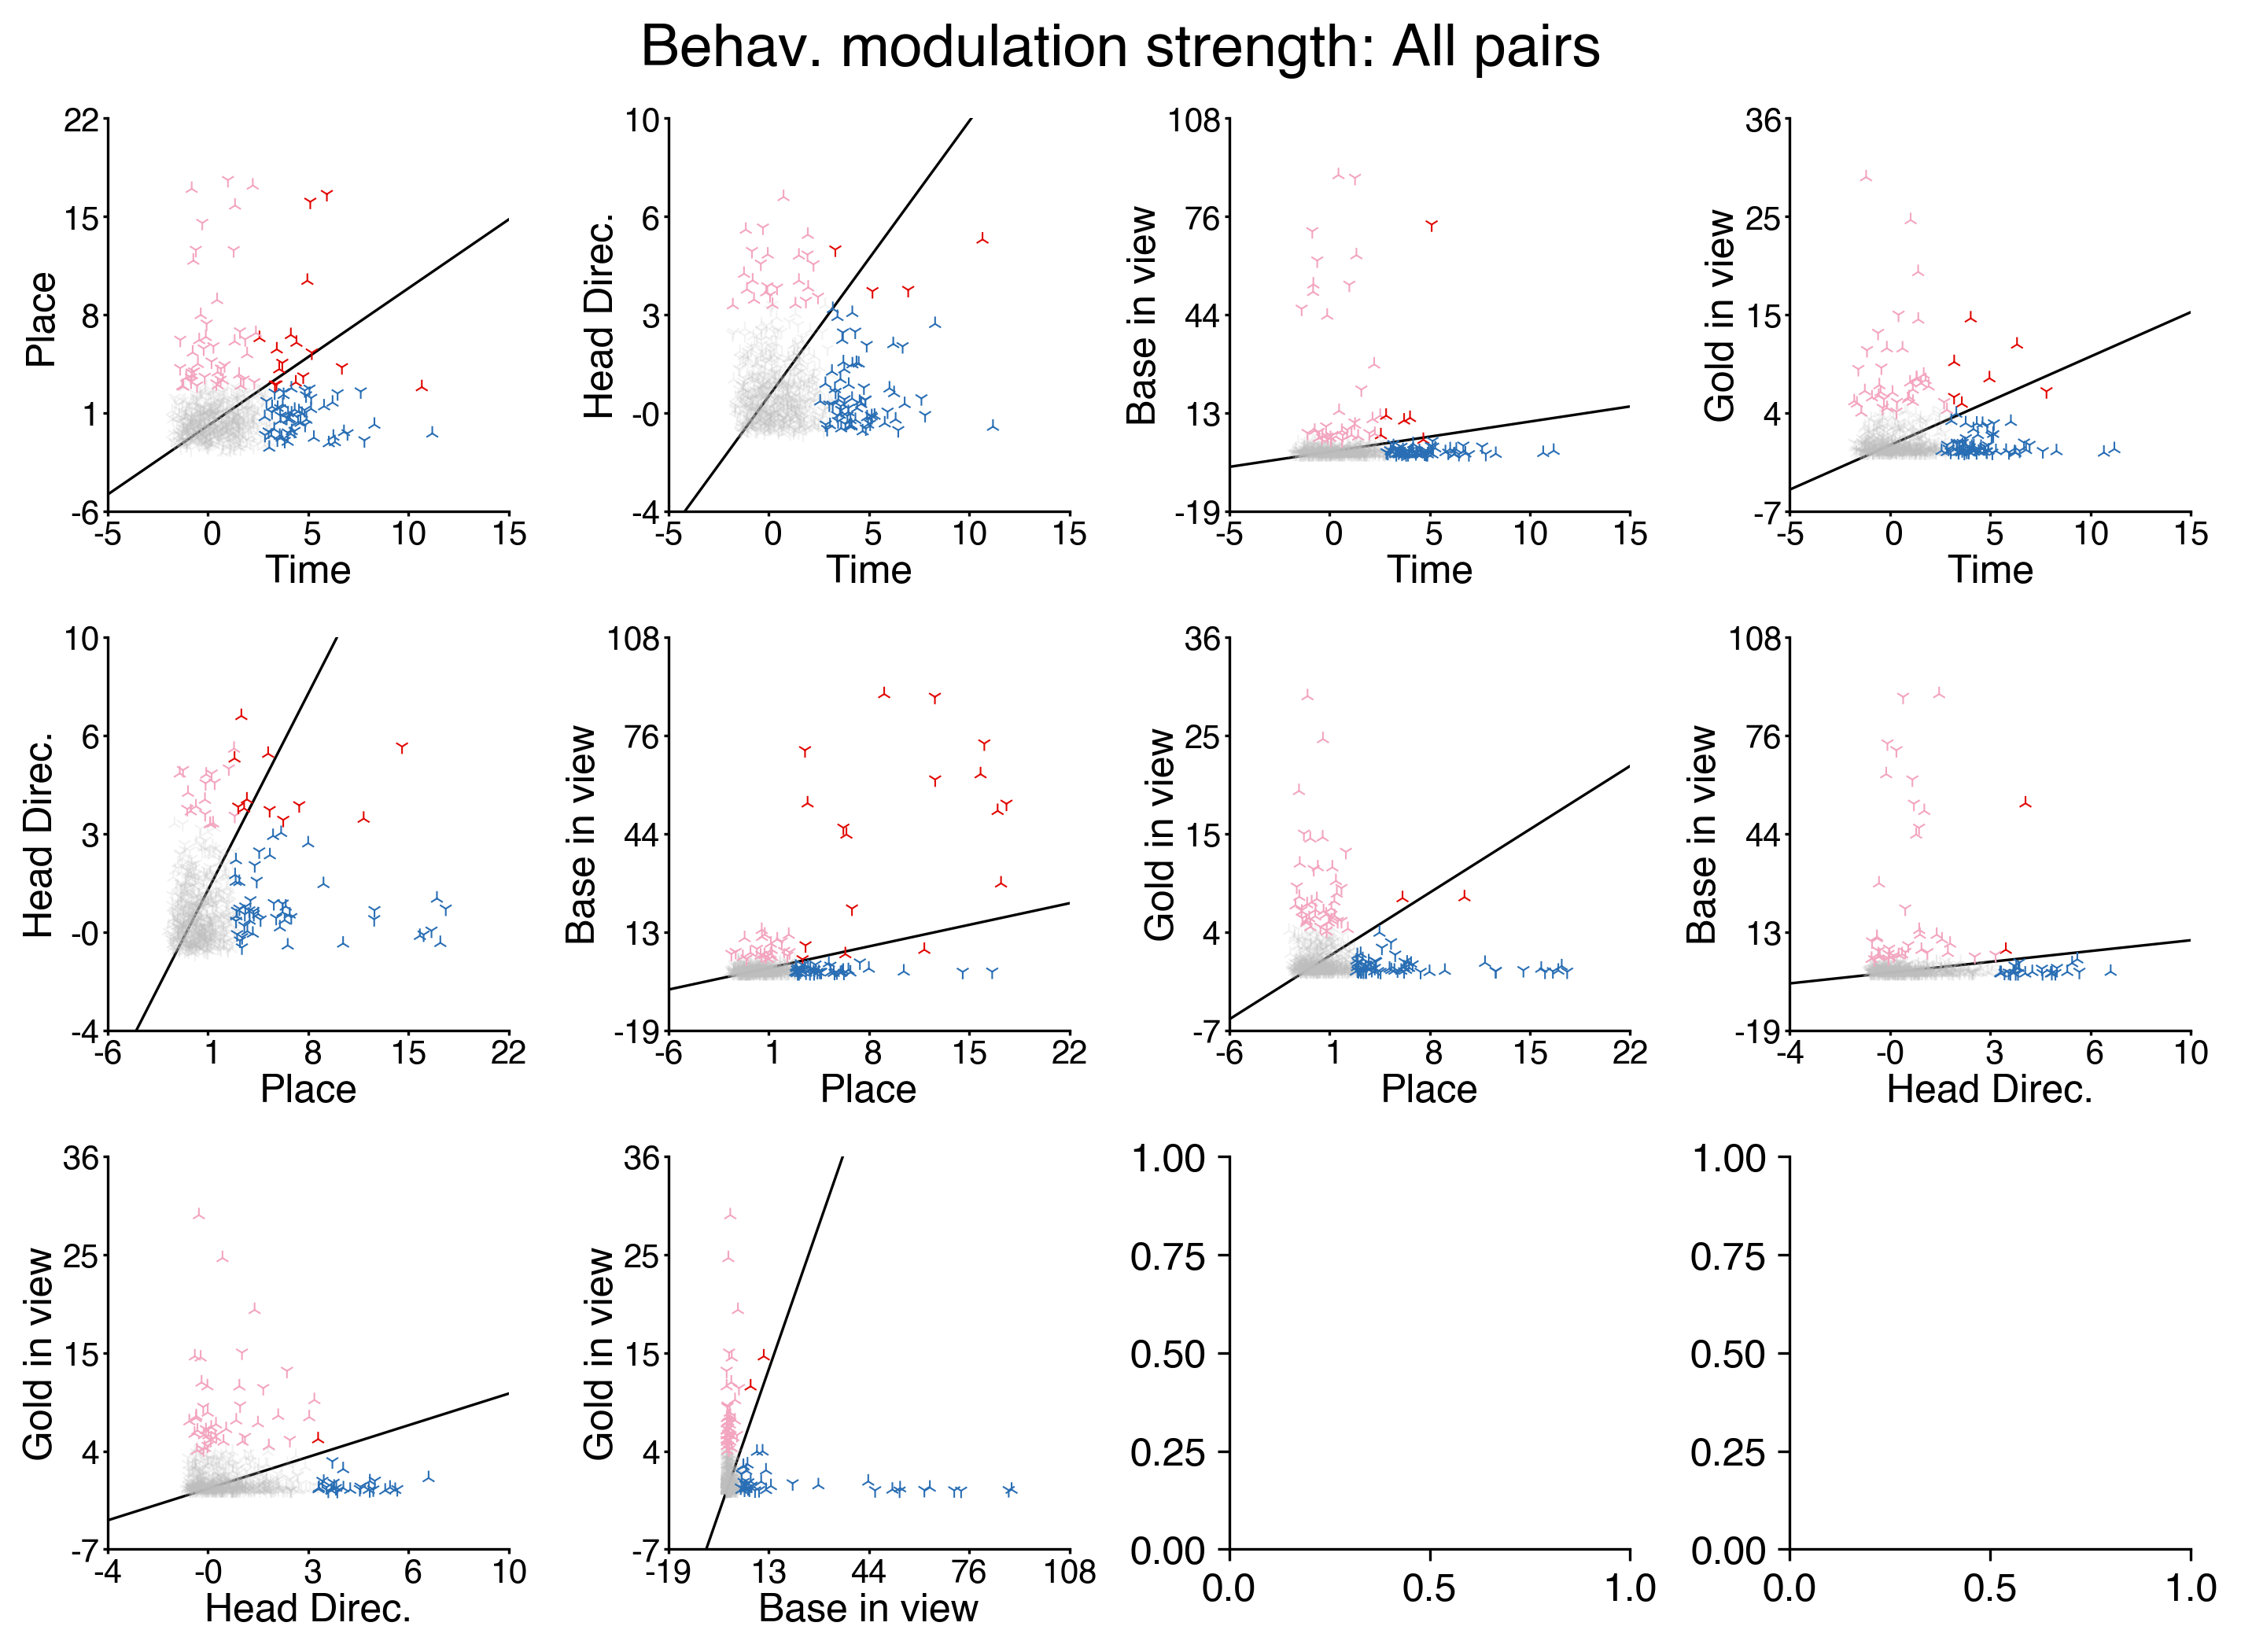

In [20]:
figsize = (9.6, 6.75)
font = {'tick': 6, 'label': 7, 'annot': 6}
spine_lw = 0.8
marker_size = 20
marker_lw = 0.5

# Plot Z-scored likelihood ratios for behavioral variable pairs.
plt.close()
fig, ax = plt.subplots(3, 4, figsize=figsize, dpi=300)
ax = np.ravel(ax)

font = {'tick': 10, 'label': 12, 'annot': 12, 'fig': 16}
fancy_labels = {'time': 'Time',
                'place': 'Place',
                'head_direc': 'Head Direc.',
                'base_in_view': 'Base in view',
                'gold_in_view': 'Gold in view'}
iax = 0
vmin = -3
vmax = 20
#for game_state in ['Encoding', 'Retrieval']:
for tv1, tv2 in testvar_pairs:
    if tv1 == tv2:
        continue
    qry1 = "(gameState1=='Encoding') & (gameState2=='Encoding') & (testvar1=='{}') & (testvar2=='{}')".format(tv1, tv2)
    qry2 = "(gameState1=='Retrieval') & (gameState2=='Retrieval') & (testvar1=='{}') & (testvar2=='{}')".format(tv1, tv2)
    _df = pd.concat((param_strength.query(qry1), param_strength.query(qry2)))
    jaccard = jaccard_score(_df['sig1'], _df['sig2'])
    jaccard, jaccard_z, pval = jaccard_permtest(_df['sig1'].copy().values, 
                                                _df['sig2'].copy().values,
                                                n_perm=n_perm)
    print(tv1, tv2, jaccard, jaccard_z, pval)
    _cmap = {_i: cmap[_i] for _i in _df['sig_state'].unique() if (_i!=0)}
    _min = np.floor(np.min(_df.dropna()['zlr1'].to_numpy())).astype(int)
    _max = np.ceil(np.max(_df.dropna()['zlr1'].to_numpy())).astype(int)
    xmin = _min - (0.2 * (_max - _min))
    xmax = _max + (0.2 * (_max - _min))
    _min = np.floor(np.min(_df.dropna()['zlr2'].to_numpy())).astype(int)
    _max = np.ceil(np.max(_df.dropna()['zlr2'].to_numpy())).astype(int)
    ymin = _min - (0.2 * (_max - _min))
    ymax = _max + (0.2 * (_max - _min))
    vmin = np.max((xmin, ymin))
    vmax = np.min((xmax, ymax))
    for axis in ['left', 'bottom']:
        ax[iax].spines[axis].set_linewidth(spine_lw)
    ax[iax].tick_params(labelsize=font['tick'], pad=1, length=1.5, width=spine_lw)
    ax[iax].plot(np.linspace(vmin, vmax), np.linspace(vmin, vmax), color='k', lw=spine_lw, zorder=0)
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', style='gameState1',
                              data=_df.query("(sig_state==0)"), ax=ax[iax],
                              markers=['2', '1'], 
                              alpha=0.2, 
                              s=marker_size, 
                              linewidth=marker_lw,
                              palette=[cmap[0]], 
                              edgecolor='face',
                              legend=False)
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', style='gameState1',
                              data=_df.query("(sig_state!=0)"), ax=ax[iax],
                              markers=['2', '1'], 
                              alpha=1, 
                              s=marker_size, 
                              linewidth=marker_lw, 
                              palette=_cmap, 
                              edgecolor='face',
                              legend=False)
    xticks = np.linspace(xmin, xmax, 5)
    yticks = np.linspace(ymin, ymax, 5)
    ax[iax].set_xlim([xmin, xmax])
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(['{:>2.0f}'.format(x) for x in xticks])
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(['{:>2.0f}'.format(x) for x in yticks])
    ax[iax].set_xlabel(fancy_labels[tv1], fontsize=font['label'], labelpad=1)
    ax[iax].set_ylabel(fancy_labels[tv2], fontsize=font['label'], labelpad=1)
    iax += 1
    
fig.suptitle('Behav. modulation strength: All pairs', fontsize=font['fig'] + 2, y=1.03)
fig.set_facecolor('w')
fig.tight_layout(w_pad=1, h_pad=1)
fig.show()

time time 0.1935483870967742 4.792129398011232 0.000999000999000999
place place 0.34782608695652173 10.549977206852876 0.000999000999000999
head_direc head_direc 0.07407407407407407 1.883106511186811 0.11588411588411589
base_in_view base_in_view 0.3548387096774194 11.791585487973764 0.000999000999000999
gold_in_view gold_in_view 0.07142857142857142 1.7645467946913296 0.11488511488511488
time place 0.07142857142857142 0.429421300854324 0.4065934065934066
time head_direc 0.05660377358490566 1.1540152873393255 0.2037962037962038
time base_in_view 0.0 -1.6433775195519094 1.0
time gold_in_view 0.03773584905660377 0.3936989295906274 0.4905094905094905
place head_direc 0.10256410256410256 2.851662880669499 0.023976023976023976
place base_in_view 0.1951219512195122 5.373311308862419 0.000999000999000999
place gold_in_view 0.0 -1.062364630684114 1.0
head_direc base_in_view 0.029411764705882353 0.09602897113393696 0.6133866133866134
head_direc gold_in_view 0.0 -0.7790859217129046 1.0
base_in_vie

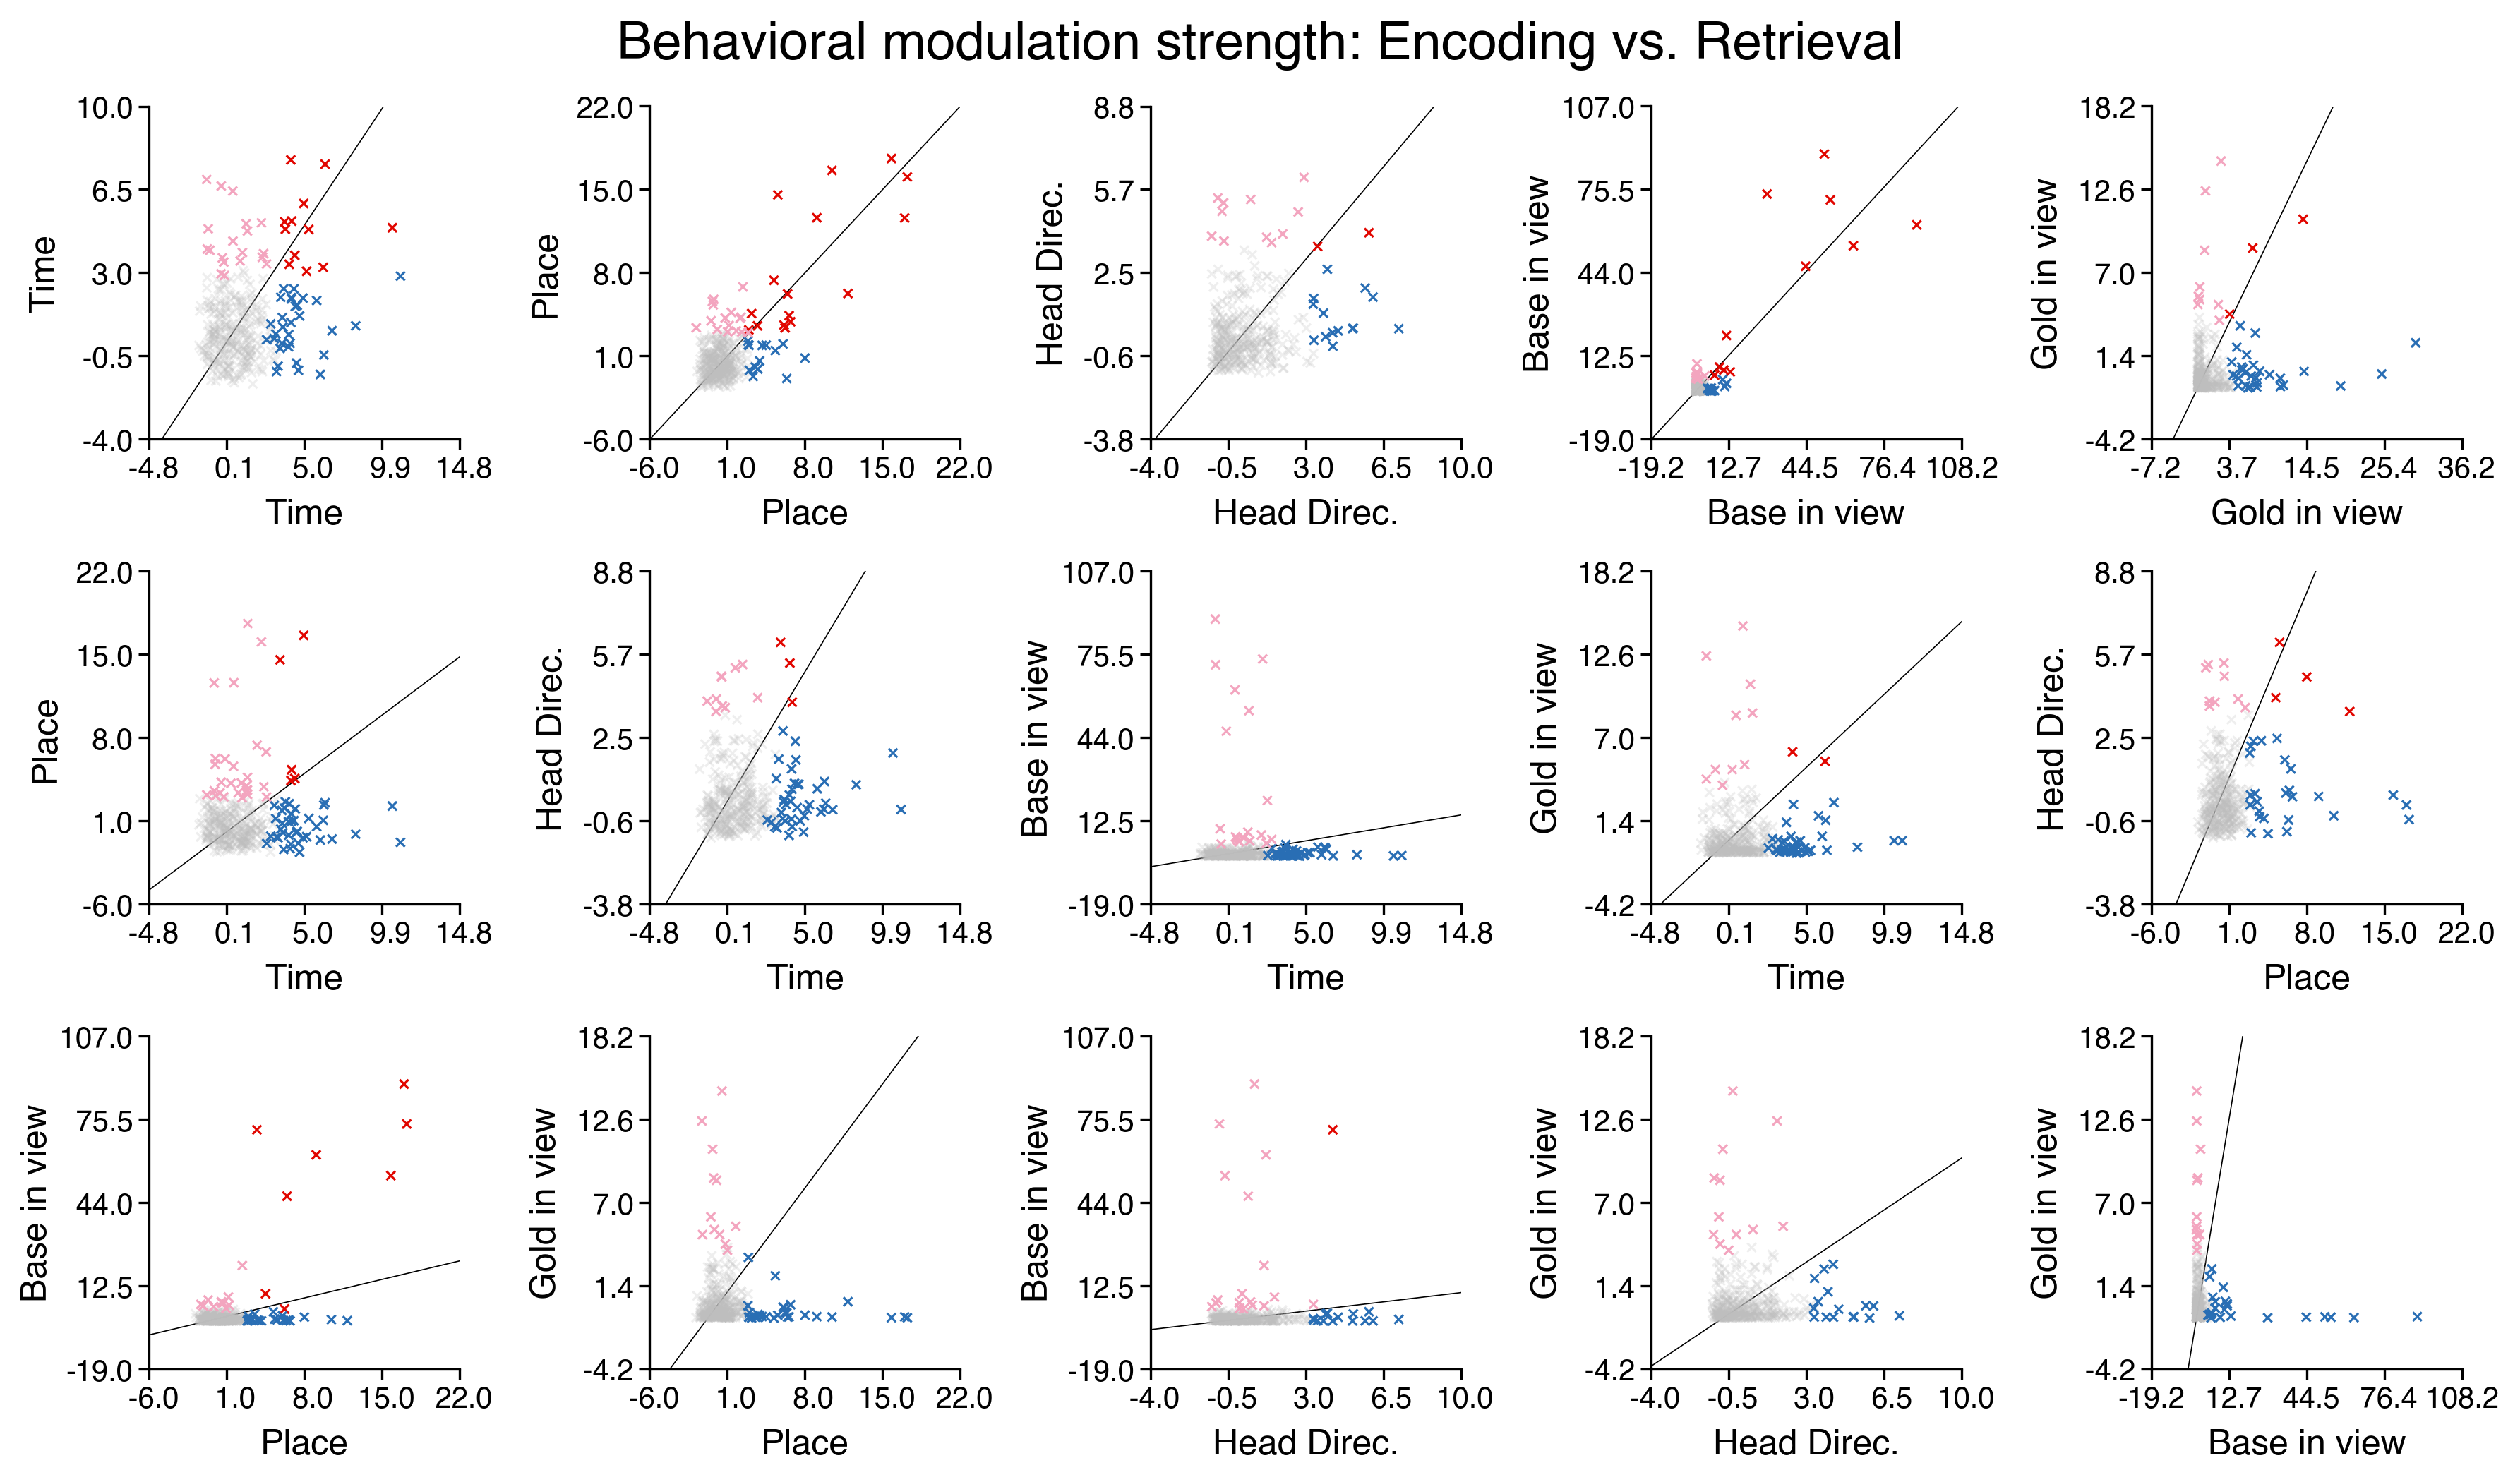

In [21]:
# Plot Z-scored likelihood ratios for behavioral variable pairs.
plt.close()
fig, ax = plt.subplots(3, 5, figsize=(12, 6.75), dpi=300)
ax = np.ravel(ax)

font = {'tick': 10, 'label': 12, 'annot': 12, 'fig': 16}
fancy_labels = {'time': 'Time',
                'place': 'Place',
                'head_direc': 'Head Direc.',
                'base_in_view': 'Base in view',
                'gold_in_view': 'Gold in view'}
iax = 0
vmin = -3
vmax = 20
for tv1, tv2 in testvar_pairs:
    qry = "(gameState1=='{}') & (gameState2=='{}') & (testvar1=='{}') & (testvar2=='{}')".format('Encoding', 'Retrieval', tv1, tv2)
    _df = param_strength.query(qry)
    jaccard = jaccard_score(_df['sig1'], _df['sig2'])
    jaccard, jaccard_z, pval = jaccard_permtest(_df['sig1'].copy().values, 
                                                _df['sig2'].copy().values,
                                                n_perm=n_perm)
    print(tv1, tv2, jaccard, jaccard_z, pval)
    _cmap = {_i: cmap[_i] for _i in _df['sig_state'].unique() if (_i!=0)}
    _min = np.floor(np.min(_df.dropna()['zlr1'].to_numpy())).astype(int)
    _max = np.ceil(np.max(_df.dropna()['zlr1'].to_numpy())).astype(int)
    xmin = _min - (0.2 * (_max - _min))
    xmax = _max + (0.2 * (_max - _min))
    _min = np.floor(np.min(_df.dropna()['zlr2'].to_numpy())).astype(int)
    _max = np.ceil(np.max(_df.dropna()['zlr2'].to_numpy())).astype(int)
    ymin = _min - (0.2 * (_max - _min))
    ymax = _max + (0.2 * (_max - _min))
    vmin = np.max((xmin, ymin))
    vmax = np.min((xmax, ymax))
    rho, pval = stats.spearmanr(_df.query("(sig_state!=0)")['zlr1'], _df.query("(sig_state!=0)")['zlr2'])
    ax[iax].plot(np.linspace(vmin, vmax), np.linspace(vmin, vmax), color='k', lw=0.4, zorder=0)
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', alpha=0.25, lw=0.4, marker='x',
                              palette=[cmap[0]], legend=False, 
                              data=_df.query("(sig_state==0)"), ax=ax[iax])
    ax[iax] = sns.scatterplot('zlr1', 'zlr2', hue='sig_state', alpha=1, lw=0.8, marker='x',
                              edgecolor='k', palette=_cmap, legend=False, 
                              data=_df.query("(sig_state!=0)").sort_values('sig_state'), ax=ax[iax])
    ax[iax].set_xlim([xmin, xmax])
    ax[iax].set_ylim([ymin, ymax])
    ax[iax].tick_params(labelsize=font['tick'], pad=2)
    xticks = np.linspace(xmin, xmax, 5)
    yticks = np.linspace(ymin, ymax, 5)
    ax[iax].set_xticks(xticks)
    ax[iax].set_xticklabels(['{:>5.1f}'.format(x) for x in xticks])
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(['{:>5.1f}'.format(x) for x in yticks])
    ax[iax].set_xlabel(fancy_labels[tv1], fontsize=font['label'], labelpad=5)
    ax[iax].set_ylabel(fancy_labels[tv2], fontsize=font['label'], labelpad=2)
#     ax[iax].annotate(r'$\rho = {:.2f}$'.format(rho), (0.1, 0.9), xycoords='axes fraction',
#                      color='k', fontsize=font['tick']-2)
    iax += 1
    
fig.suptitle('Behavioral modulation strength: Encoding vs. Retrieval', fontsize=font['fig'] + 2, y=1.03)
fig.set_facecolor('w')
fig.tight_layout(w_pad=1, h_pad=1)
fig.show()

# Mean firing over time, all navigation time cells

In [5]:
ols_pairs.columns

Index(['subj', 'subj_sess', 'subj_sess_unit', 'neuron', 'hem', 'roi',
       'roi_gen2', 'roi_gen3', 'roi_gen4', 'roi_gen5', 'gameState', 'testvar',
       'full', 'llf_full', 'lr', 'z_lr', 'emp_pval', 'spike_mat', 'mean_frs',
       'sem_frs', 'fr_mean', 'fr_max', 'fr_max_ind', 'fr_max_ind4',
       'fr_max_ind5', 'fr_max_ind10', 'sparsity', 'sig', 'sig_holm',
       'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax',
       'beta_abs_max'],
      dtype='object')

In [23]:
def _combine_time_bins(spike_mat, bins=10):
    """Return sum of spikes across trials within each time bin."""
    spike_mat = np.array(spike_mat)
    if len(spike_mat.shape) == 2:
        return np.array([v.sum() for v in np.split(np.sum(spike_mat, axis=0), bins)])
    else:
        return None

In [26]:
ols_pairs.columns

Index(['subj', 'subj_sess', 'subj_sess_unit', 'neuron', 'hem', 'roi',
       'roi_gen2', 'roi_gen3', 'roi_gen4', 'roi_gen5', 'gameState', 'testvar',
       'full', 'llf_full', 'lr', 'z_lr', 'emp_pval', 'spike_mat', 'mean_frs',
       'sem_frs', 'fr_mean', 'fr_max', 'fr_max_ind', 'fr_max_ind4',
       'fr_max_ind5', 'fr_max_ind10', 'sparsity', 'sig', 'sig_holm',
       'beta_argmin', 'beta_min', 'beta_argmax', 'beta_max', 'beta_abs_argmax',
       'beta_abs_max', 'sig_pos'],
      dtype='object')

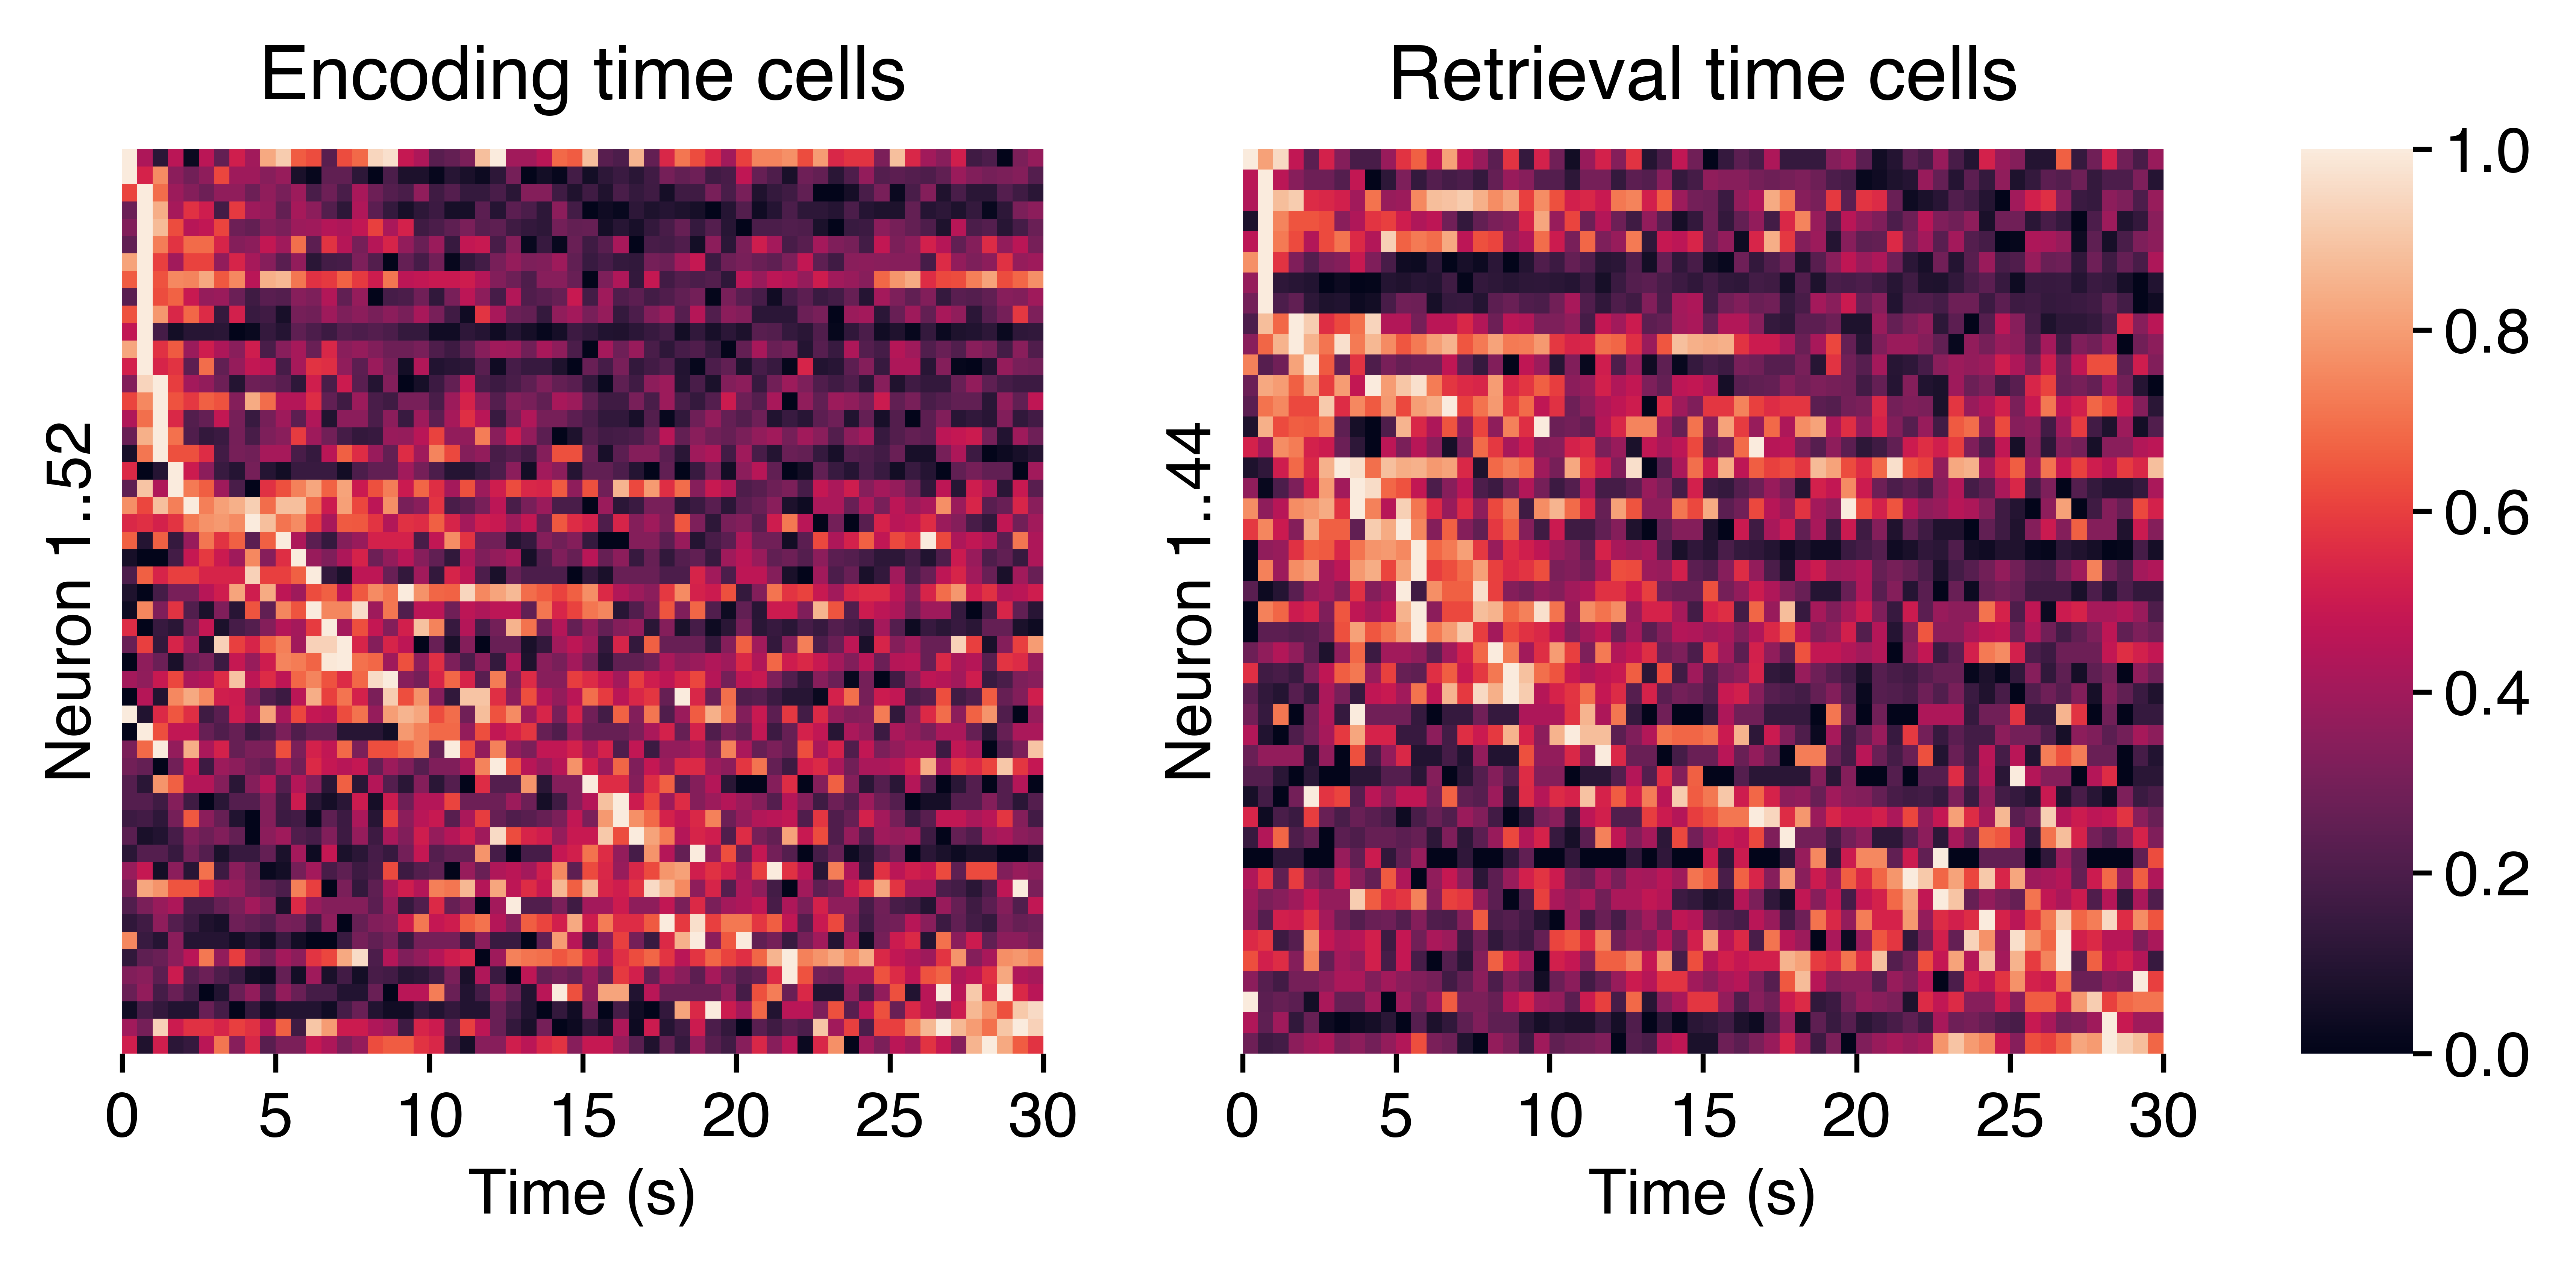

In [28]:
savefig = 1
overwrite = 1
grid_shp = (15, 37)
figsize = (colws['1'], colws['1']*(grid_shp[0]/grid_shp[1]))
dpi = 1200

# Plot the mean timecourse for all Encoding and Retrieval neurons.
spikes_by_time = od([('Encoding', []), ('Retrieval', [])])
for game_state in ['Encoding', 'Retrieval']:
    mean_spikes = []
    qry = "(sig==True) & (beta_abs_max>0) & (testvar=='time') & (gameState=='{}')".format(game_state)
    for idx, row in ols_pairs.query(qry).sort_values(['beta_abs_argmax', 'fr_max_ind', 'sparsity']).iterrows():
        subj_sess = row['subj_sess']
        chan, unit = row['neuron'].split('-')
        spikes_by_time[game_state].append(_combine_time_bins(row['spike_mat'], 60)) # time_bin; mean over trials
    spikes_by_time[game_state] = np.array(spikes_by_time[game_state]) # neuron x time_bin

plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 18), rowspan=grid_shp[0], colspan=15),
      plt.subplot2grid(grid_shp, (0, 35), rowspan=grid_shp[0], colspan=2)]
ax = np.ravel(ax)

font = {'tick': 10, 'label': 10, 'annot': 10, 'fig': 12}

ax_labels = {'Encoding': 'Encoding',
             'Retrieval': 'Retrieval'}
ax_titles = {'Encoding': 'Encoding time cells',
             'Retrieval': 'Retrieval time cells'}

game_states = ['Encoding', 'Retrieval']
n_neurons = []
for i, game_state in enumerate(game_states):
    # Concat firing rates across trial phases, for each neuron.
    ii = i
    
    #xsort = np.argsort(np.argmax(spikes_by_time[game_state], axis=1))
    fr_mat = minmax_scale(spikes_by_time[game_state], axis=1)#[xsort, :]
    n_neurons.append(fr_mat.shape[0])
    
    # Plot the firing rate heatmap.
    xticks = np.arange(0, fr_mat.shape[1]+1, 10)
    xticklabels = np.arange(0, (fr_mat.shape[1]+1)/2, 5, dtype=np.int)
    vmin = 0
    vmax = 1
    add_cbar = False
    if ii == len(ax) - 2:
        add_cbar = True
    ax[ii] = sns.heatmap(fr_mat, ax=ax[ii], vmin=vmin, vmax=vmax, cmap='rocket',
                         square=False, cbar=add_cbar, cbar_ax=ax[ii+1])
    ax[i].tick_params(axis='x', which='both', length=3, pad=3)
    ax[ii].tick_params(axis='y', which='both', length=0, pad=3)
    ax[ii].set_xticks(xticks)
    ax[ii].set_xticklabels(xticklabels, 
                           fontsize=font['tick'], rotation=0)
    ax[ii].set_xlabel('Time (s)', fontsize=font['label'], labelpad=3)
    ax[ii].set_yticks([])
    ax[ii].set_ylabel('Neuron 1..{}'.format(n_neurons[-1]), fontsize=font['label'], labelpad=3)
    ax[ii].set_title(ax_titles[game_state], pad=8, fontsize=font['fig'])
    
    if add_cbar:
        cbar = ax[ii].collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], length=3, pad=2)
        cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        cbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        #cbar.set_label('Norm. firing rate', fontsize=font['label'], labelpad=2)

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_navigation',
                       'navigation_time_cells-{}encoding-{}retrieval-{}units.pdf'
                       .format(spikes_by_time['Encoding'].shape[0], spikes_by_time['Retrieval'].shape[0], ols_pairs['subj_sess_unit'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
    
fig.show()

# Individual cell time and place plots

In [92]:
reload(time_cell_plots)

<module 'time_cells.time_cell_plots' from '/home1/dscho/code/projects/time_cells/time_cell_plots.py'>

U526_ses0-44-1, Encoding_Retrieval


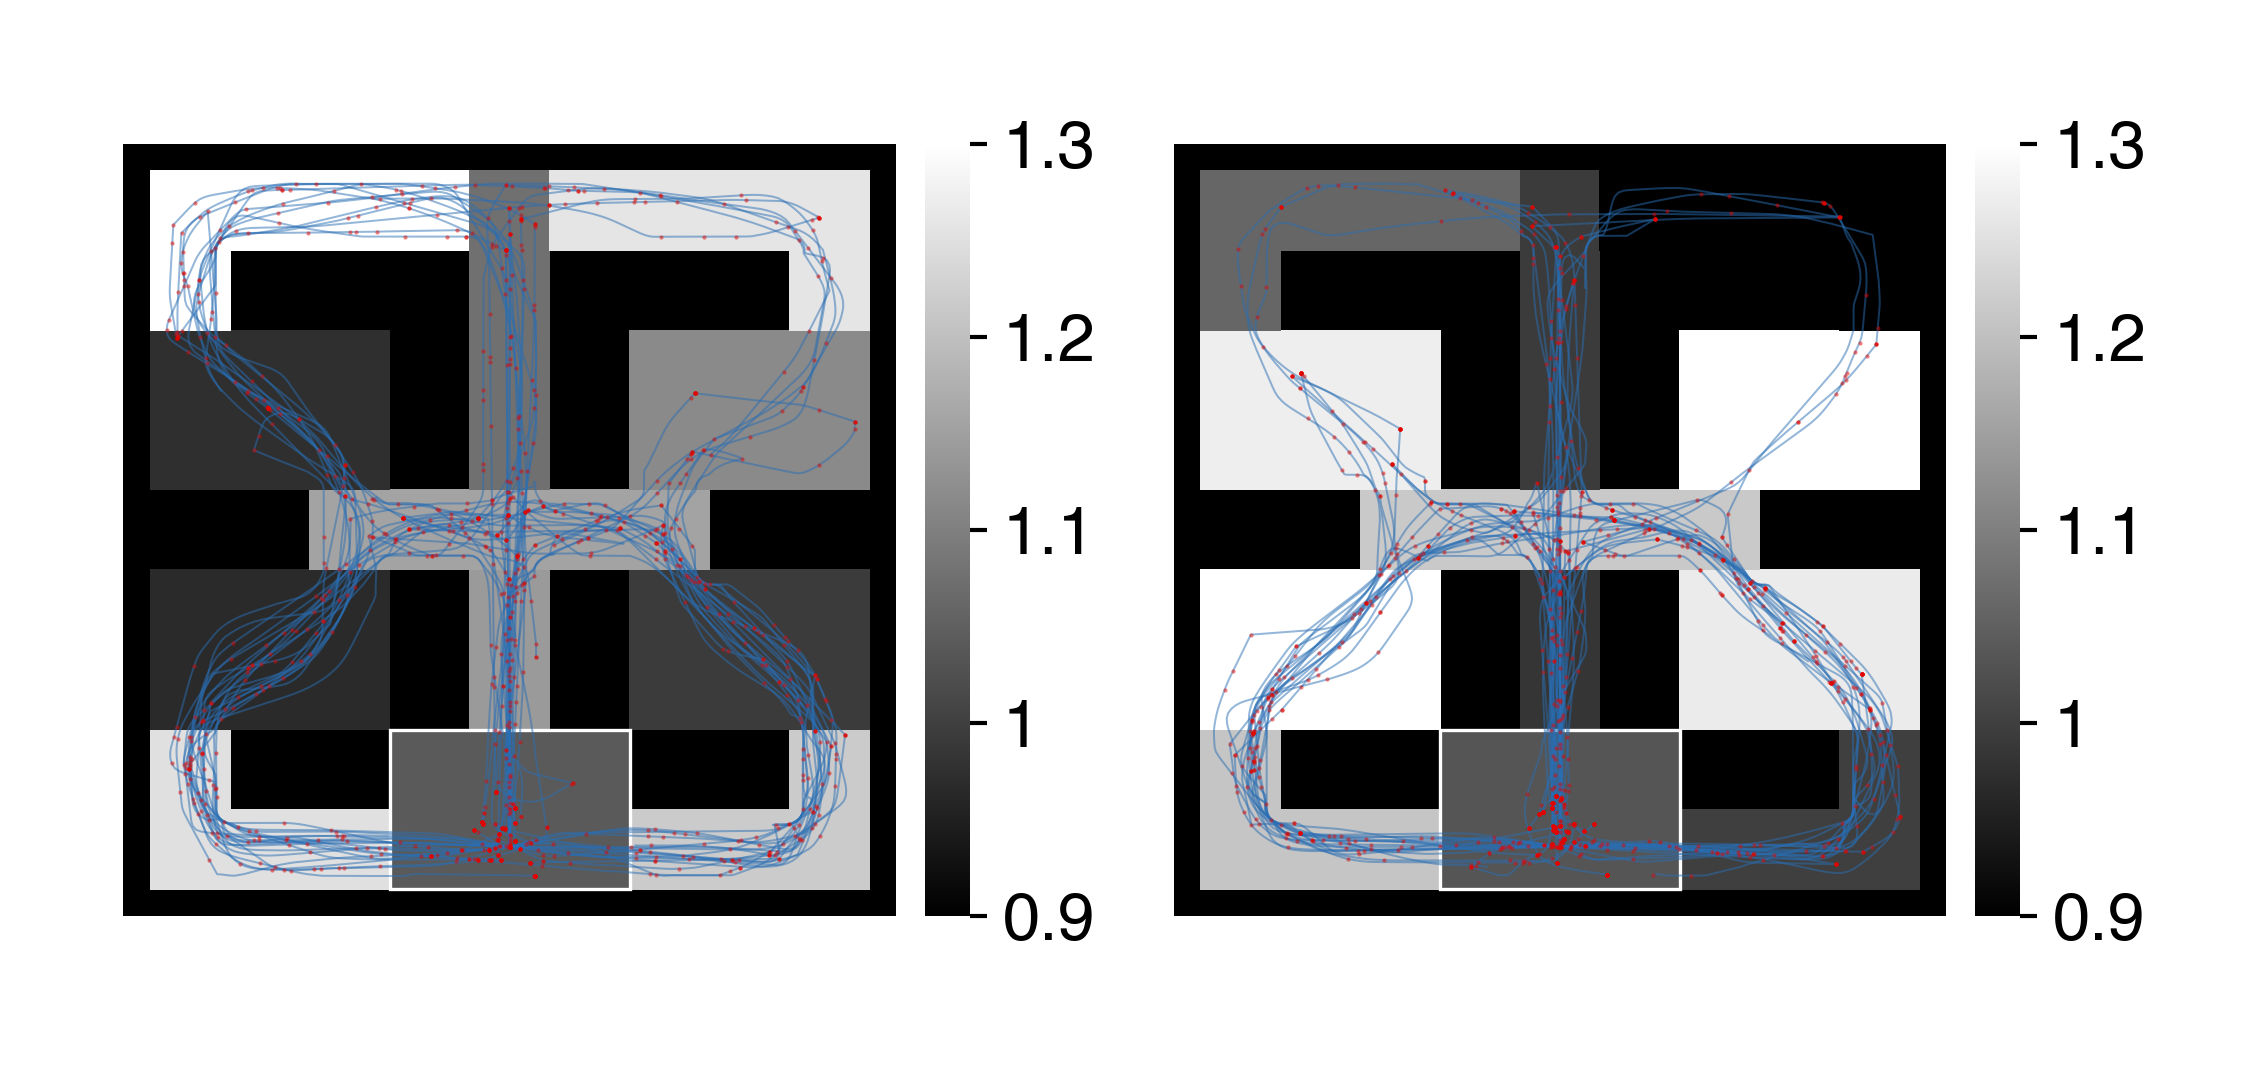

In [145]:
# Plot a neuron's firing rate by maze location.
subj_sess_unit = 'U526_ses0-44-1'
game_states = ['Encoding', 'Retrieval']
savefig = False
overwrite = False
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 7}
base_color = 'w'
show_spikes = True
only_show_spikes_when_moving = False

subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])    
fig, ax = time_cell_plots.plot_firing_maze2(subj_sess,
                                            neuron,
                                            font=font,
                                            base_color=base_color,
                                            show_spikes=show_spikes,
                                            only_show_spikes_when_moving=only_show_spikes_when_moving,
                                            nav_lw=0.12,
                                            nav_color='#296eb4', #f3a5bf
                                            nav_alpha=0.5,
                                            spike_marker='.',
                                            spike_fill_color='#e10600',
                                            spike_edge_color='#e10600',
                                            spike_alpha=0.5, # 0.25 0.5 0.75
                                            spike_markersize=0.5,
                                            spike_mew=0,
#                                             vmin=2.5,
                                            dpi=dpi)

if savefig:
    chan, unit = neuron.split('-')
    hemroi = spike_preproc.roi_lookup(subj_sess, chan)
    filename = op.join(proj_dir, 'figs', 'plot_navigation', 
                       '{}-CSC{}-unit{}-{}-{}-place_firing.png'.format(subj_sess, chan, unit, hemroi, '_'.join(game_states)))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='png', dpi=dpi, bbox_inches='tight')

print('{}-{}, {}'.format(subj_sess, neuron, '_'.join(game_states)))
fig.show()

U526_ses0-44-1, Encoding_Retrieval


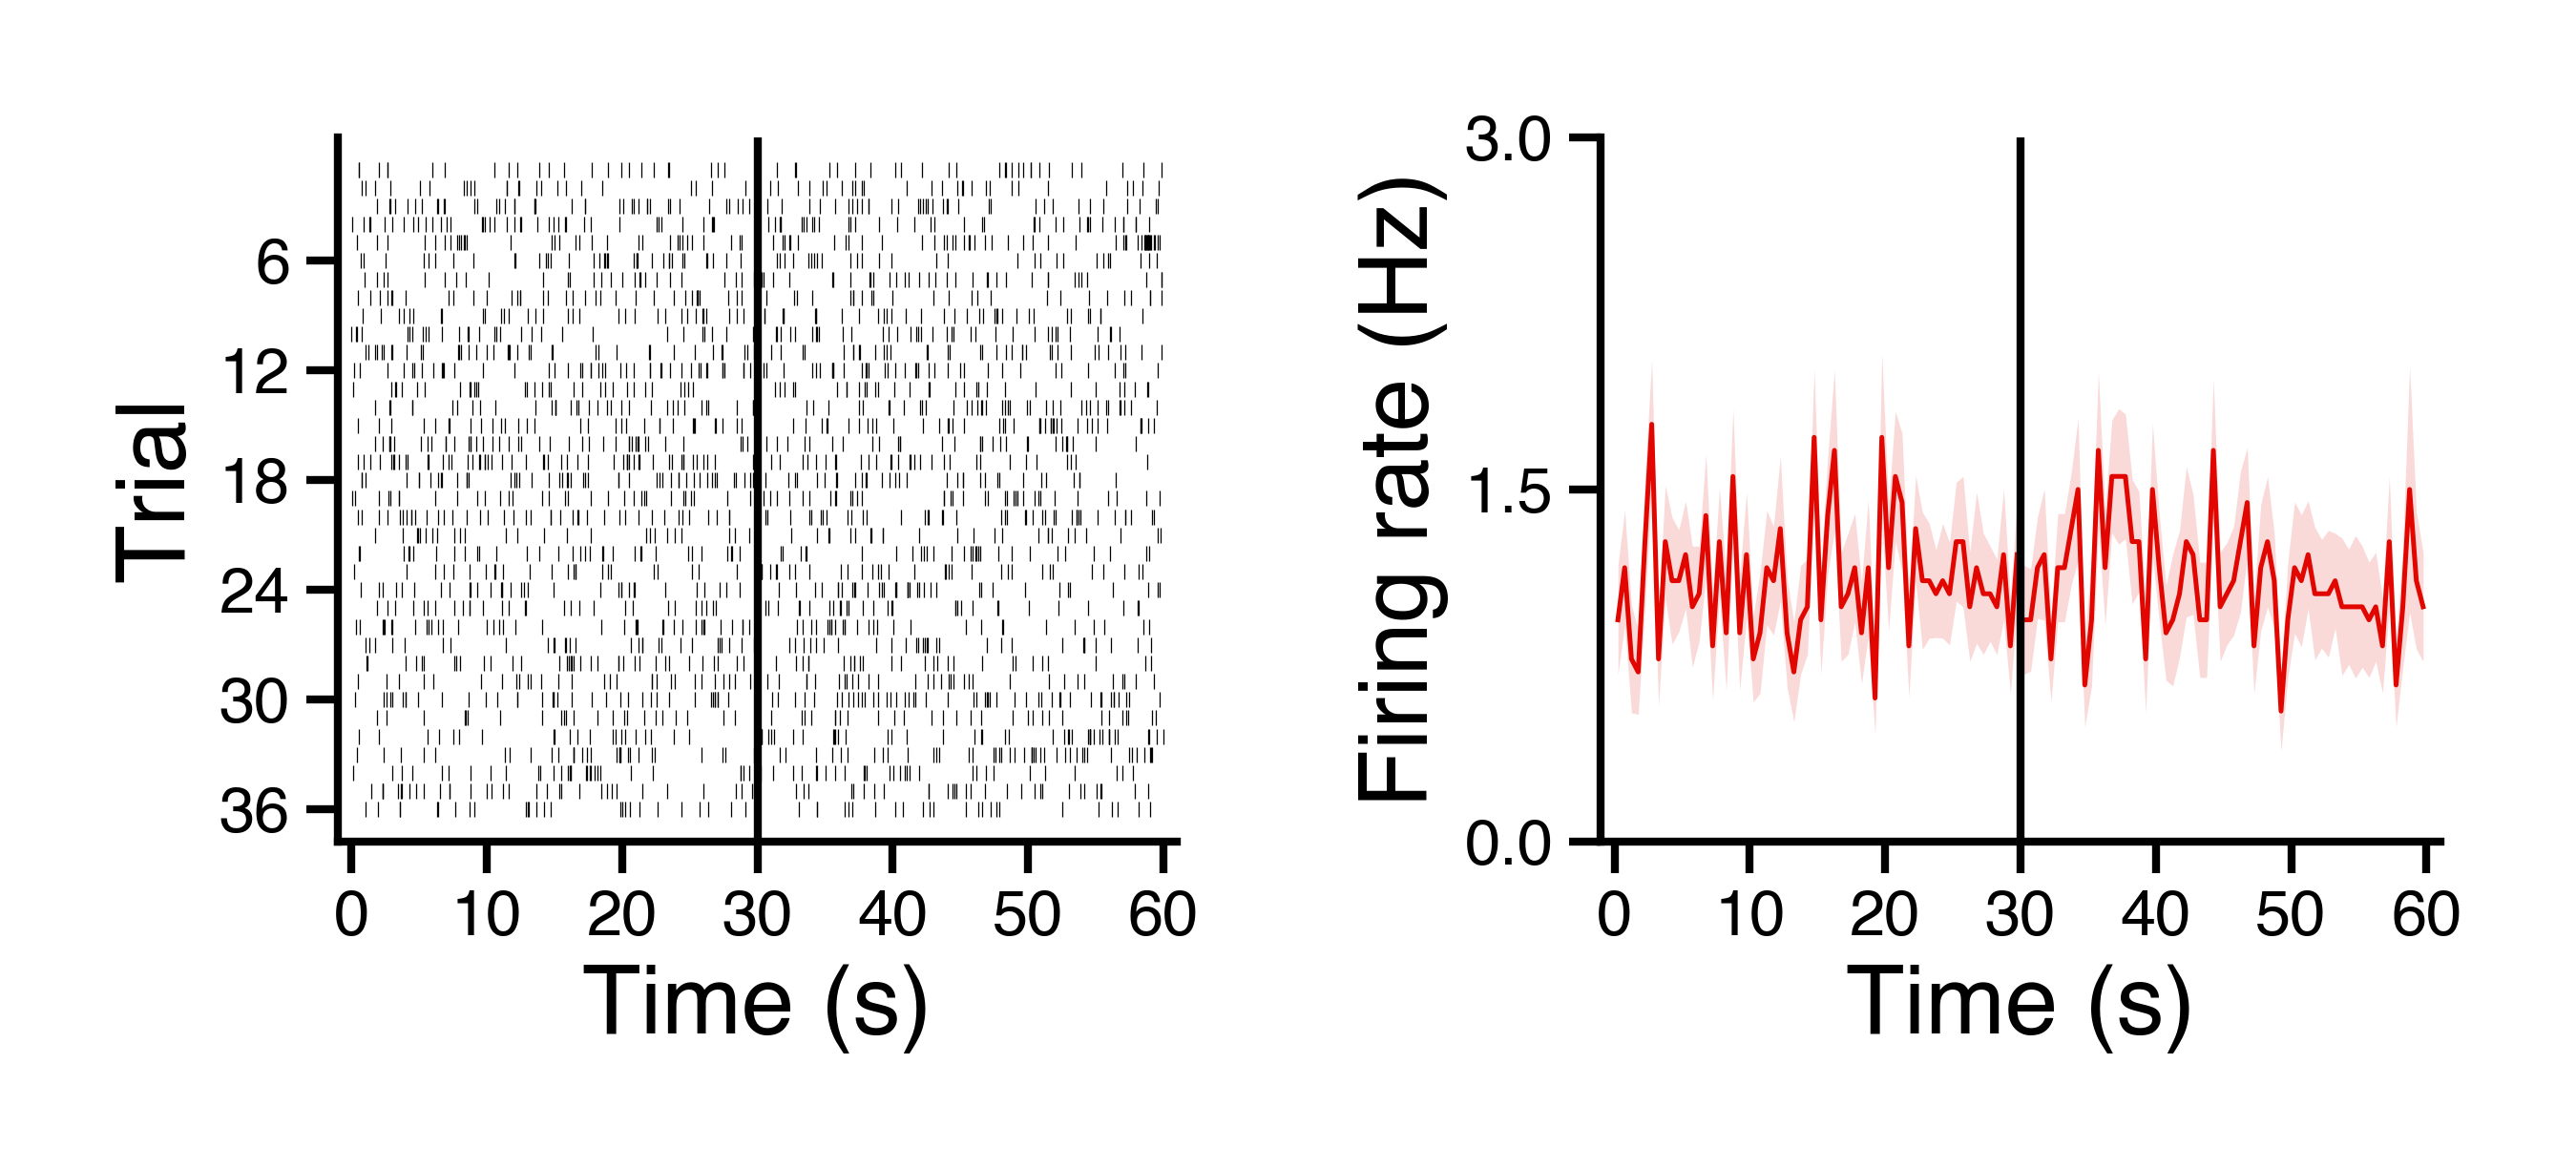

In [146]:
lw = 0.3

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(colws[1], colws[1] * 0.4), dpi=1200)

iax = 0
ax[iax] = time_cell_plots.time_raster(subj_sess,
                                      neuron, 
                                      ['Encoding', 'Retrieval'],
                                      ax=ax[iax],
                                      plot_game_states=False,
                                      plot_title=False,
                                      font=font,
                                      rasterwidth=0.075)

iax = 1
ax[iax] = time_cell_plots.firing_rate_over_time(subj_sess,
                                                neuron, 
                                                ['Encoding', 'Retrieval'],
                                                ax=ax[iax],
                                                plot_game_states=False,
                                                plot_title=False,
                                                plot_labels=True,
                                                linewidth=lw,
                                                font=font)

print('{}-{}, {}'.format(subj_sess, neuron, '_'.join(game_states)))
plt.tight_layout(pad=0, w_pad=1)

In [177]:
subj_sess_unit = 'U526_ses0-44-1'
game_states = ['Encoding', 'Retrieval']
scale_by=10
proj_dir='/home1/dscho/projects/time_cells'

subj_sess = subj_sess_unit.split('-')[0]
neuron = '-'.join(subj_sess_unit.split('-')[1:])

# Load player position and spiking data.
events = events_proc.load_events(subj_sess, proj_dir=proj_dir, verbose=False)
events.maze.maze.loc[:, 'region_precise'] = events.maze.maze['region_precise'].apply(lambda x: x.replace(' ', '_'))
_origin = events.maze.origin * scale_by
event_spikes = time_bin_analysis.load_event_spikes(subj_sess, proj_dir=proj_dir, verbose=False)

# Create category order for maze_region.
# maze_regions = ['SW_Hall',   'SW_Room', 'NW_Room',   'NW_Hall',
#                 'N_Passage', 'C_Hall',  'S_Passage', 'Base',
#                 'SE_Hall',   'SE_Room', 'NE_Room',   'NE_Hall']
maze_regions = ['Base',    'S_Passage', 'C_Hall',  'N_Passage',
                'SW_Hall', 'SW_Room',   'NW_Room', 'NW_Hall', 
                'SE_Hall', 'SE_Room',   'NE_Room', 'NE_Hall']
event_spikes.event_spikes['maze_region'] = event_spikes.event_spikes['maze_region'].astype(pd.CategoricalDtype(maze_regions, ordered=True))

# Find the most recent position to each spike.
spike_times = spike_preproc.load_spikes(subj_sess, neuron)['spike_times']
spike_loc = []
for trial in events.keep_trials:
    qry = "(trial=={}) & (gameState=={})".format(trial, game_states)
    _positions = events.positions.query(qry).reset_index(drop=True)
    keep_spikes = np.any(events.event_times.query(qry)['time_bins']
                                           .apply(lambda x: [x[0]<=spike<x[-1] for spike in spike_times])
                                           .tolist(), axis=0)
    _spike_times = spike_times[keep_spikes]
    spike_pos_arr = np.array(_positions['start_time']
                             .apply(lambda x: [spike - x for spike in _spike_times]).tolist()) # pos x spike
    spike_pos_arr[spike_pos_arr<0] = 1e6
    _spike_loc = (_positions.loc[np.argmin(spike_pos_arr, axis=0), 'pos']
                            .apply(lambda x: tuple([((x[_i] * scale_by) - _origin[_i]) 
                                                    for _i in range(len(x))])))
    spike_loc += _spike_loc.tolist()
spike_loc = np.array(spike_loc) # spike x (xPos, yPos)

# Calculate mean firing rate (Hz) in each maze region.
fr_pos = (event_spikes.event_spikes.query("(gameState=={})".format(game_states))
                                   .groupby('maze_region')[neuron].mean() * 2)
shp = events.maze.shape * scale_by
maze_fr_mat = np.zeros(shp) * np.nan
for idx, maze_row in events.maze.maze.iterrows():
    if maze_row['region_precise'] in fr_pos:
        coords = (np.array(maze_row['coords']) * scale_by) - _origin
        mesh_coords = tuple(np.meshgrid(range(coords[0][0], coords[1][0]), 
                                        range(coords[0][1], coords[1][1])))
        maze_fr_mat[mesh_coords] = fr_pos[maze_row['region_precise']]

# Get a mask of the maze walls.
mask = np.zeros(shp) * np.nan
for idx, maze_row in events.maze.maze.query("(region=='wall')").iterrows():
    coords = (np.array(maze_row['coords']) * scale_by) - _origin
    mesh_coords = tuple(np.meshgrid(range(coords[0][0], coords[1][0]), 
                                    range(coords[0][1], coords[1][1])))
    mask[mesh_coords] = 1

In [223]:
fr_timepos = (event_spikes.event_spikes.query("(gameState=={})".format(game_states))
                                       .groupby(['time_step', 'maze_region'])[neuron].mean() * 2)

In [239]:
count_timepos = (event_spikes.event_spikes.query("(gameState=={})".format(game_states))
                                          .groupby(['time_step', 'maze_region'])[neuron].size() * 0.5)

In [225]:
event_spikes.event_spikes.maze_region.unique()

['Base', 'SW_Hall', 'SW_Room', 'C_Hall', 'SE_Room', ..., 'NE_Hall', 'NE_Room', 'S_Passage', 'NW_Hall', 'NW_Room']
Length: 12
Categories (12, object): ['Base' < 'S_Passage' < 'C_Hall' < 'N_Passage' ... 'SE_Hall' < 'SE_Room' < 'NE_Room' < 'NE_Hall']

In [226]:
cmat

time_step          1         2         3         4         5         6   \
maze_region                                                               
Base         1.071429  0.833333  0.000000  0.000000  0.400000  1.254902   
S_Passage    1.272727  1.324675  1.111111  0.000000  1.000000  0.571429   
C_Hall       0.000000  2.000000  1.538462  1.019868  1.244444  1.195876   
N_Passage    0.000000  0.571429  1.040000  0.862069  0.800000  1.400000   
SW_Hall      0.000000  1.166667  1.350000  1.000000  1.181818  1.846154   
SW_Room      0.000000  2.000000  1.261538  0.927536  0.933333  1.142857   
NW_Room      0.000000  3.000000  1.285714  0.857143  1.047619  1.230769   
NW_Hall      0.000000  0.000000  1.000000  0.500000  1.521739  1.046154   
SE_Hall      0.000000  1.133333  1.153846  1.200000  1.600000  0.800000   
SE_Room      0.000000  0.000000  1.400000  1.406250  1.318182  1.100000   
NE_Room      0.000000  0.000000  1.000000  0.666667  1.090909  2.000000   
NE_Hall      0.000000  0.000000  0.000000  1.238095  1.000000  0.761905   

time_step          7         8         9         10  
maze_region                                          
Base         1.142857  1.114155  1.029316  1.041420  
S_Passage    1.280000  0.965517  0.750000  0.714286  
C_Hall       0.953846  1.200000  0.842105  0.909091  
N_Passage    1.428571  1.142857  1.333333  0.400000  
SW_Hall      1.130435  1.000000  1.692308  1.285714  
SW_Room      1.375000  0.444444  0.166667  7.000000  
NW_Room      0.952381  1.333333  2.000000  4.000000  
NW_Hall      1.000000  2.000000  1.818182  0.857143  
SE_Hall      1.120000  1.125000  1.000000  1.333333  
SE_Room      0.300000  0.600000  1.000000  0.727273  
NE_Room      1.333333  1.000000  1.250000  0.888889  
NE_Hall      1.466667  1.111111  1.294118  0.666667

In [232]:
np.max(cmat[np.isfinite(cmat)].values), np.min(cmat[np.isfinite(cmat)].values.min())

(210.0, 0.0)

In [240]:
count_timepos.reset_index()

time_step maze_region   44-1
0            1        Base  210.0
1            1   S_Passage    5.5
2            1      C_Hall    0.0
3            1   N_Passage    0.0
4            1     SW_Hall    0.0
5            1     SW_Room    0.0
6            1     NW_Room    0.0
7            1     NW_Hall    0.0
8            1     SE_Hall    0.5
9            1     SE_Room    0.0
10           1     NE_Room    0.0
11           1     NE_Hall    0.0
12           2        Base   72.0
13           2   S_Passage   38.5
14           2      C_Hall   19.0
15           2   N_Passage    3.5
16           2     SW_Hall   36.0
17           2     SW_Room    0.5
18           2     NW_Room    1.0
19           2     NW_Hall    0.0
20           2     SE_Hall   45.0
21           2     SE_Room    0.5
22           2     NE_Room    0.0
23           2     NE_Hall    0.0
24           3        Base    0.0
25           3   S_Passage    4.5
26           3      C_Hall   32.5
27           3   N_Passage   25.0
28           3     SW_Hall   40.0
29           3     SW_Room   32.5
30           3     NW_Room    7.0
31           3     NW_Hall    1.0
32           3     SE_Hall   39.0
33           3     SE_Room   30.0
34           3     NE_Room    4.0
35           3     NE_Hall    0.5
36           4        Base    0.0
37           4   S_Passage    0.5
38           4      C_Hall   75.5
39           4   N_Passage   29.0
40           4     SW_Hall    7.0
41           4     SW_Room   34.5
42           4     NW_Room   14.0
43           4     NW_Hall    4.0
44           4     SE_Hall    7.5
45           4     SE_Room   32.0
46           4     NE_Room    1.5
47           4     NE_Hall   10.5
48           5        Base    5.0
49           5   S_Passage    6.0
50           5      C_Hall   67.5
51           5   N_Passage   35.0
52           5     SW_Hall   11.0
53           5     SW_Room    7.5
54           5     NW_Room   21.0
55           5     NW_Hall   23.0
56           5     SE_Hall    2.5
57           5     SE_Room   22.0
58           5     NE_Room    5.5
59           5     NE_Hall   10.0
60           6        Base   25.5
61           6   S_Passage   14.0
62           6      C_Hall   48.5
63           6   N_Passage   25.0
64           6     SW_Hall    6.5
65           6     SW_Room    7.0
66           6     NW_Room   13.0
67           6     NW_Hall   32.5
68           6     SE_Hall    5.0
69           6     SE_Room   20.0
70           6     NE_Room    8.5
71           6     NE_Hall   10.5
72           7        Base   63.0
73           7   S_Passage   12.5
74           7      C_Hall   32.5
75           7   N_Passage   17.5
76           7     SW_Hall   11.5
77           7     SW_Room    8.0
78           7     NW_Room   21.0
79           7     NW_Hall   11.0
80           7     SE_Hall   12.5
81           7     SE_Room   10.0
82           7     NE_Room    9.0
83           7     NE_Hall    7.5
84           8        Base  109.5
85           8   S_Passage   14.5
86           8      C_Hall   27.5
87           8   N_Passage    7.0
88           8     SW_Hall   13.0
89           8     SW_Room    4.5
90           8     NW_Room    7.5
91           8     NW_Hall    6.5
92           8     SE_Hall    8.0
93           8     SE_Room    5.0
94           8     NE_Room    4.0
95           8     NE_Hall    9.0
96           9        Base  153.5
97           9   S_Passage    4.0
98           9      C_Hall    9.5
99           9   N_Passage    6.0
100          9     SW_Hall    6.5
101          9     SW_Room    6.0
102          9     NW_Room    0.5
103          9     NW_Hall    5.5
104          9     SE_Hall    7.0
105          9     SE_Room    5.0
106          9     NE_Room    4.0
107          9     NE_Hall    8.5
108         10        Base  169.0
109         10   S_Passage    7.0
110         10      C_Hall    5.5
111         10   N_Passage    2.5
112         10     SW_Hall    7.0
113         10     SW_Room    2.0
114         10     NW_Room    0.5
115         10     NW_Hall    3.5
116         10     SE_Hall 

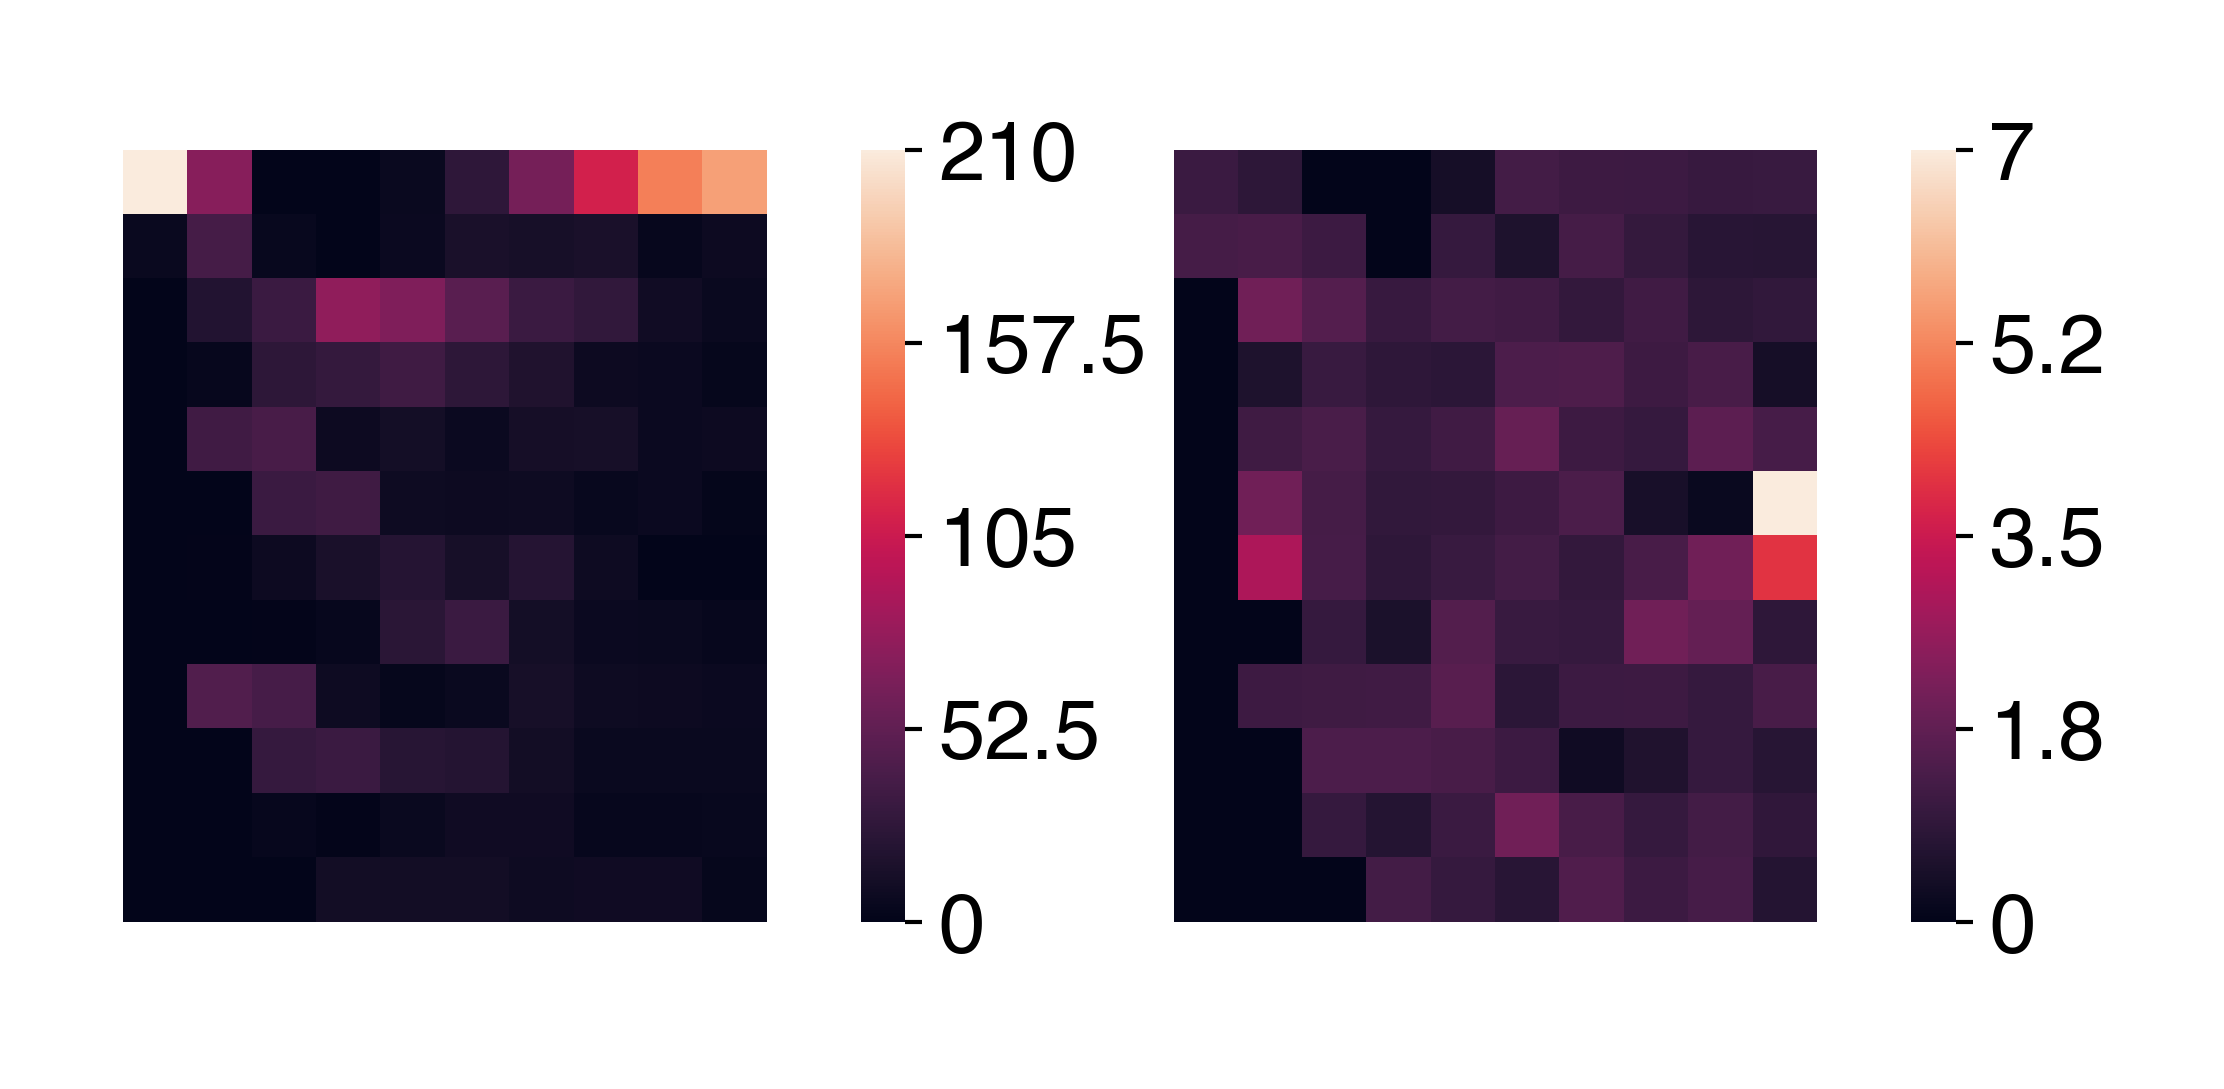

In [247]:
kws = {}
colws = kws.pop('colws', {1: 2.05, 2: 3.125, 3: 6.45})
figsize = (colws[1], colws[1] * 0.4)
dpi = kws.pop('dpi', 1200)
grid_shp = (100, 120)
figsize = (colws[1], colws[1] * (grid_shp[0]/grid_shp[1]))
dpi = kws.pop('dpi', 1200)
plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=50),
      plt.subplot2grid(grid_shp, (0, 51), rowspan=50, colspan=3),
      plt.subplot2grid(grid_shp, (0, 66), rowspan=50, colspan=50),
      plt.subplot2grid(grid_shp, (0, 117), rowspan=50, colspan=3)]
game_states = ['Encoding', 'Retrieval']
font = kws.pop('font', {'tick': 5, 'label': 6, 'fig': 7})
ticklength = kws.pop('ticklength', 1)
tickwidth = kws.pop('tickwidth', 0.25)
tickpad = kws.pop('tickpad', 1)
labelpad = kws.pop('labelpad', 1.5)
cbar_label = kws.pop('cbar_label', None)
fr_cmap = kws.pop('fr_cmap', 'rocket')

# Make the plot.
for _i, dat in enumerate([count_timepos, fr_timepos]):
    iax = 2 * _i

    cmat = pd.pivot(dat.reset_index(), index='maze_region', columns='time_step', values=neuron)
    cmat[np.isnan(cmat)] = 0
    kws['vmin'] = np.max((0, np.min(cmat[np.isfinite(cmat)].values.min())))
    kws['vmax'] = np.max(cmat[np.isfinite(cmat)].values)

    ax[iax] = sns.heatmap(cmat, ax=ax[iax], square=True, cbar=True, cbar_ax=ax[iax+1], cmap=fr_cmap, **kws)

    # Configure the colorbar.
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], length=ticklength, width=tickwidth, pad=tickpad)
    cbar_ticks = np.linspace(kws['vmin'], kws['vmax'], 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)

    # Tweak other plot params.
    ax[iax].set_facecolor('k')
    ax[iax].set_xticks([])
    ax[iax].set_yticks([])
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')

fig.show()

In [172]:
pd.pivot(fr_timepos.reset_index(), index='maze_region', columns='time_step', values=neuron)

time_step          1         2         3         4         5         6   \
maze_region                                                               
SW_Hall           NaN  1.166667  1.350000  1.000000  1.181818  1.846154   
SW_Room           NaN  2.000000  1.261538  0.927536  0.933333  1.142857   
NW_Room           NaN  3.000000  1.285714  0.857143  1.047619  1.230769   
NW_Hall           NaN       NaN  1.000000  0.500000  1.521739  1.046154   
N_Passage         NaN  0.571429  1.040000  0.862069  0.800000  1.400000   
C_Hall            NaN  2.000000  1.538462  1.019868  1.244444  1.195876   
S_Passage    1.272727  1.324675  1.111111  0.000000  1.000000  0.571429   
Base         1.071429  0.833333       NaN       NaN  0.400000  1.254902   
SE_Hall      0.000000  1.133333  1.153846  1.200000  1.600000  0.800000   
SE_Room           NaN  0.000000  1.400000  1.406250  1.318182  1.100000   
NE_Room           NaN       NaN  1.000000  0.666667  1.090909  2.000000   
NE_Hall           NaN       NaN  0.000000  1.238095  1.000000  0.761905   

time_step          7         8         9         10  
maze_region                                          
SW_Hall      1.130435  1.000000  1.692308  1.285714  
SW_Room      1.375000  0.444444  0.166667  7.000000  
NW_Room      0.952381  1.333333  2.000000  4.000000  
NW_Hall      1.000000  2.000000  1.818182  0.857143  
N_Passage    1.428571  1.142857  1.333333  0.400000  
C_Hall       0.953846  1.200000  0.842105  0.909091  
S_Passage    1.280000  0.965517  0.750000  0.714286  
Base         1.142857  1.114155  1.029316  1.041420  
SE_Hall      1.120000  1.125000  1.000000  1.333333  
SE_Room      0.300000  0.600000  1.000000  0.727273  
NE_Room      1.333333  1.000000  1.250000  0.888889  
NE_Hall      1.466667  1.111111  1.294118  0.666667

In [161]:
pd.concat((count_timepos, fr_timepos), axis=1)

time_bin      44-1
time_step maze_region                    
1         Base            210.0  1.071429
          SE_Hall           0.5  0.000000
          S_Passage         5.5  1.272727
2         Base             72.0  0.833333
          C_Hall           19.0  2.000000
          NW_Room           1.0  3.000000
          N_Passage         3.5  0.571429
          SE_Hall          45.0  1.133333
          SE_Room           0.5  0.000000
          SW_Hall          36.0  1.166667
          SW_Room           0.5  2.000000
          S_Passage        38.5  1.324675
3         C_Hall           32.5  1.538462
          NE_Hall           0.5  0.000000
          NE_Room           4.0  1.000000
          NW_Hall           1.0  1.000000
          NW_Room           7.0  1.285714
          N_Passage        25.0  1.040000
          SE_Hall          39.0  1.153846
          SE_Room          30.0  1.400000
          SW_Hall          40.0  1.350000
          SW_Room          32.5  1.261538
          S_Passage         4.5  1.111111
4         C_Hall           75.5  1.019868
          NE_Hall          10.5  1.238095
          NE_Room           1.5  0.666667
          NW_Hall           4.0  0.500000
          NW_Room          14.0  0.857143
          N_Passage        29.0  0.862069
          SE_Hall           7.5  1.200000
          SE_Room          32.0  1.406250
          SW_Hall           7.0  1.000000
          SW_Room          34.5  0.927536
          S_Passage         0.5  0.000000
5         Base              5.0  0.400000
          C_Hall           67.5  1.244444
          NE_Hall          10.0  1.000000
          NE_Room           5.5  1.090909
          NW_Hall          23.0  1.521739
          NW_Room          21.0  1.047619
          N_Passage        35.0  0.800000
          SE_Hall           2.5  1.600000
          SE_Room          22.0  1.318182
          SW_Hall          11.0  1.181818
          SW_Room           7.5  0.933333
          S_Passage         6.0  1.000000
6         Base             25.5  1.254902
          C_Hall           48.5  1.195876
          NE_Hall          10.5  0.761905
          NE_Room           8.5  2.000000
          NW_Hall          32.5  1.046154
          NW_Room          13.0  1.230769
          N_Passage        25.0  1.400000
          SE_Hall           5.0  0.800000
          SE_Room          20.0  1.100000
          SW_Hall           6.5  1.846154
          SW_Room           7.0  1.142857
          S_Passage        14.0  0.571429
7         Base             63.0  1.142857
          C_Hall           32.5  0.953846
          NE_Hall           7.5  1.466667
          NE_Room           9.0  1.333333
          NW_Hall          11.0  1.000000
          NW_Room          21.0  0.952381
          N_Passage        17.5  1.428571
          SE_Hall          12.5  1.120000
          SE_Room          10.0  0.300000
          SW_Hall          11.5  1.130435
          SW_Room           8.0  1.375000
          S_Passage        12.5  1.280000
8         Base            109.5  1.114155
          C_Hall           27.5  1.200000
          NE_Hall           9.0  1.111111
          NE_Room           4.0  1.000000
          NW_Hall           6.5  2.000000
          NW_Room           7.5  1.333333
          N_Passage         7.0  1.142857
          SE_Hall           8.0  1.125000
          SE_Room           5.0  0.600000
          SW_Hall          13.0  1.000000
          SW_Room           4.5  0.444444
          S_Passage        14.5  0.965517
9         Base            153.5  1.029316
          C_Hall            9.5  0.842105
          NE_Hall           8.5  1.294118
          NE_Room           4.0  1.250000
          NW_Hall           5.5  1.818182
          NW_Room           0.5  2.000000
          N_Passage         6.0  1.333333
          SE_Hall           7.0  1.000000
          SE_Room           5.0  1.000000
          SW_Hall           6.5  1.692308
          SW_Room           6.0  0.166667
          S_Passage         4.0  

In [154]:
fr_timepos

time_step  maze_region
1          Base           1.071429
           SE_Hall        0.000000
           S_Passage      1.272727
2          Base           0.833333
           C_Hall         2.000000
           NW_Room        3.000000
           N_Passage      0.571429
           SE_Hall        1.133333
           SE_Room        0.000000
           SW_Hall        1.166667
           SW_Room        2.000000
           S_Passage      1.324675
3          C_Hall         1.538462
           NE_Hall        0.000000
           NE_Room        1.000000
           NW_Hall        1.000000
           NW_Room        1.285714
           N_Passage      1.040000
           SE_Hall        1.153846
           SE_Room        1.400000
           SW_Hall        1.350000
           SW_Room        1.261538
           S_Passage      1.111111
4          C_Hall         1.019868
           NE_Hall        1.238095
           NE_Room        0.666667
           NW_Hall        0.500000
           NW_Room        0.8571